(HW6)=
# HW6

In this task you are suggested to implement gradient descent and Newton's optimization methods, and investigate their performance for three types of functions:

* quadratic function
* loss function of linear regression
* loss function of logistic regression

`BaseSmoothOracle` is an abstract class for objective function $f$ (**oracle**). Each concrete oracle must inherit this class, implementing four methods:

* `func(x)` calculates $f(\boldsymbol x)$
* `grad(x)` calculates $\nabla f(\boldsymbol x)$
* `hess(x)` calculates $\nabla^2 f(\boldsymbol x)$
* `get_opt(x)` calculates point of minimum by direct formula (works only for quadratic and linear regression oracles)

In [4]:
class BaseSmoothOracle(object):
    """
    Base class for implementation of oracles.
    """
    def func(self, x):
        """
        Computes the value of function at point x.
        """
        raise NotImplementedError('Func oracle is not implemented.')

    def grad(self, x):
        """
        Computes the gradient at point x.
        """
        raise NotImplementedError('Grad oracle is not implemented.')
    
    def hess(self, x):
        """
        Computes the Hessian matrix at point x.
        """
        raise NotImplementedError('Hessian oracle is not implemented.')
        
    def get_opt(self):
        """
        Computes the point x at which minimum is attained
        """
        raise NotImplementedError('True solution is unavailable.')

## Quadratic oracle

```{math}
:label: quadratic-oracle
    f(\boldsymbol x) = \frac 12 \boldsymbol x^\mathsf{T} \boldsymbol{Ax} - \boldsymbol b^\mathsf{T} \boldsymbol x, \quad \boldsymbol A^\mathsf{T}  = \boldsymbol A \in \mathbb R^{n\times n}, \quad \boldsymbol b\in\mathbb R^n
```

### Task 6.1 (0.5 points)

Let $\boldsymbol A$ be a symmetric positive definite matrix. Solve the optimization task

$$
    \frac 12 \boldsymbol x^\mathsf{T} \boldsymbol{Ax} - \boldsymbol b^\mathsf{T}\boldsymbol x \to \min\limits_{\boldsymbol x \in \mathbb R^n}
$$

analytically.

#### YOUR SOLUTION HERE

Firstly, we should compute the gradient of $f(\boldsymbol x)$ with respect to x and set it to 0

$$\nabla f(\boldsymbol x) = Ax - b$$

$Ax = b \Rightarrow x = A^{-1}b$, since A is symmetric and positive definite, it also invertible.

This solution provides the value of x that minimizes the quadratic function $f(\boldsymbol x)$. The positive definiteness of A ensures that this solution represents a global minimum of f, because it guarantees that f is convex.


### Task 6.2 (0.5 points)

Implement quadratic oracle {eq}`quadratic-oracle`.

In [5]:
import numpy as np

class QuadraticOracle(BaseSmoothOracle):
    """
    Oracle for quadratic function:
       func(x) = 1/2 x^TAx - b^Tx.
    """

    def __init__(self, A, b):
        if not np.allclose(A, A.T):
            raise ValueError('A should be a symmetric matrix.')
        self.A = A
        self.b = b

    def func(self, x):
        return 0.5 * np.dot(x.T, self.A.dot(x)) - np.dot(self.b, x)

    def grad(self, x):
        return self.A.dot(x) - self.b

    def hess(self, x):
        return self.A
    
    def get_opt(self):
        return np.linalg.solve(self.A, self.b)

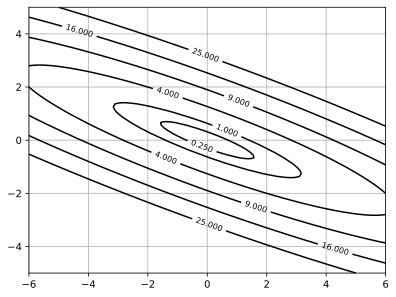

In [12]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg'

def plot_levels(func, xrange=None, yrange=None, levels=None):

    if xrange is None:
        xrange = [-6, 6]
    if yrange is None:
        yrange = [-5, 5]
    if levels is None:
        levels = [0, 0.25, 1, 4, 9, 16, 25]
        
    x = np.linspace(xrange[0], xrange[1], 100)
    y = np.linspace(yrange[0], yrange[1], 100)
    X, Y = np.meshgrid(x, y)
    Z = np.zeros(X.shape)
    for i in range(Z.shape[0]):
        for j in range(Z.shape[1]):
            Z[i, j] = func(np.array([X[i, j], Y[i, j]]))

    CS = plt.contour(X, Y, Z, levels=levels, colors='k')
    plt.clabel(CS, inline=1, fontsize=8) 
    plt.grid()   
    
oracle = QuadraticOracle(np.array([[1.0, 2.0], [2.0, 5.0]]), np.zeros(2))
plot_levels(oracle.func)

## Linear regression oracle


### Task 6.3 (0.5 points)

Implement linear regression oracle

$$
    f(\boldsymbol x) = \frac 1m \Vert \boldsymbol{Ax} - \boldsymbol b\Vert_2^2, \quad \boldsymbol A \in \mathbb R^{m\times n}, \quad \boldsymbol b \in \mathbb R^n
$$

In [27]:
class LinRegOracle(BaseSmoothOracle):
    """
    Oracle for linear regression:
       func(x) = 1/m ||Ax - b||^2.
    """

    def __init__(self, A, b):
        self.A = A
        self.b = b

    def func(self, x):
        return np.linalg.norm(self.A.dot(x) - self.b)**2 / self.A.shape[0]

    def grad(self, x):
        return 2 / self.A.shape[0] * self.A.T.dot(self.A.dot(x) - self.b)

    def hess(self, x):
        return 2 / self.A.shape[0] * self.A.T.dot(self.A)
    
    def get_opt(self):
        return np.linalg.pinv(self.A).dot(self.b)

## Logistic regression oracle

```{math}
:label: log-reg-oracle
    f(\boldsymbol x) = \frac 1m \sum_{i=1}^m \log\big(1 + \exp(-b_i\boldsymbol a_i^\mathsf{T} \boldsymbol x)\big) + \frac C2\Vert \boldsymbol x\Vert_2^2
```

### Task 6.4 (0.5 points)

Show that {eq}`log-reg-oracle` is proportional to the loss function of {ref}`binary logistic regression <simple-log-reg>` model with targets denoted as $\pm 1$.

#### YOUR SOLUTION HERE

In binary logistic regression, the goal is to model the probability that a given input $a_i$ belongs to the positive class
($b_i$ = +1). The logistic model predicts probabilities of the form $\mathbb P(\boldsymbol x \in \text{class }1) = p(y=1|a_i;x) = \sigma(\boldsymbol x_i^\mathsf{T} \boldsymbol w)$, where $\sigma(z) = \frac{1}{1+\exp(-z)}$


The log loss for a single observation is given by:
$$-\log(p(y=1|a_i;x)) = \log\big(1 + \exp(-b_i\boldsymbol a_i^\mathsf{T} \boldsymbol x)\big) $$

This is exactly the first term in $f(\boldsymbol x)$. Thus, $f(\boldsymbol x)$ is proportional to the loss function of the binary logistic regression model with targets denoted as  $\pm 1$ combining the logistic loss and L2 regularization.

### Task 6.5 (1 point)

Find the gradient $\nabla f(\boldsymbol x)$ and hessian $\nabla^2 f(\boldsymbol x)$ of logistic regression oracle {eq}`log-reg-oracle` in matrix-vector form.

#### YOUR SOLUTION HERE
1.Gradient

$$\nabla_x\log\big(1 + \exp(-b_i\boldsymbol a_i^\mathsf{T} \boldsymbol x)\big)$ = $\frac{-b_i a_i exp(-b_i\boldsymbol a_i^\mathsf{T} \boldsymbol x)}{1 + \exp(-b_i\boldsymbol a_i^\mathsf{T} \boldsymbol x)}$$

In matrix form, let A be the matrix with rows $a_i^\mathsf{T}$ and b be the vector of targets $b_i$. We define $z=−Ax \circ b$ where $\circ$ denotes element-wise multiplication. Then, the sigmoid function $\sigma(z) = \frac{1}{1+\exp(z)}$ applied element-wise to z gives us a vector $\sigma$ and the gradient can be expressed as:

$$\nabla f(\boldsymbol x) = - \frac 1m A^\mathsf{T}(b\circ(\sigma-1)) + Cx$$


2.Hessian

$$\nabla^2_x \log\big(1 + \exp(-b_i\boldsymbol a_i^\mathsf{T} \boldsymbol x)\big) = \frac{-b_i a_i  a_i^\mathsf{T} exp(-b_i\boldsymbol a_i^\mathsf{T} \boldsymbol x)}{(1 + \exp(-b_i\boldsymbol a_i^\mathsf{T} \boldsymbol x))^2}$$ 

In matrix-vector form, this results in a summation over i that can be represented using a diagonal matrix D where each diagonal element $D_{ii} = \sigma(z_i)(1-\sigma(z_i))$  represents the contribution of the i-th sample to the curvature.

$$\nabla^2 f(\boldsymbol x) = \frac 1m A^\mathsf{T}DA + CI$$
I-identity matrix

### Task 6.6 (1 point)

Implement logistic regression oracle {eq}`log-reg-oracle`.

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from scipy.special import expit

class LogRegOracle(BaseSmoothOracle):
    """
    Oracle for logistic regression.
    """

    def __init__(self, A, b, regcoef=1):
        self.A = A
        self.b = b
        self.C = regcoef

    def func(self, x):
        logits = self.b * self.A.dot(x)
        return 0.5 * self.C * np.linalg.norm(x)**2 + np.mean(np.logaddexp(np.zeros_like(self.b), - logits))

    def grad(self, x):
        return self.C * x - self.A.T.dot(self.b * expit(- self.b * self.A.dot(x))) / self.b.shape[0]

    def hess(self, x):
        s = expit(- self.b * self.A.dot(x))
        result = self.A.T.dot(np.diag(self.b * self.b * s * (1 - s))).dot(self.A) / self.b.shape[0] 
        return result + self.C * np.eye(x.shape[0]) 
    
    def get_opt(self):
        """
        Since there is no analytic solution for the optimal weights of logistic regression, 
        here we have to cheat a bit
        """
        LR = LogisticRegression(fit_intercept=False, C= 1./self.C/self.A.shape[0])
        LR.fit(self.A, (self.b + 1) / 2)
        return LR.coef_[0]

## Gradient descent

Given a starting point $\boldsymbol x_0 \in\mathbb R^n$ and learning rate $\eta > 0$, iteratively calculate

$$
    \boldsymbol x_{k+1} = \boldsymbol x_k - \eta \nabla f(\boldsymbol x_k), \quad k = 0, 1,\ldots
$$

The process should stop when either $k = \mathrm{max\_iter}$ or 

$$
\Vert \nabla f(\boldsymbol x_k)\Vert_2^2 \leqslant \varepsilon \Vert \nabla f(\boldsymbol x_0)\Vert_2^2
$$

where $\varepsilon > 0$ is tolerance.

### Task 6.7 (1 point)

Complete the implementation of gradient descent algorithm.

In [30]:
from datetime import datetime
from collections import defaultdict

def gradient_descent(oracle, x_0, learning_rate, tolerance=1e-5, max_iter=10000,
                     trace=False, display=False):
    """
    Gradient descent optimization method.

    Parameters
    ----------
    oracle : BaseSmoothOracle-descendant object
        Oracle with .func(), .grad() and .hess() methods implemented for computing
        function value, its gradient and Hessian respectively.
    x_0 : np.array
        Starting point for optimization algorithm.
    learning_rate : float
        Learning rate.
    tolerance : float
        Epsilon value for stopping criterion.
    max_iter : int
        Maximum number of iterations.
    trace : bool
        If True, the progress information is appended into history dictionary during training.
        Otherwise None is returned instead of history.
    display : bool
        If True, debug information is displayed during optimization.
        Printing format and is up to a student and is not checked in any way.

    Returns
    -------
    x_star : np.array
        The point found by the optimization procedure
    message : string
        "success" or the description of error:
            - 'iterations_exceeded': if after max_iter iterations of the method x_k still doesn't satisfy
                the stopping criterion.
            - 'computational_error': in case of getting Infinity or None value during the computations.
    history : dictionary of lists or None
        Dictionary containing the progress information or None if trace=False.
        Dictionary has to be organized as follows:
            - history['time'] : list of floats, containing time in seconds passed from the start of the method
            - history['func'] : list of function values f(x_k) on every step of the algorithm
            - history['grad_norm'] : list of values Euclidian norms ||g(x_k)|| of the gradient on every step of the algorithm
            - history['x'] : list of np.arrays, containing the trajectory of the algorithm. ONLY STORE IF x.size <= 2

    Example:
    --------
    >> oracle = QuadraticOracle(np.eye(5), np.arange(5))
    >> x_opt, message, history = gradient_descent(oracle, np.zeros(5))
    >> print('Found optimal point: {}'.format(x_opt))
       Found optimal point: [ 0.  1.  2.  3.  4.]
    """
    history = defaultdict(list) if trace else None
    x_k = np.copy(x_0).astype(np.float64)
    grad_at_x_0 = oracle.grad(x_0)

    INF = 1e100
    start_time = datetime.now()

    for i in range(max_iter + 1):     
        grad_at_x_k = oracle.grad(x_k)
        if np.any(np.abs(x_k) > INF) or np.any(np.abs(grad_at_x_k) > INF):
            return x_k, 'computational_error', history

        if trace:
            history['time'].append((datetime.now() - start_time).microseconds * 1e-6)
            history['func'].append(oracle.func(x_k))
            history['grad_norm'].append(np.linalg.norm(grad_at_x_k))
            if x_k.shape[0] <= 2:
                history['x'].append(np.array(x_k))

        if display:
            print("iteration {}: |x_k-x_0| = {}, f(x_k) = {}, |grad(f(x_k))| = {}".format(
                i, np.linalg.norm(x_k - x_0), oracle.func(x_k), np.linalg.norm(grad_at_x_k))
            )

        if np.linalg.norm(grad_at_x_k) <= np.sqrt(tolerance) * np.linalg.norm(grad_at_x_0):
            return x_k, 'success', history

        if i == max_iter:
            return x_k, 'iterations_exceeded', history

        x_k -= learning_rate * grad_at_x_k
        
oracle = QuadraticOracle(np.eye(5), np.arange(5))
x_opt, message, history = gradient_descent(oracle, np.zeros(5), 1)
print('Found optimal point: {}'.format(x_opt))

Found optimal point: [0. 1. 2. 3. 4.]


Now it's try to test gradient descent algorithm on different tasks. Here is some auxiliary code for visualization.

In [31]:
import colorsys

def get_color_array(size):
    HSV_tuples = [(float(i) / size, 1.0, 1.0) for i in range(size)]
    RGB_tuples = list(map(lambda x: colorsys.hsv_to_rgb(*x), HSV_tuples))
    return np.array(RGB_tuples)

def plot_2d(history, oracle, x_0, x_opt, scale, title, n_levels=3, xlims=None, ylims=None, bound=None):
    if bound is not None:
        history['x'] = history['x'][:bound]
    hist_x = np.array(history['x']).T
    plt.figure(figsize=(12, 5))
    plt.subplot(121)
    
    plt.plot(np.linalg.norm(hist_x - x_opt[:, None], axis=0), c='c', linewidth=3)
    plt.plot(history['grad_norm'], c='m', linewidth=2)
    plt.xlim(0, len(history['grad_norm']) - 1)
    plt.ylim(0, 2)
    plt.title(title)
    plt.ylabel('Gradients/residuals norm')
    plt.xlabel('Iteration')
    plt.legend(['Residuals', 'Gradients'])
    plt.grid(ls=":")
    
    plt.subplot(122)
    if xlims is not None:
        x_range = xlims
    else:
        x_range = [x_opt[0] - scale, x_opt[0] + scale]
    if ylims is not None:
        y_range = ylims
    else:
        y_range = [x_opt[1] - scale, x_opt[1] + scale]
    func_opt = oracle.func(x_opt)
    levels = [func_opt + 0.25 * scale / n_levels * i for i in range(1, 4*n_levels + 1, 4)]
    # sizes = np.minimum(5 * float(hist_x.shape[1]) / (np.arange(1, hist_x.shape[1] + 1)), 20)
    plt.scatter(hist_x[0], hist_x[1], s=8, c=get_color_array(hist_x.shape[1]))
    plt.plot(hist_x[0], hist_x[1], alpha=0.6, ls="--", c='r')
    # plt.plot(hist_x[0], hist_x[1], c='r', linewidth=3)
    plt.scatter(x_opt[0], x_opt[1], marker='s', c='r', edgecolors='k')
    plot_levels(oracle.func, xrange=x_range, yrange=y_range, levels=levels)
    plt.title('Trajectory')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid(ls=":")
    if xlims is not None:
        plt.xlim(xlims)
    if ylims is not None:
        plt.ylim(ylims)
    plt.show()

def test_2d(method, oracle, x_0, lr, tol=1e-5, scale=1.0, xlims=None, ylims=None, bound=None):
    x_opt = oracle.get_opt()
    if method == 'gd':
        x_star, msg, history = gradient_descent(
            oracle, x_0, lr, tol, trace=True
        )
    elif method == 'newton':
        x_star, msg, history = newton(
            oracle, x_0, lr, tol, trace=True
        )
    else:
        raise ValueError("Unknown error")
    print(msg, len(history['grad_norm']), "iterations")
    plot_2d(history, oracle, x_0, x_opt, scale, 'lr = {}'.format(lr), xlims=xlims, ylims=ylims, bound=bound)


Take a simple quadratic function

$$
    f(x, y) = 2x^2 + 4xy + 5 y^2
$$

which ovbiously has minimum at $(0, 0)$. Now run gradient descent method with $\eta = 0.01$, starting from point $(-2, -1)$:

success 367 iterations


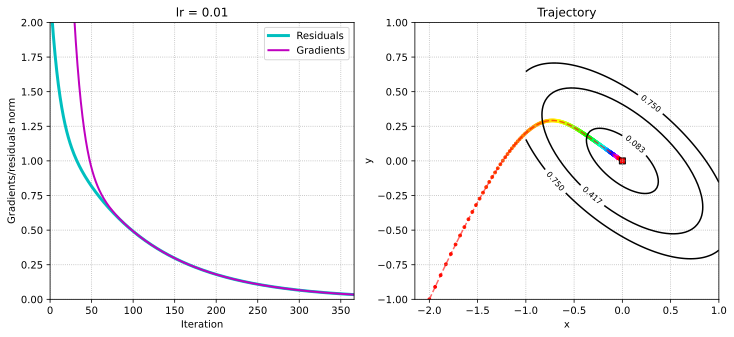

In [32]:
A = np.array([[2, 2], [2, 5]])
b = np.zeros(2)
q_oracle = QuadraticOracle(A, b)
test_2d("gd", q_oracle, np.array([-2.0, -1.0]), lr=0.01)

If you did all correctly, gradient descent should converge here to optimal point. But this is not always the case:

* if $\eta$ is very small, convergence could be too slow
* if $\eta$ is very big, than gradient descent often diverges

### Task 6.8 (1 point)

Take previous quadratic oracle and try different learning rates and starting points. Find the smallest and the largest learning rates for which gradient descent is still convergent. Provide some characteristic plots. Also, plot a graph of required iterations versus $\eta$.

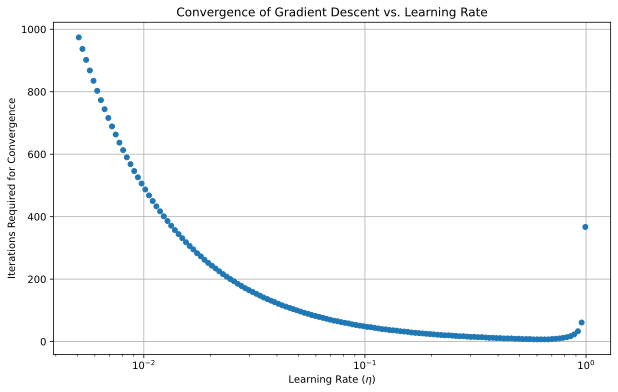

In [97]:
A = np.array([[2, 0], [0, 1]])
b = np.array([0, 0])
oracle = QuadraticOracle(A, b)

x_0 = np.array([2, 2])

learning_rates = np.logspace(-4, 1, 300)

convergence_results = []
iterations_required = []

for eta in learning_rates:
    x_star, message, history = gradient_descent(oracle, x_0, eta, max_iter=1000, trace=True)
    converged = (message == 'success')
    convergence_results.append(converged)
    iterations_required.append(len(history['func']) if converged else None)

converged_rates = np.array(learning_rates)[np.array(convergence_results)]
converged_iterations = np.array(iterations_required)[np.array(convergence_results)]

plt.figure(figsize=(10, 6))
plt.semilogx(converged_rates, converged_iterations, marker='o', linestyle='', markersize=5)
plt.xlabel('Learning Rate ($\eta$)')
plt.ylabel('Iterations Required for Convergence')
plt.title('Convergence of Gradient Descent vs. Learning Rate')
plt.grid(True)
plt.show()

### GD for linear regression

Let's try it for simple linear regression. Here is a toy example:

success 282 iterations


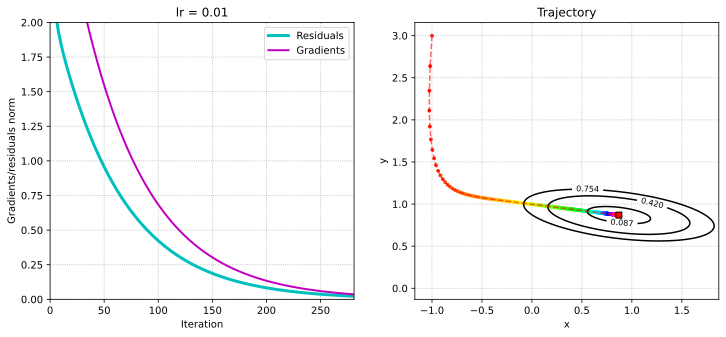

In [28]:
A = np.array([[1, -2.1], [1, 1.2], [1, 4.8]])
b = np.array([-1, 2, 5])
oracle = LinRegOracle(A, b)
test_2d("gd", oracle, np.array([-1, 3.0]), lr=0.01, tol=1e-6)

### Task 6.9 (0.5 points)

Apply gradient descent algorithm to simple linear regression trained on `boston` dataset. Take `lstat` as feature, `medv` as target. Provide some visualizations.

success 5310 iterations


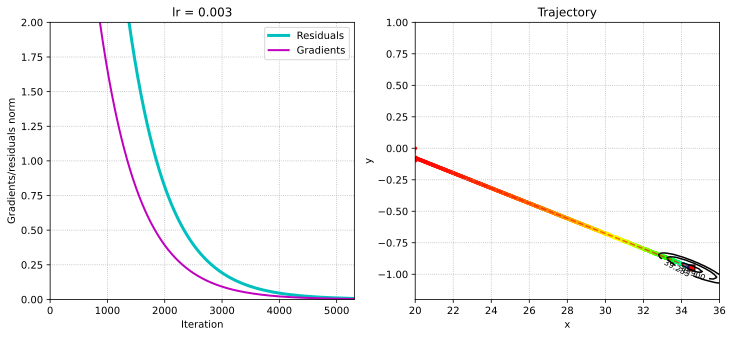

In [47]:
from sklearn.datasets import load_boston
boston = pd.read_csv("Boston.csv").drop("Unnamed: 0", axis=1)
X = np.vstack((np.ones(boston.shape[0]), boston['lstat'])).T
y = boston['medv']

oracle = LinRegOracle(X, y)
test_2d("gd", oracle, np.array([20., 0.]), lr=0.003, tol=1e-8, xlims=[20, 36], ylims=[-1.2, 1])

### GD for logistic regression

The targets must be from $\{-1, 1\}$. One more toy example:

success 525 iterations


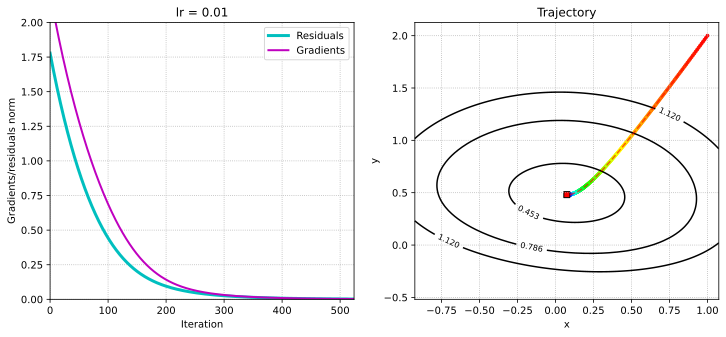

In [48]:
A = np.array([[1, -2.1], [1, 1.2], [1, 4.8], [1, 3.4]])
b = np.array([-1, 1, 1, 1])
oracle = LogRegOracle(A, b)
test_2d("gd", oracle, np.array([1., 2.0]), lr=0.01, tol=1e-6)

### Task 6.10 (0.5 points)

Train simple logistic regression model on `breast_cancer` dataset using your gradient descent method. Take any feature from the dataset. Visualize the results.

success 177 iterations


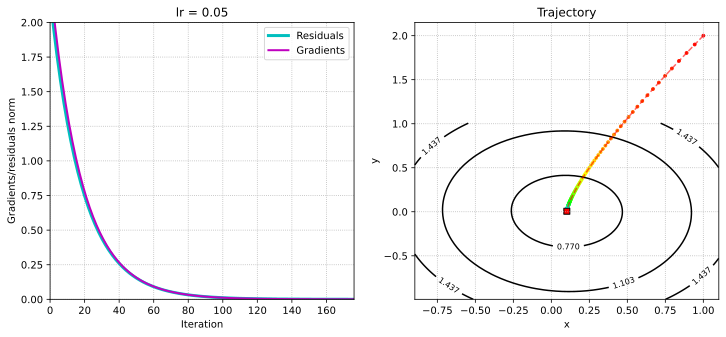

In [49]:
from sklearn.datasets import load_breast_cancer
breast = load_breast_cancer()
y = breast['target']
y[y == 0] = -1
X = np.hstack((np.ones(breast['data'].shape[0])[:, None], breast['data'][:, -1][:, None]))

oracle = LogRegOracle(X, y)
test_2d("gd", oracle, np.array([1., 2.]), lr=0.05, tol=1e-8)

## Newton's method

Given a starting point $\boldsymbol x_0 \in\mathbb R^n$ and learning rate $\eta > 0$, iteratively calculate

$$
    \boldsymbol x_{k+1} = \boldsymbol x_k - \eta \big(\nabla^2 f(\boldsymbol x_k)\big)^{-1} \nabla f(\boldsymbol x_k), \quad k = 0, 1,\ldots
$$

The process should stop when either $k = \mathrm{max\_iter}$ or 

$$
\Vert \nabla f(\boldsymbol x_k)\Vert_2^2 \leqslant \varepsilon \Vert \nabla f(\boldsymbol x_0)\Vert_2^2
$$

where $\varepsilon > 0$ is tolerance.

### Task 6.11 (1 point)

Complete the implementation of Newton's method.

In [50]:
import scipy

def newton(oracle, x_0, learning_rate, tolerance=1e-5, max_iter=100, trace=False, display=False):
    """
    Newton's optimization method.

    Parameters
    ----------
    oracle : BaseSmoothOracle-descendant object
        Oracle with .func(), .grad() and .hess() methods implemented for computing
        function value, its gradient and Hessian respectively. If the Hessian
        returned by the oracle is not positive-definite method stops with message="newton_direction_error"
    x_0 : np.array
        Starting point for optimization algorithm
    learning_rate : float
        Learning rate.
    tolerance : float
        Epsilon value for stopping criterion.
    max_iter : int
        Maximum number of iterations.
    trace : bool
        If True, the progress information is appended into history dictionary during training.
        Otherwise None is returned instead of history.
    display : bool
        If True, debug information is displayed during optimization.

    Returns
    -------
    x_star : np.array
        The point found by the optimization procedure
    message : string
        'success' or the description of error:
            - 'iterations_exceeded': if after max_iter iterations of the method x_k still doesn't satisfy
                the stopping criterion.
            - 'newton_direction_error': in case of failure of solving linear system with Hessian matrix (e.g. non-invertible matrix).
            - 'computational_error': in case of getting Infinity or None value during the computations.
    history : dictionary of lists or None
        Dictionary containing the progress information or None if trace=False.
        Dictionary has to be organized as follows:
            - history['time'] : list of floats, containing time passed from the start of the method
            - history['func'] : list of function values f(x_k) on every step of the algorithm
            - history['grad_norm'] : list of values Euclidian norms ||g(x_k)|| of the gradient on every step of the algorithm
            - history['x'] : list of np.arrays, containing the trajectory of the algorithm. ONLY STORE IF x.size <= 2

    Example:
    --------
    >> oracle = QuadraticOracle(np.eye(5), np.arange(5))
    >> x_opt, message, history = newton(oracle, np.zeros(5), line_search_options={'method': 'Constant', 'c': 1.0})
    >> print('Found optimal point: {}'.format(x_opt))
       Found optimal point: [ 0.  1.  2.  3.  4.]
    """
    history = defaultdict(list) if trace else None
    x_k = np.copy(x_0)
    grad_at_x_0 = oracle.grad(x_0)

    INF = 1e100
    start_time = datetime.now()

    for i in range(max_iter + 1): 
        grad_at_x_k = oracle.grad(x_k)
        hess_at_x_k = oracle.hess(x_k)  

        if np.any(np.abs(x_k) > INF) or np.any(np.abs(grad_at_x_k) > INF):
            return x_k, 'computational_error', history

        if trace:
            history['time'].append((datetime.now() - start_time).seconds)
            history['func'].append(oracle.func(x_k))
            history['grad_norm'].append(np.linalg.norm(grad_at_x_k))
            if x_k.shape[0] <= 2:
                history['x'].append(np.array(x_k))

        if display:
            print("iteration {}: |x_k-x_0| = {}, f(x_k) = {}, |grad(f(x_k))| = {}".format(
                i, np.linalg.norm(x_k - x_0), oracle.func(x_k), np.linalg.norm(grad_at_x_k))
            )

        if np.linalg.norm(grad_at_x_k) <= np.sqrt(tolerance) * np.linalg.norm(grad_at_x_0):
            return x_k, 'success', history

        if i == max_iter:
            return x_k, 'iterations_exceeded', history

        try:
            d_k = scipy.linalg.cho_solve(scipy.linalg.cho_factor(hess_at_x_k, lower=True), grad_at_x_k)
        except np.linalg.LinAlgError as e:
            if display:
                print(e)
            return x_k, 'newton_direction_error', history  

        x_k -= learning_rate * d_k

### Task 6.12 (1 point)

Apply Newton's methods to the previous tasks:

* quadratic function
* simple linear regression trained on `boston` dataset
* simple logistic regression trained on `breast_cancer` dataset

Compare the number of iterations and time execution of GD and Newton methods in this examples. Visualize your results.

In [51]:
from sklearn.datasets import load_boston, load_breast_cancer
from scipy.special import expit as sigmoid
import time

def compare_methods(oracle, x_0, learning_rate, tolerance=1e-5, max_iter=100):
    start_time = time.time()
    x_opt_gd, message_gd, history_gd = gradient_descent(oracle, x_0, learning_rate, tolerance, max_iter, trace=True)
    gd_time = time.time() - start_time
    gd_iters = len(history_gd['func'])

    start_time = time.time()
    x_opt_newton, message_newton, history_newton = newton(oracle, x_0, learning_rate, tolerance, max_iter, trace=True)
    newton_time = time.time() - start_time
    newton_iters = len(history_newton['func'])

    return (x_opt_gd, message_gd, gd_iters, gd_time), (x_opt_newton, message_newton, newton_iters, newton_time)

In [52]:
A = np.eye(5)
b = np.arange(5)
oracle_quad = QuadraticOracle(A, b)
x_0_quad = np.zeros(5)
compare_methods(oracle_quad, x_0_quad, learning_rate=1)

((array([0., 1., 2., 3., 4.]), 'success', 2, 0.004416465759277344),
 (array([0., 1., 2., 3., 4.]), 'success', 2, 0.05573678016662598))

In [84]:
boston = pd.read_csv("Boston.csv").drop("Unnamed: 0", axis=1)
X = np.hstack((np.ones(boston.shape[0])[:, None], boston.drop(["medv"], axis=1)))
y = boston['medv']
oracle = LinRegOracle(X, y)
x_0_linreg = np.zeros(X.shape[1])
compare_methods(oracle, x_0_linreg, learning_rate=1)


((array([-6.47712754e+96, -3.66300171e+97, -5.37563418e+97, -8.52614579e+97,
         -4.25979572e+95, -3.79933200e+96, -4.01621163e+97, -4.83039426e+98,
         -2.15580269e+97, -8.26877706e+97, -3.08723479e+99, -1.22166128e+98,
         -9.23368377e+97]),
  'computational_error',
  18,
  0.010098695755004883),
 (array([ 4.16172702e+01, -1.21388618e-01,  4.69634633e-02,  1.34676947e-02,
          2.83999338e+00, -1.87580220e+01,  3.65811904e+00,  3.61071055e-03,
         -1.49075365e+00,  2.89404521e-01, -1.26819813e-02, -9.37532900e-01,
         -5.52019101e-01]),
  'success',
  2,
  0.0010404586791992188))

In [85]:
breast = pd.read_csv("BrainCancer.csv").drop("Unnamed: 0", axis=1)
X = np.hstack((np.ones(breast['data'].shape[0])[:, None], breast['data']))
y = breast['target']
y[y == 0] = -1
oracle = LogRegOracle(X, y)
x_0_linreg = np.zeros(X.shape[1])
compare_methods(oracle, x_0_linreg, learning_rate=1)

((array([6.27416520e-01, 7.62092970e+00, 1.12400176e+01, 4.89857996e+01,
         2.90362214e+02, 5.80220035e-02, 5.02464148e-02, 2.88973123e-02,
         1.61355255e-02, 1.09287170e-01, 3.94440422e-02, 1.78237961e-01,
         7.65686643e-01, 1.25503462e+00, 1.32605413e+01, 4.51482777e-03,
         1.34507100e-02, 1.63107814e-02, 6.18485413e-03, 1.29146204e-02,
         2.28131863e-03, 8.39470826e+00, 1.47537434e+01, 5.45889631e+01,
         3.50662742e+02, 7.84016520e-02, 1.14611775e-01, 1.04300293e-01,
         4.67076116e-02, 1.69556766e-01, 4.98432689e-02]),
  'iterations_exceeded',
  101,
  0.19497060775756836),
 (array([ 6.62715543e-03,  4.24250315e-02, -1.17268880e-02,  1.41489570e-01,
          9.74068254e-03, -2.85504716e-04, -3.29503621e-03, -4.95720369e-03,
         -1.96773114e-03, -3.66334284e-04,  2.37970691e-05,  8.65030430e-04,
          4.13312446e-03, -8.20600089e-03, -3.27717919e-02, -4.97163827e-05,
         -8.64267658e-04, -1.14610412e-03, -2.71346364e-04, -1.450

success 27 iterations


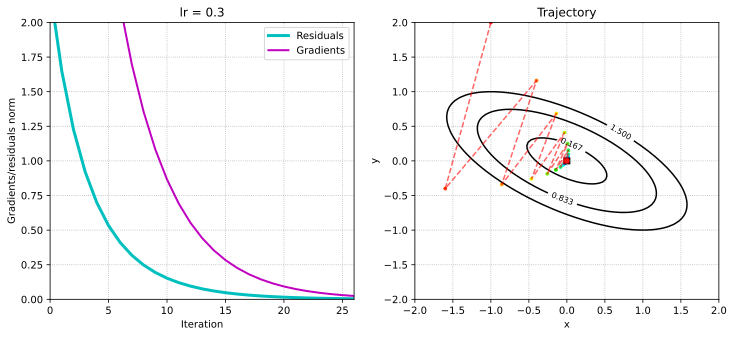

In [59]:
test_2d("gd", q_oracle, np.array([-1.0, 2.0]), lr=0.3, scale=2.0)

success 8 iterations


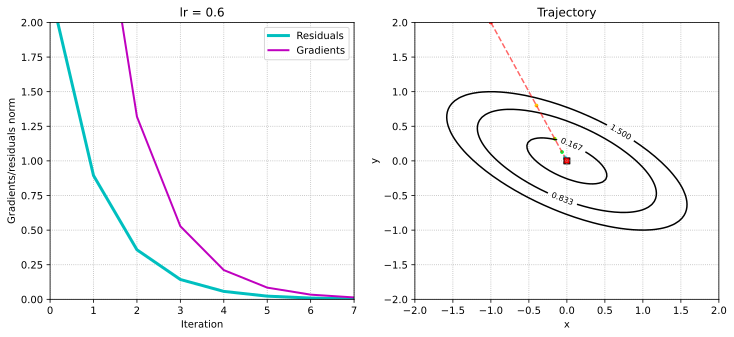

In [91]:
test_2d("newton", q_oracle, np.array([-1.0, 2.0]), lr=0.6, scale=2.0)

iterations_exceeded 10001 iterations


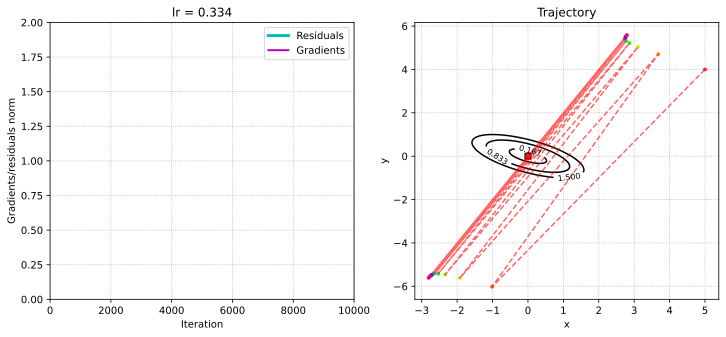

In [92]:
test_2d("gd", q_oracle, np.array([5, 4.0]), lr=0.334, scale=2.0, bound=20)

success 525 iterations


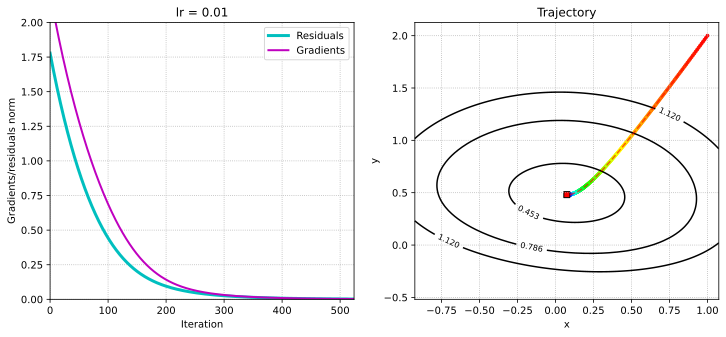

In [95]:
A = np.array([[1, -2.1], [1, 1.2], [1, 4.8], [1, 3.4]])
b = np.array([-1, 1, 1, 1])
oracle = LogRegOracle(A, b)
test_2d("gd", oracle, np.array([1., 2.0]), lr=0.01, tol=1e-6)
# x_star, msg, history = gradient_descent(oracle, np.array([1., 2.0]), 0.01, trace=True, display=True)

success 32 iterations


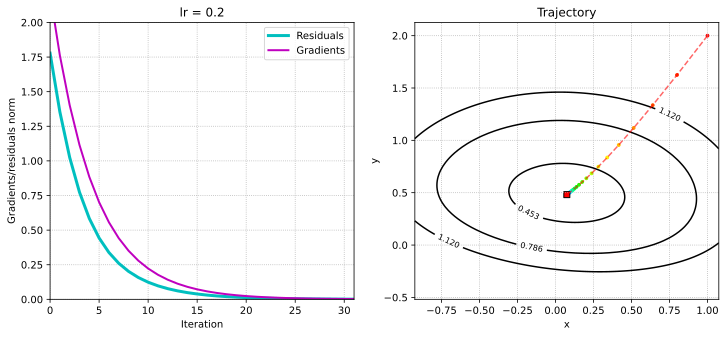

In [96]:
test_2d("newton", oracle, np.array([1., 2.0]), lr=0.2, tol=1e-6)

## GD vs Newton

### Task 6.13 (1 point)

Run both gradient descent and Newton's methods on full `boston` and `breast_cancer` datasets. Do they converge? How many iterations are required for convergence? How much time?

In [61]:
boston = pd.read_csv("Boston.csv").drop("Unnamed: 0", axis=1)
X = np.hstack((np.ones(boston.shape[0])[:, None], boston.drop(["medv"], axis=1)))
y = boston['medv']
oracle = LinRegOracle(X, y)
x_star, msg, history = gradient_descent(
    oracle, np.zeros(X.shape[1]), 1e-6, tolerance=1e-8, max_iter=2*10**4, display=True, trace=True
)

iteration 0: |x_k-x_0| = 0.0, f(x_k) = 592.1469169960475, |grad(f(x_k))| = 17245.33595186298
iteration 1: |x_k-x_0| = 0.01724533595186298, f(x_k) = 354.37307656958393, |grad(f(x_k))| = 10331.98479471063
iteration 2: |x_k-x_0| = 0.027576142939348274, f(x_k) = 268.99498940129456, |grad(f(x_k))| = 6198.091693120722
iteration 3: |x_k-x_0| = 0.033769399590766455, f(x_k) = 238.2388054267043, |grad(f(x_k))| = 3731.4791810015
iteration 4: |x_k-x_0| = 0.037487778682850234, f(x_k) = 227.0605009815383, |grad(f(x_k))| = 2268.269897962366
iteration 5: |x_k-x_0| = 0.03972677374999621, f(x_k) = 222.8996251591939, |grad(f(x_k))| = 1413.5719841934804
iteration 6: |x_k-x_0| = 0.04108239907835986, f(x_k) = 221.25427070018392, |grad(f(x_k))| = 932.7111417625913
iteration 7: |x_k-x_0| = 0.0419114734054253, f(x_k) = 220.51086692917235, |grad(f(x_k))| = 682.0775342705618
iteration 8: |x_k-x_0| = 0.04242759376879699, f(x_k) = 220.0910783941992, |grad(f(x_k))| = 565.5369234933435
iteration 9: |x_k-x_0| = 0.042

iteration 136: |x_k-x_0| = 0.07568945335464497, f(x_k) = 193.32217094594358, |grad(f(x_k))| = 424.7550868451881
iteration 137: |x_k-x_0| = 0.07603951781088873, f(x_k) = 193.14185228884133, |grad(f(x_k))| = 424.29259006806245
iteration 138: |x_k-x_0| = 0.07638995600632417, f(x_k) = 192.9619260887025, |grad(f(x_k))| = 423.83064903121164
iteration 139: |x_k-x_0| = 0.07674075559045873, f(x_k) = 192.7823914471585, |grad(f(x_k))| = 423.3692631118877
iteration 140: |x_k-x_0| = 0.07709190445227884, f(x_k) = 192.60324746790704, |grad(f(x_k))| = 422.908431688067
iteration 141: |x_k-x_0| = 0.07744339071533235, f(x_k) = 192.42449325670813, |grad(f(x_k))| = 422.4481541384493
iteration 142: |x_k-x_0| = 0.07779520273291006, f(x_k) = 192.2461279213778, |grad(f(x_k))| = 421.98842984245726
iteration 143: |x_k-x_0| = 0.07814732908332472, f(x_k) = 192.06815057178488, |grad(f(x_k))| = 421.52925818023397
iteration 144: |x_k-x_0| = 0.07849975856528602, f(x_k) = 191.89056031984552, |grad(f(x_k))| = 421.070638

iteration 250: |x_k-x_0| = 0.11611599598686853, f(x_k) = 175.09075270584395, |grad(f(x_k))| = 375.46493704110804
iteration 251: |x_k-x_0| = 0.11646471498491621, f(x_k) = 174.94985444292612, |grad(f(x_k))| = 375.0619520428357
iteration 252: |x_k-x_0| = 0.11681322205555734, f(x_k) = 174.80925845814417, |grad(f(x_k))| = 374.65945625397137
iteration 253: |x_k-x_0| = 0.11716151565249136, f(x_k) = 174.66896406052814, |grad(f(x_k))| = 374.25744912895755
iteration 254: |x_k-x_0| = 0.1175095942563824, f(x_k) = 174.5289705606972, |grad(f(x_k))| = 373.85593012286756
iteration 255: |x_k-x_0| = 0.11785745637440843, f(x_k) = 174.38927727085576, |grad(f(x_k))| = 373.45489869140476
iteration 256: |x_k-x_0| = 0.11820510053981916, f(x_k) = 174.2498835047895, |grad(f(x_k))| = 373.05435429090176
iteration 257: |x_k-x_0| = 0.1185525253115022, f(x_k) = 174.11078857786242, |grad(f(x_k))| = 372.6542963783209
iteration 258: |x_k-x_0| = 0.11889972927355745, f(x_k) = 173.9719918070126, |grad(f(x_k))| = 372.25472

iteration 376: |x_k-x_0| = 0.1580729402358032, f(x_k) = 159.50815100926394, |grad(f(x_k))| = 328.3699028626389
iteration 377: |x_k-x_0| = 0.1583884984010916, f(x_k) = 159.40038093524387, |grad(f(x_k))| = 328.02445981990775
iteration 378: |x_k-x_0| = 0.1587037711600621, f(x_k) = 159.29283747868618, |grad(f(x_k))| = 327.67944197151326
iteration 379: |x_k-x_0| = 0.15901875845835378, f(x_k) = 159.18552012257183, |grad(f(x_k))| = 327.3348488455682
iteration 380: |x_k-x_0| = 0.15933346024573483, f(x_k) = 159.07842835107004, |grad(f(x_k))| = 326.99067997072535
iteration 381: |x_k-x_0| = 0.1596478764760475, f(x_k) = 158.9715616495362, |grad(f(x_k))| = 326.6469348761753
iteration 382: |x_k-x_0| = 0.1599620071071539, f(x_k) = 158.86491950450815, |grad(f(x_k))| = 326.30361309164783
iteration 383: |x_k-x_0| = 0.1602758521008823, f(x_k) = 158.75850140370446, |grad(f(x_k))| = 325.96071414741016
iteration 384: |x_k-x_0| = 0.1605894114229747, f(x_k) = 158.65230683602078, |grad(f(x_k))| = 325.618237574

iteration 508: |x_k-x_0| = 0.19727548421516142, f(x_k) = 147.06168268087387, |grad(f(x_k))| = 286.27716850415595
iteration 509: |x_k-x_0| = 0.19755396168759287, f(x_k) = 146.97977003475123, |grad(f(x_k))| = 285.98396534552984
iteration 510: |x_k-x_0| = 0.19783216834196138, f(x_k) = 146.89802508189103, |grad(f(x_k))| = 285.6911295110076
iteration 511: |x_k-x_0| = 0.19811010438405074, f(x_k) = 146.81644744069425, |grad(f(x_k))| = 285.3986605942993
iteration 512: |x_k-x_0| = 0.19838777002036415, f(x_k) = 146.7350367304386, |grad(f(x_k))| = 285.10655818957014
iteration 513: |x_k-x_0| = 0.198665165458114, f(x_k) = 146.65379257127665, |grad(f(x_k))| = 284.8148218914399
iteration 514: |x_k-x_0| = 0.19894229090521232, f(x_k) = 146.57271458423352, |grad(f(x_k))| = 284.5234512949832
iteration 515: |x_k-x_0| = 0.1992191465702606, f(x_k) = 146.49180239120543, |grad(f(x_k))| = 284.23244599572763
iteration 516: |x_k-x_0| = 0.19949573266254028, f(x_k) = 146.411055614957, |grad(f(x_k))| = 283.94180558

iteration 668: |x_k-x_0| = 0.23853751433595874, f(x_k) = 135.8545701503663, |grad(f(x_k))| = 243.77634079156775
iteration 669: |x_k-x_0| = 0.23877556726723398, f(x_k) = 135.79517241724778, |grad(f(x_k))| = 243.53703133152104
iteration 670: |x_k-x_0| = 0.23901338688321924, f(x_k) = 135.73589123672232, |grad(f(x_k))| = 243.2980295967526
iteration 671: |x_k-x_0| = 0.2392509734278079, f(x_k) = 135.67672634466584, |grad(f(x_k))| = 243.05933524661742
iteration 672: |x_k-x_0| = 0.23948832714485319, f(x_k) = 135.61767747756076, |grad(f(x_k))| = 242.8209479408371
iteration 673: |x_k-x_0| = 0.23972544827816705, f(x_k) = 135.5587443724948, |grad(f(x_k))| = 242.58286733949961
iteration 674: |x_k-x_0| = 0.23996233707151776, f(x_k) = 135.49992676715928, |grad(f(x_k))| = 242.34509310305896
iteration 675: |x_k-x_0| = 0.24019899376862852, f(x_k) = 135.4412243998479, |grad(f(x_k))| = 242.10762489233485
iteration 676: |x_k-x_0| = 0.24043541861317555, f(x_k) = 135.3826370094553, |grad(f(x_k))| = 241.87046

iteration 777: |x_k-x_0| = 0.2631627914931852, f(x_k) = 130.01401473371556, |grad(f(x_k))| = 219.43335050414055
iteration 778: |x_k-x_0| = 0.26337683203725665, f(x_k) = 129.96588652844315, |grad(f(x_k))| = 219.22565232095963
iteration 779: |x_k-x_0| = 0.2635906653212621, f(x_k) = 129.91784938039203, |grad(f(x_k))| = 219.01822678850425
iteration 780: |x_k-x_0| = 0.2638042915771581, f(x_k) = 129.86990308397253, |grad(f(x_k))| = 218.81107360323864
iteration 781: |x_k-x_0| = 0.2640177110367437, f(x_k) = 129.82204743406652, |grad(f(x_k))| = 218.6041924619409
iteration 782: |x_k-x_0| = 0.2642309239316588, f(x_k) = 129.7742822260271, |grad(f(x_k))| = 218.39758306170367
iteration 783: |x_k-x_0| = 0.2644439304933842, f(x_k) = 129.72660725567667, |grad(f(x_k))| = 218.1912450999334
iteration 784: |x_k-x_0| = 0.2646567309532407, f(x_k) = 129.67902231930634, |grad(f(x_k))| = 217.98517827434924
iteration 785: |x_k-x_0| = 0.26486932554238907, f(x_k) = 129.6315272136751, |grad(f(x_k))| = 217.779382282

iteration 873: |x_k-x_0| = 0.28279816513802425, f(x_k) = 125.78105679363051, |grad(f(x_k))| = 200.695260849692
iteration 874: |x_k-x_0| = 0.2829933423038337, f(x_k) = 125.74079655787232, |grad(f(x_k))| = 200.51239648949246
iteration 875: |x_k-x_0| = 0.2831883336934752, f(x_k) = 125.70060964742365, |grad(f(x_k))| = 200.3297770122702
iteration 876: |x_k-x_0| = 0.28338313952188976, f(x_k) = 125.66049589738579, |grad(f(x_k))| = 200.14740214270716
iteration 877: |x_k-x_0| = 0.28357776000382884, f(x_k) = 125.6204551432384, |grad(f(x_k))| = 199.9652716057592
iteration 878: |x_k-x_0| = 0.28377219535385306, f(x_k) = 125.58048722083846, |grad(f(x_k))| = 199.78338512665545
iteration 879: |x_k-x_0| = 0.2839664457863331, f(x_k) = 125.5405919664197, |grad(f(x_k))| = 199.6017424308983
iteration 880: |x_k-x_0| = 0.28416051151544885, f(x_k) = 125.50076921659128, |grad(f(x_k))| = 199.4203432442623
iteration 881: |x_k-x_0| = 0.28435439275518964, f(x_k) = 125.46101880833754, |grad(f(x_k))| = 199.239187292

iteration 1031: |x_k-x_0| = 0.3114657800235691, f(x_k) = 120.23186353698152, |grad(f(x_k))| = 174.66895435462152
iteration 1032: |x_k-x_0| = 0.31163414577703796, f(x_k) = 120.20136717001316, |grad(f(x_k))| = 174.52153379953694
iteration 1033: |x_k-x_0| = 0.31180235731265676, f(x_k) = 120.17092225218461, |grad(f(x_k))| = 174.3743177805213
iteration 1034: |x_k-x_0| = 0.31197041481474735, f(x_k) = 120.14052866876442, |grad(f(x_k))| = 174.22730606095243
iteration 1035: |x_k-x_0| = 0.3121383184674402, f(x_k) = 120.11018630528405, |grad(f(x_k))| = 174.0804984044268
iteration 1036: |x_k-x_0| = 0.3123060684546745, f(x_k) = 120.07989504753745, |grad(f(x_k))| = 173.93389457475837
iteration 1037: |x_k-x_0| = 0.3124736649601981, f(x_k) = 120.04965478158023, |grad(f(x_k))| = 173.787494335979
iteration 1038: |x_k-x_0| = 0.3126411081675678, f(x_k) = 120.01946539372915, |grad(f(x_k))| = 173.64129745233774
iteration 1039: |x_k-x_0| = 0.31280839826014933, f(x_k) = 119.98932677056155, |grad(f(x_k))| = 17

iteration 1235: |x_k-x_0| = 0.34286302244594136, f(x_k) = 114.93280179906161, |grad(f(x_k))| = 148.51488339221808
iteration 1236: |x_k-x_0| = 0.3430034849397499, f(x_k) = 114.91075332126123, |grad(f(x_k))| = 148.40457349021258
iteration 1237: |x_k-x_0| = 0.3431438270083164, f(x_k) = 114.888737578629, |grad(f(x_k))| = 148.29442399391564
iteration 1238: |x_k-x_0| = 0.34328404879932667, f(x_k) = 114.866754499295, |grad(f(x_k))| = 148.18443470583645
iteration 1239: |x_k-x_0| = 0.34342415046030095, f(x_k) = 114.8448040115537, |grad(f(x_k))| = 148.07460542865363
iteration 1240: |x_k-x_0| = 0.343564132138594, f(x_k) = 114.82288604386382, |grad(f(x_k))| = 147.96493596521552
iteration 1241: |x_k-x_0| = 0.343703993981395, f(x_k) = 114.80100052484762, |grad(f(x_k))| = 147.85542611853947
iteration 1242: |x_k-x_0| = 0.3438437361357282, f(x_k) = 114.7791473832907, |grad(f(x_k))| = 147.746075691812
iteration 1243: |x_k-x_0| = 0.3439833587484525, f(x_k) = 114.75732654814159, |grad(f(x_k))| = 147.63688

iteration 1407: |x_k-x_0| = 0.3653690102335765, f(x_k) = 111.56734493842791, |grad(f(x_k))| = 131.7417163965716
iteration 1408: |x_k-x_0| = 0.36549079854574995, f(x_k) = 111.54999469099572, |grad(f(x_k))| = 131.6562279310601
iteration 1409: |x_k-x_0| = 0.3656124895202886, f(x_k) = 111.53266694891485, |grad(f(x_k))| = 131.57086827366047
iteration 1410: |x_k-x_0| = 0.36573408327853413, f(x_k) = 111.51536166370173, |grad(f(x_k))| = 131.48563725399356
iteration 1411: |x_k-x_0| = 0.3658555799416885, f(x_k) = 111.49807878698333, |grad(f(x_k))| = 131.40053470182892
iteration 1412: |x_k-x_0| = 0.36597697963081255, f(x_k) = 111.48081827049734, |grad(f(x_k))| = 131.31556044708367
iteration 1413: |x_k-x_0| = 0.3660982824668271, f(x_k) = 111.46358006609135, |grad(f(x_k))| = 131.23071431982328
iteration 1414: |x_k-x_0| = 0.36621948857051256, f(x_k) = 111.4463641257232, |grad(f(x_k))| = 131.14599615026114
iteration 1415: |x_k-x_0| = 0.36634059806250957, f(x_k) = 111.42917040146025, |grad(f(x_k))| = 

iteration 1567: |x_k-x_0| = 0.3836947124686975, f(x_k) = 109.04780748870225, |grad(f(x_k))| = 119.59169925676807
iteration 1568: |x_k-x_0| = 0.38380237969929265, f(x_k) = 109.0335093184247, |grad(f(x_k))| = 119.52475033454562
iteration 1569: |x_k-x_0| = 0.38390996731135996, f(x_k) = 109.0192271483147, |grad(f(x_k))| = 119.45790480062168
iteration 1570: |x_k-x_0| = 0.3840174754054932, f(x_k) = 109.00496094472585, |grad(f(x_k))| = 119.39116250754716
iteration 1571: |x_k-x_0| = 0.3841249040821671, f(x_k) = 108.99071067408863, |grad(f(x_k))| = 119.32452330801284
iteration 1572: |x_k-x_0| = 0.3842322534417375, f(x_k) = 108.97647630290992, |grad(f(x_k))| = 119.25798705484914
iteration 1573: |x_k-x_0| = 0.38433952358444146, f(x_k) = 108.9622577977728, |grad(f(x_k))| = 119.1915536010261
iteration 1574: |x_k-x_0| = 0.3844467146103976, f(x_k) = 108.94805512533651, |grad(f(x_k))| = 119.12522279965329
iteration 1575: |x_k-x_0| = 0.3845538266196058, f(x_k) = 108.93386825233623, |grad(f(x_k))| = 119

iteration 1845: |x_k-x_0| = 0.4108896342027002, f(x_k) = 105.58632507246834, |grad(f(x_k))| = 104.4720116847538
iteration 1846: |x_k-x_0| = 0.4109786486820886, f(x_k) = 105.57541293871937, |grad(f(x_k))| = 104.428615802684
iteration 1847: |x_k-x_0| = 0.41106760735111714, f(x_k) = 105.56450986592084, |grad(f(x_k))| = 104.38528760303198
iteration 1848: |x_k-x_0| = 0.4111565102818234, f(x_k) = 105.55361583618621, |grad(f(x_k))| = 104.34202697616197
iteration 1849: |x_k-x_0| = 0.41124535754615743, f(x_k) = 105.54273083166967, |grad(f(x_k))| = 104.29883381257025
iteration 1850: |x_k-x_0| = 0.41133414921598177, f(x_k) = 105.53185483456555, |grad(f(x_k))| = 104.2557080028848
iteration 1851: |x_k-x_0| = 0.4114228853630713, f(x_k) = 105.52098782710864, |grad(f(x_k))| = 104.21264943786522
iteration 1852: |x_k-x_0| = 0.41151156605911376, f(x_k) = 105.5101297915738, |grad(f(x_k))| = 104.16965800840293
iteration 1853: |x_k-x_0| = 0.4116001913757093, f(x_k) = 105.49928071027597, |grad(f(x_k))| = 104

iteration 2021: |x_k-x_0| = 0.4257577876673241, f(x_k) = 103.79079903889289, |grad(f(x_k))| = 97.78374998488462
iteration 2022: |x_k-x_0| = 0.42583801427583334, f(x_k) = 103.78123899379361, |grad(f(x_k))| = 97.75069372999863
iteration 2023: |x_k-x_0| = 0.42591819648678375, f(x_k) = 103.77168540932149, |grad(f(x_k))| = 97.7176878477974
iteration 2024: |x_k-x_0| = 0.4259983343582141, f(x_k) = 103.76213827345336, |grad(f(x_k))| = 97.68473225104417
iteration 2025: |x_k-x_0| = 0.4260784279480922, f(x_k) = 103.7525975741929, |grad(f(x_k))| = 97.65182685262371
iteration 2026: |x_k-x_0| = 0.42615847731431344, f(x_k) = 103.74306329957076, |grad(f(x_k))| = 97.6189715655423
iteration 2027: |x_k-x_0| = 0.426238482514702, f(x_k) = 103.7335354376445, |grad(f(x_k))| = 97.58616630292781
iteration 2028: |x_k-x_0| = 0.4263184436070103, f(x_k) = 103.72401397649851, |grad(f(x_k))| = 97.55341097802948
iteration 2029: |x_k-x_0| = 0.4263983606489195, f(x_k) = 103.7144989042439, |grad(f(x_k))| = 97.5207055042

iteration 2216: |x_k-x_0| = 0.4406288061679946, f(x_k) = 102.03561089420117, |grad(f(x_k))| = 92.19134747869286
iteration 2217: |x_k-x_0| = 0.4407013903099307, f(x_k) = 102.02711279041307, |grad(f(x_k))| = 92.16660701656966
iteration 2218: |x_k-x_0| = 0.4407739401090464, f(x_k) = 102.01861924578063, |grad(f(x_k))| = 92.14190211455683
iteration 2219: |x_k-x_0| = 0.4408464556108341, f(x_k) = 102.01013025253066, |grad(f(x_k))| = 92.11723270750093
iteration 2220: |x_k-x_0| = 0.4409189368607291, f(x_k) = 102.00164580290757, |grad(f(x_k))| = 92.09259873035246
iteration 2221: |x_k-x_0| = 0.4409913839041096, f(x_k) = 101.99316588917276, |grad(f(x_k))| = 92.06800011816549
iteration 2222: |x_k-x_0| = 0.4410637967862965, f(x_k) = 101.98469050360491, |grad(f(x_k))| = 92.04343680609783
iteration 2223: |x_k-x_0| = 0.4411361755525536, f(x_k) = 101.97621963849984, |grad(f(x_k))| = 92.01890872941075
iteration 2224: |x_k-x_0| = 0.44120852024808765, f(x_k) = 101.96775328617046, |grad(f(x_k))| = 91.994415

iteration 2426: |x_k-x_0| = 0.4551827368137495, f(x_k) = 100.34047356326874, |grad(f(x_k))| = 87.68491652795545
iteration 2427: |x_k-x_0| = 0.4552490251270833, f(x_k) = 100.33278573231287, |grad(f(x_k))| = 87.66636349843256
iteration 2428: |x_k-x_0| = 0.45531528748944067, f(x_k) = 100.3251011534301, |grad(f(x_k))| = 87.64783446257925
iteration 2429: |x_k-x_0| = 0.45538152393563935, f(x_k) = 100.31741982172889, |grad(f(x_k))| = 87.62932937468173
iteration 2430: |x_k-x_0| = 0.45544773450045195, f(x_k) = 100.30974173232804, |grad(f(x_k))| = 87.61084818910743
iteration 2431: |x_k-x_0| = 0.4555139192186066, f(x_k) = 100.30206688035712, |grad(f(x_k))| = 87.59239086030453
iteration 2432: |x_k-x_0| = 0.45558007812478685, f(x_k) = 100.2943952609564, |grad(f(x_k))| = 87.573957342802
iteration 2433: |x_k-x_0| = 0.4556462112536314, f(x_k) = 100.28672686927663, |grad(f(x_k))| = 87.55554759120939
iteration 2434: |x_k-x_0| = 0.4557123186397346, f(x_k) = 100.27906170047923, |grad(f(x_k))| = 87.5371615

iteration 2597: |x_k-x_0| = 0.4661678691397977, f(x_k) = 99.06945868907867, |grad(f(x_k))| = 84.8263260345549
iteration 2598: |x_k-x_0| = 0.4662301910083033, f(x_k) = 99.06226382204711, |grad(f(x_k))| = 84.81127405506038
iteration 2599: |x_k-x_0| = 0.46629249227035596, f(x_k) = 99.05507150755152, |grad(f(x_k))| = 84.79623934086156
iteration 2600: |x_k-x_0| = 0.46635477295384226, f(x_k) = 99.04788174221244, |grad(f(x_k))| = 84.78122185853465
iteration 2601: |x_k-x_0| = 0.4664170330866122, f(x_k) = 99.04069452265774, |grad(f(x_k))| = 84.76622157471849
iteration 2602: |x_k-x_0| = 0.4664792726964796, f(x_k) = 99.03350984552249, |grad(f(x_k))| = 84.75123845611496
iteration 2603: |x_k-x_0| = 0.46654149181122145, f(x_k) = 99.02632770744891, |grad(f(x_k))| = 84.7362724694886
iteration 2604: |x_k-x_0| = 0.46660369045857875, f(x_k) = 99.01914810508639, |grad(f(x_k))| = 84.72132358166662
iteration 2605: |x_k-x_0| = 0.466665868666256, f(x_k) = 99.0119710350915, |grad(f(x_k))| = 84.70639175953879
i

iteration 2735: |x_k-x_0| = 0.4745849332355901, f(x_k) = 98.09934634034875, |grad(f(x_k))| = 82.89891084353874
iteration 2736: |x_k-x_0| = 0.474644659998205, f(x_k) = 98.09247464822056, |grad(f(x_k))| = 82.88595108567999
iteration 2737: |x_k-x_0| = 0.4747043696757531, f(x_k) = 98.08560510399252, |grad(f(x_k))| = 82.8730045342333
iteration 2738: |x_k-x_0| = 0.47476406229147794, f(x_k) = 98.07873770514112, |grad(f(x_k))| = 82.86007116355839
iteration 2739: |x_k-x_0| = 0.4748237378685919, f(x_k) = 98.07187244914812, |grad(f(x_k))| = 82.84715094806508
iteration 2740: |x_k-x_0| = 0.4748833964302767, f(x_k) = 98.06500933350056, |grad(f(x_k))| = 82.83424386221314
iteration 2741: |x_k-x_0| = 0.4749430379996831, f(x_k) = 98.0581483556907, |grad(f(x_k))| = 82.82134988051232
iteration 2742: |x_k-x_0| = 0.4750026625999314, f(x_k) = 98.05128951321612, |grad(f(x_k))| = 82.80846897752207
iteration 2743: |x_k-x_0| = 0.4750622702541105, f(x_k) = 98.04443280357945, |grad(f(x_k))| = 82.79560112785168
ite

iteration 2928: |x_k-x_0| = 0.4858214103300576, f(x_k) = 96.81020102018489, |grad(f(x_k))| = 80.61475001715883
iteration 2929: |x_k-x_0| = 0.48587823590224155, f(x_k) = 96.80370271893229, |grad(f(x_k))| = 80.60391848285657
iteration 2930: |x_k-x_0| = 0.48593504834493373, f(x_k) = 96.79720616350005, |grad(f(x_k))| = 80.59309603811185
iteration 2931: |x_k-x_0| = 0.48599184767606285, f(x_k) = 96.79071135218933, |grad(f(x_k))| = 80.58228266547127
iteration 2932: |x_k-x_0| = 0.48604863391353337, f(x_k) = 96.78421828330458, |grad(f(x_k))| = 80.57147834751672
iteration 2933: |x_k-x_0| = 0.48610540707522537, f(x_k) = 96.77772695515368, |grad(f(x_k))| = 80.5606830668655
iteration 2934: |x_k-x_0| = 0.48616216717899446, f(x_k) = 96.77123736604791, |grad(f(x_k))| = 80.54989680616987
iteration 2935: |x_k-x_0| = 0.4862189142426723, f(x_k) = 96.76474951430201, |grad(f(x_k))| = 80.53911954811745
iteration 2936: |x_k-x_0| = 0.48627564828406594, f(x_k) = 96.75826339823386, |grad(f(x_k))| = 80.5283512754

iteration 3130: |x_k-x_0| = 0.4970563344065591, f(x_k) = 95.53089671286769, |grad(f(x_k))| = 78.58989691629696
iteration 3131: |x_k-x_0| = 0.4971108407297757, f(x_k) = 95.52472070670484, |grad(f(x_k))| = 78.58059077499796
iteration 3132: |x_k-x_0| = 0.49716533708859845, f(x_k) = 95.51854616290578, |grad(f(x_k))| = 78.57129083193477
iteration 3133: |x_k-x_0| = 0.49721982349659727, f(x_k) = 95.51237308032394, |grad(f(x_k))| = 78.56199707557822
iteration 3134: |x_k-x_0| = 0.4972742999673231, f(x_k) = 95.5062014578147, |grad(f(x_k))| = 78.55270949442315
iteration 3135: |x_k-x_0| = 0.49732876651430785, f(x_k) = 95.50003129423571, |grad(f(x_k))| = 78.54342807698809
iteration 3136: |x_k-x_0| = 0.49738322315106476, f(x_k) = 95.4938625884468, |grad(f(x_k))| = 78.53415281181562
iteration 3137: |x_k-x_0| = 0.49743766989108784, f(x_k) = 95.48769533930985, |grad(f(x_k))| = 78.52488368747181
iteration 3138: |x_k-x_0| = 0.49749210674785266, f(x_k) = 95.48152954568884, |grad(f(x_k))| = 78.515620692546

iteration 3344: |x_k-x_0| = 0.508513915347857, f(x_k) = 94.2408805368045, |grad(f(x_k))| = 76.7229494436498
iteration 3345: |x_k-x_0| = 0.5085665699584236, f(x_k) = 94.23499444072587, |grad(f(x_k))| = 76.7147417110917
iteration 3346: |x_k-x_0| = 0.5086192171126028, f(x_k) = 94.22910960382761, |grad(f(x_k))| = 76.70653818455224
iteration 3347: |x_k-x_0| = 0.5086718568204079, f(x_k) = 94.22322602533022, |grad(f(x_k))| = 76.6983388566613
iteration 3348: |x_k-x_0| = 0.5087244890918381, f(x_k) = 94.21734370445532, |grad(f(x_k))| = 76.6901437200642
iteration 3349: |x_k-x_0| = 0.5087771139368781, f(x_k) = 94.21146264042585, |grad(f(x_k))| = 76.68195276742185
iteration 3350: |x_k-x_0| = 0.5088297313654981, f(x_k) = 94.20558283246619, |grad(f(x_k))| = 76.67376599141039
iteration 3351: |x_k-x_0| = 0.5088823413876541, f(x_k) = 94.19970427980209, |grad(f(x_k))| = 76.6655833847215
iteration 3352: |x_k-x_0| = 0.5089349440132875, f(x_k) = 94.19382698166046, |grad(f(x_k))| = 76.65740494006214
iteratio

iteration 3588: |x_k-x_0| = 0.5211625756158627, f(x_k) = 92.84031210957029, |grad(f(x_k))| = 74.82935526071697
iteration 3589: |x_k-x_0| = 0.521213675700211, f(x_k) = 92.83471295281983, |grad(f(x_k))| = 74.8219881283845
iteration 3590: |x_k-x_0| = 0.521264770384418, f(x_k) = 92.82911489843877, |grad(f(x_k))| = 74.81462379462154
iteration 3591: |x_k-x_0| = 0.5213158596754716, f(x_k) = 92.82351794589995, |grad(f(x_k))| = 74.80726225502264
iteration 3592: |x_k-x_0| = 0.5213669435803489, f(x_k) = 92.81792209467716, |grad(f(x_k))| = 74.79990350519151
iteration 3593: |x_k-x_0| = 0.5214180221060164, f(x_k) = 92.81232734424474, |grad(f(x_k))| = 74.79254754074125
iteration 3594: |x_k-x_0| = 0.5214690952594307, f(x_k) = 92.80673369407798, |grad(f(x_k))| = 74.78519435729419
iteration 3595: |x_k-x_0| = 0.5215201630475372, f(x_k) = 92.80114114365291, |grad(f(x_k))| = 74.77784395048182
iteration 3596: |x_k-x_0| = 0.5215712254772715, f(x_k) = 92.79554969244629, |grad(f(x_k))| = 74.7704963159449
itera

iteration 3787: |x_k-x_0| = 0.531233509660193, f(x_k) = 91.74716147983774, |grad(f(x_k))| = 73.41327442568492
iteration 3788: |x_k-x_0| = 0.5312836599962119, f(x_k) = 91.74177222375621, |grad(f(x_k))| = 73.40638827987308
iteration 3789: |x_k-x_0| = 0.5313338061320689, f(x_k) = 91.73638397859627, |grad(f(x_k))| = 73.39950421586177
iteration 3790: |x_k-x_0| = 0.5313839480729083, f(x_k) = 91.73099674395739, |grad(f(x_k))| = 73.39262223075387
iteration 3791: |x_k-x_0| = 0.5314340858238659, f(x_k) = 91.72561051943991, |grad(f(x_k))| = 73.38574232165846
iteration 3792: |x_k-x_0| = 0.5314842193900695, f(x_k) = 91.72022530464443, |grad(f(x_k))| = 73.37886448569054
iteration 3793: |x_k-x_0| = 0.5315343487766392, f(x_k) = 91.71484109917225, |grad(f(x_k))| = 73.37198871997128
iteration 3794: |x_k-x_0| = 0.5315844739886865, f(x_k) = 91.70945790262496, |grad(f(x_k))| = 73.36511502162782
iteration 3795: |x_k-x_0| = 0.531634595031315, f(x_k) = 91.70407571460498, |grad(f(x_k))| = 73.35824338779335
ite

iteration 3937: |x_k-x_0| = 0.538711801528342, f(x_k) = 90.94985916942213, |grad(f(x_k))| = 72.4021352658622
iteration 3938: |x_k-x_0| = 0.5387613750778186, f(x_k) = 90.94461733928213, |grad(f(x_k))| = 72.39553211587476
iteration 3939: |x_k-x_0| = 0.5388109451140709, f(x_k) = 90.93937646517922, |grad(f(x_k))| = 72.388930674353
iteration 3940: |x_k-x_0| = 0.5388605116411436, f(x_k) = 90.93413654677893, |grad(f(x_k))| = 72.38233093917958
iteration 3941: |x_k-x_0| = 0.538910074663075, f(x_k) = 90.92889758374713, |grad(f(x_k))| = 72.3757329082414
iteration 3942: |x_k-x_0| = 0.5389596341838969, f(x_k) = 90.92365957575014, |grad(f(x_k))| = 72.36913657942982
iteration 3943: |x_k-x_0| = 0.5390091902076344, f(x_k) = 90.91842252245463, |grad(f(x_k))| = 72.36254195064055
iteration 3944: |x_k-x_0| = 0.539058742738306, f(x_k) = 90.91318642352763, |grad(f(x_k))| = 72.35594901977367
iteration 3945: |x_k-x_0| = 0.5391082917799237, f(x_k) = 90.90795127863645, |grad(f(x_k))| = 72.3493577847337
iteration

iteration 4076: |x_k-x_0| = 0.5455705063666306, f(x_k) = 90.23027291940451, |grad(f(x_k))| = 71.49981773834837
iteration 4077: |x_k-x_0| = 0.5456196276096658, f(x_k) = 90.22516092370991, |grad(f(x_k))| = 71.49343354912911
iteration 4078: |x_k-x_0| = 0.5456687458421576, f(x_k) = 90.22004984083908, |grad(f(x_k))| = 71.48705081235391
iteration 4079: |x_k-x_0| = 0.5457178610673148, f(x_k) = 90.21493967050272, |grad(f(x_k))| = 71.48066952643374
iteration 4080: |x_k-x_0| = 0.5457669732883401, f(x_k) = 90.20983041241213, |grad(f(x_k))| = 71.47428968978294
iteration 4081: |x_k-x_0| = 0.5458160825084315, f(x_k) = 90.20472206627873, |grad(f(x_k))| = 71.46791130081894
iteration 4082: |x_k-x_0| = 0.5458651887307808, f(x_k) = 90.19961463181427, |grad(f(x_k))| = 71.46153435796255
iteration 4083: |x_k-x_0| = 0.545914291958575, f(x_k) = 90.19450810873074, |grad(f(x_k))| = 71.45515885963779
iteration 4084: |x_k-x_0| = 0.5459633921949953, f(x_k) = 90.18940249674043, |grad(f(x_k))| = 71.4487848042718
ite

iteration 4276: |x_k-x_0| = 0.5553387247382767, f(x_k) = 89.22567622240895, |grad(f(x_k))| = 70.24999037711667
iteration 4277: |x_k-x_0| = 0.5553873010224238, f(x_k) = 89.22074137628327, |grad(f(x_k))| = 70.24386891021217
iteration 4278: |x_k-x_0| = 0.5554358748385035, f(x_k) = 89.21580739012548, |grad(f(x_k))| = 70.23774863436229
iteration 4279: |x_k-x_0| = 0.5554844461887719, f(x_k) = 89.21087426369344, |grad(f(x_k))| = 70.23162954850659
iteration 4280: |x_k-x_0| = 0.5555330150754807, f(x_k) = 89.20594199674508, |grad(f(x_k))| = 70.22551165158673
iteration 4281: |x_k-x_0| = 0.5555815815008778, f(x_k) = 89.20101058903865, |grad(f(x_k))| = 70.21939494254654
iteration 4282: |x_k-x_0| = 0.5556301454672068, f(x_k) = 89.19608004033236, |grad(f(x_k))| = 70.21327942033187
iteration 4283: |x_k-x_0| = 0.5556787069767073, f(x_k) = 89.19115035038496, |grad(f(x_k))| = 70.2071650838907
iteration 4284: |x_k-x_0| = 0.5557272660316147, f(x_k) = 89.1862215189551, |grad(f(x_k))| = 70.2010519321731
iter

iteration 4455: |x_k-x_0| = 0.5639965191207088, f(x_k) = 88.35581873569829, |grad(f(x_k))| = 69.17230669406968
iteration 4456: |x_k-x_0| = 0.564044685921305, f(x_k) = 88.35103413255554, |grad(f(x_k))| = 69.16638333733191
iteration 4457: |x_k-x_0| = 0.5640928505972468, f(x_k) = 88.34625034878908, |grad(f(x_k))| = 69.1604610114843
iteration 4458: |x_k-x_0| = 0.5641410131501398, f(x_k) = 88.34146738418603, |grad(f(x_k))| = 69.1545397157793
iteration 4459: |x_k-x_0| = 0.564189173581586, f(x_k) = 88.33668523853387, |grad(f(x_k))| = 69.14861944947062
iteration 4460: |x_k-x_0| = 0.5642373318931845, f(x_k) = 88.33190391162019, |grad(f(x_k))| = 69.1427002118135
iteration 4461: |x_k-x_0| = 0.5642854880865312, f(x_k) = 88.3271234032326, |grad(f(x_k))| = 69.13678200206462
iteration 4462: |x_k-x_0| = 0.5643336421632188, f(x_k) = 88.32234371315899, |grad(f(x_k))| = 69.13086481948203
iteration 4463: |x_k-x_0| = 0.5643817941248366, f(x_k) = 88.31756484118729, |grad(f(x_k))| = 69.1249486633252
iteratio

iteration 4650: |x_k-x_0| = 0.5733506350770118, f(x_k) = 87.43806843664724, |grad(f(x_k))| = 68.03591856914396
iteration 4651: |x_k-x_0| = 0.5733984143233989, f(x_k) = 87.43343974552508, |grad(f(x_k))| = 68.03018366468079
iteration 4652: |x_k-x_0| = 0.5734461917033346, f(x_k) = 87.42881183468164, |grad(f(x_k))| = 68.02444966891208
iteration 4653: |x_k-x_0| = 0.5734939672178847, f(x_k) = 87.42418470392754, |grad(f(x_k))| = 68.01871658131734
iteration 4654: |x_k-x_0| = 0.5735417408681133, f(x_k) = 87.41955835307357, |grad(f(x_k))| = 68.01298440137697
iteration 4655: |x_k-x_0| = 0.5735895126550817, f(x_k) = 87.41493278193046, |grad(f(x_k))| = 68.00725312857233
iteration 4656: |x_k-x_0| = 0.5736372825798489, f(x_k) = 87.41030799030919, |grad(f(x_k))| = 68.00152276238576
iteration 4657: |x_k-x_0| = 0.5736850506434716, f(x_k) = 87.40568397802079, |grad(f(x_k))| = 67.99579330230048
iteration 4658: |x_k-x_0| = 0.5737328168470042, f(x_k) = 87.4010607448764, |grad(f(x_k))| = 67.99006474780063
it

iteration 4801: |x_k-x_0| = 0.5805447160344983, f(x_k) = 86.74786824551005, |grad(f(x_k))| = 67.17996446115025
iteration 4802: |x_k-x_0| = 0.5805922242551024, f(x_k) = 86.74335528609619, |grad(f(x_k))| = 67.17436136085544
iteration 4803: |x_k-x_0| = 0.5806397307452363, f(x_k) = 86.7388430794392, |grad(f(x_k))| = 67.16875910018814
iteration 4804: |x_k-x_0| = 0.5806872355056456, f(x_k) = 86.73433162536361, |grad(f(x_k))| = 67.16315767874828
iteration 4805: |x_k-x_0| = 0.5807347385370737, f(x_k) = 86.72982092369371, |grad(f(x_k))| = 67.15755709613653
iteration 4806: |x_k-x_0| = 0.5807822398402617, f(x_k) = 86.72531097425426, |grad(f(x_k))| = 67.15195735195412
iteration 4807: |x_k-x_0| = 0.5808297394159495, f(x_k) = 86.72080177686996, |grad(f(x_k))| = 67.14635844580302
iteration 4808: |x_k-x_0| = 0.5808772372648745, f(x_k) = 86.71629333136549, |grad(f(x_k))| = 67.14076037728591
iteration 4809: |x_k-x_0| = 0.5809247333877728, f(x_k) = 86.71178563756574, |grad(f(x_k))| = 67.13516314600601
it

iteration 4958: |x_k-x_0| = 0.5879827430550457, f(x_k) = 86.04844271419383, |grad(f(x_k))| = 66.31032205338947
iteration 4959: |x_k-x_0| = 0.5880299875942607, f(x_k) = 86.04404583693632, |grad(f(x_k))| = 66.30484626848165
iteration 4960: |x_k-x_0| = 0.5880772304986969, f(x_k) = 86.0396496858099, |grad(f(x_k))| = 66.29937126779271
iteration 4961: |x_k-x_0| = 0.5881244717688372, f(x_k) = 86.0352542606507, |grad(f(x_k))| = 66.29389705101241
iteration 4962: |x_k-x_0| = 0.5881717114051633, f(x_k) = 86.03085956129487, |grad(f(x_k))| = 66.2884236178309
iteration 4963: |x_k-x_0| = 0.5882189494081554, f(x_k) = 86.02646558757856, |grad(f(x_k))| = 66.2829509679389
iteration 4964: |x_k-x_0| = 0.588266185778292, f(x_k) = 86.02207233933804, |grad(f(x_k))| = 66.27747910102757
iteration 4965: |x_k-x_0| = 0.5883134205160504, f(x_k) = 86.01767981640958, |grad(f(x_k))| = 66.27200801678855
iteration 4966: |x_k-x_0| = 0.5883606536219063, f(x_k) = 86.01328801862968, |grad(f(x_k))| = 66.26653771491398
iterat

iteration 5117: |x_k-x_0| = 0.5954743720896298, f(x_k) = 85.35835405090238, |grad(f(x_k))| = 65.44933039907042
iteration 5118: |x_k-x_0| = 0.595521361860901, f(x_k) = 85.35407061128592, |grad(f(x_k))| = 65.4439756985001
iteration 5119: |x_k-x_0| = 0.5955683500572606, f(x_k) = 85.3497878725254, |grad(f(x_k))| = 65.43862173822241
iteration 5120: |x_k-x_0| = 0.5956153366789864, f(x_k) = 85.34550583446658, |grad(f(x_k))| = 65.43326851799178
iteration 5121: |x_k-x_0| = 0.5956623217263548, f(x_k) = 85.3412244969552, |grad(f(x_k))| = 65.42791603756307
iteration 5122: |x_k-x_0| = 0.5957093051996416, f(x_k) = 85.33694385983729, |grad(f(x_k))| = 65.42256429669143
iteration 5123: |x_k-x_0| = 0.5957562870991211, f(x_k) = 85.33266392295873, |grad(f(x_k))| = 65.41721329513236
iteration 5124: |x_k-x_0| = 0.5958032674250666, f(x_k) = 85.3283846861655, |grad(f(x_k))| = 65.4118630326417
iteration 5125: |x_k-x_0| = 0.5958502461777502, f(x_k) = 85.32410614930376, |grad(f(x_k))| = 65.40651350897565
iterati

iteration 5319: |x_k-x_0| = 0.6049346386708604, f(x_k) = 84.50712222116934, |grad(f(x_k))| = 64.38239847362689
iteration 5320: |x_k-x_0| = 0.6049813145486224, f(x_k) = 84.50297729564576, |grad(f(x_k))| = 64.3771887452515
iteration 5321: |x_k-x_0| = 0.6050279888871686, f(x_k) = 84.49883304088867, |grad(f(x_k))| = 64.37197971362414
iteration 5322: |x_k-x_0| = 0.605074661686585, f(x_k) = 84.49468945675403, |grad(f(x_k))| = 64.36677137855546
iteration 5323: |x_k-x_0| = 0.605121332946957, f(x_k) = 84.49054654309798, |grad(f(x_k))| = 64.36156373985638
iteration 5324: |x_k-x_0| = 0.6051680026683695, f(x_k) = 84.48640429977667, |grad(f(x_k))| = 64.35635679733802
iteration 5325: |x_k-x_0| = 0.6052146708509059, f(x_k) = 84.48226272664614, |grad(f(x_k))| = 64.35115055081174
iteration 5326: |x_k-x_0| = 0.6052613374946492, f(x_k) = 84.47812182356276, |grad(f(x_k))| = 64.34594500008907
iteration 5327: |x_k-x_0| = 0.6053080025996815, f(x_k) = 84.47398159038268, |grad(f(x_k))| = 64.34074014498184
iter

iteration 5480: |x_k-x_0| = 0.6124296686406003, f(x_k) = 83.84833161450747, |grad(f(x_k))| = 63.55248271943244
iteration 5481: |x_k-x_0| = 0.6124760973140336, f(x_k) = 83.84429285850378, |grad(f(x_k))| = 63.54738286947127
iteration 5482: |x_k-x_0| = 0.612522524452918, f(x_k) = 83.84025475065609, |grad(f(x_k))| = 63.542283688356676
iteration 5483: |x_k-x_0| = 0.6125689500572302, f(x_k) = 83.83621729082738, |grad(f(x_k))| = 63.53718517592989
iteration 5484: |x_k-x_0| = 0.6126153741269467, f(x_k) = 83.83218047888072, |grad(f(x_k))| = 63.53208733203229
iteration 5485: |x_k-x_0| = 0.6126617966620428, f(x_k) = 83.8281443146791, |grad(f(x_k))| = 63.526990156505384
iteration 5486: |x_k-x_0| = 0.6127082176624938, f(x_k) = 83.82410879808567, |grad(f(x_k))| = 63.52189364919091
iteration 5487: |x_k-x_0| = 0.612754637128274, f(x_k) = 83.82007392896367, |grad(f(x_k))| = 63.516797809930665
iteration 5488: |x_k-x_0| = 0.6128010550593576, f(x_k) = 83.81603970717617, |grad(f(x_k))| = 63.51170263856668
i

iteration 5634: |x_k-x_0| = 0.6195615797043698, f(x_k) = 83.23391823221893, |grad(f(x_k))| = 62.774894117813176
iteration 5635: |x_k-x_0| = 0.6196077714637459, f(x_k) = 83.2299777017836, |grad(f(x_k))| = 62.76989548802618
iteration 5636: |x_k-x_0| = 0.6196539616788418, f(x_k) = 83.22603779886741, |grad(f(x_k))| = 62.764897504334776
iteration 5637: |x_k-x_0| = 0.6197001503495578, f(x_k) = 83.22209852333933, |grad(f(x_k))| = 62.759900166601376
iteration 5638: |x_k-x_0| = 0.619746337475794, f(x_k) = 83.21815987506831, |grad(f(x_k))| = 62.75490347468844
iteration 5639: |x_k-x_0| = 0.6197925230574499, f(x_k) = 83.2142218539233, |grad(f(x_k))| = 62.74990742845852
iteration 5640: |x_k-x_0| = 0.6198387070944247, f(x_k) = 83.21028445977348, |grad(f(x_k))| = 62.744912027774376
iteration 5641: |x_k-x_0| = 0.6198848895866169, f(x_k) = 83.20634769248772, |grad(f(x_k))| = 62.73991727249884
iteration 5642: |x_k-x_0| = 0.6199310705339253, f(x_k) = 83.20241155193538, |grad(f(x_k))| = 62.73492316249482


iteration 5821: |x_k-x_0| = 0.6281724562484583, f(x_k) = 82.50781343233069, |grad(f(x_k))| = 61.85124435990715
iteration 5822: |x_k-x_0| = 0.6282183570892209, f(x_k) = 82.50398800682343, |grad(f(x_k))| = 61.84636427109435
iteration 5823: |x_k-x_0| = 0.6282642563607171, f(x_k) = 82.50016318494033, |grad(f(x_k))| = 61.84148480444592
iteration 5824: |x_k-x_0| = 0.6283101540627836, f(x_k) = 82.49633896655689, |grad(f(x_k))| = 61.83660595984253
iteration 5825: |x_k-x_0| = 0.6283560501952568, f(x_k) = 82.49251535154843, |grad(f(x_k))| = 61.831727737165
iteration 5826: |x_k-x_0| = 0.6284019447579728, f(x_k) = 82.48869233979052, |grad(f(x_k))| = 61.8268501362941
iteration 5827: |x_k-x_0| = 0.6284478377507677, f(x_k) = 82.48486993115874, |grad(f(x_k))| = 61.8219731571108
iteration 5828: |x_k-x_0| = 0.628493729173477, f(x_k) = 82.48104812552857, |grad(f(x_k))| = 61.81709679949607
iteration 5829: |x_k-x_0| = 0.6285396190259361, f(x_k) = 82.47722692277559, |grad(f(x_k))| = 61.812221063330995
itera

iteration 6049: |x_k-x_0| = 0.638596893865568, f(x_k) = 81.65099768578045, |grad(f(x_k))| = 60.7544600679121
iteration 6050: |x_k-x_0| = 0.6386424322349089, f(x_k) = 81.64730672538798, |grad(f(x_k))| = 60.74971888765382
iteration 6051: |x_k-x_0| = 0.6386879689920403, f(x_k) = 81.64361634103933, |grad(f(x_k))| = 60.74497830418836
iteration 6052: |x_k-x_0| = 0.6387335041367534, f(x_k) = 81.63992653261705, |grad(f(x_k))| = 60.74023831741148
iteration 6053: |x_k-x_0| = 0.6387790376688397, f(x_k) = 81.63623730000378, |grad(f(x_k))| = 60.73549892721899
iteration 6054: |x_k-x_0| = 0.6388245695880905, f(x_k) = 81.63254864308203, |grad(f(x_k))| = 60.73076013350683
iteration 6055: |x_k-x_0| = 0.6388700998942967, f(x_k) = 81.62886056173457, |grad(f(x_k))| = 60.726021936170916
iteration 6056: |x_k-x_0| = 0.6389156285872492, f(x_k) = 81.6251730558439, |grad(f(x_k))| = 60.72128433510724
iteration 6057: |x_k-x_0| = 0.6389611556667388, f(x_k) = 81.62148612529283, |grad(f(x_k))| = 60.71654733021184
ite

iteration 6207: |x_k-x_0| = 0.6457718224792681, f(x_k) = 81.07489559379906, |grad(f(x_k))| = 60.01268965754403
iteration 6208: |x_k-x_0| = 0.6458171034575838, f(x_k) = 81.07129421035471, |grad(f(x_k))| = 60.008041510167914
iteration 6209: |x_k-x_0| = 0.6458623827893617, f(x_k) = 81.06769338475614, |grad(f(x_k))| = 60.003393943724795
iteration 6210: |x_k-x_0| = 0.6459076604743776, f(x_k) = 81.06409311689049, |grad(f(x_k))| = 59.998746958117835
iteration 6211: |x_k-x_0| = 0.6459529365124069, f(x_k) = 81.06049340664485, |grad(f(x_k))| = 59.99410055325033
iteration 6212: |x_k-x_0| = 0.6459982109032254, f(x_k) = 81.05689425390634, |grad(f(x_k))| = 59.98945472902545
iteration 6213: |x_k-x_0| = 0.6460434836466084, f(x_k) = 81.05329565856212, |grad(f(x_k))| = 59.98480948534657
iteration 6214: |x_k-x_0| = 0.6460887547423313, f(x_k) = 81.04969762049939, |grad(f(x_k))| = 59.980164822116976
iteration 6215: |x_k-x_0| = 0.6461340241901695, f(x_k) = 81.0461001396054, |grad(f(x_k))| = 59.9755207392401

iteration 6343: |x_k-x_0| = 0.6519148275426485, f(x_k) = 80.59018254394086, |grad(f(x_k))| = 59.38583541416489
iteration 6344: |x_k-x_0| = 0.6519598825097899, f(x_k) = 80.58665600219166, |grad(f(x_k))| = 59.3812654007843
iteration 6345: |x_k-x_0| = 0.6520049357994123, f(x_k) = 80.5831300031824, |grad(f(x_k))| = 59.37669595551923
iteration 6346: |x_k-x_0| = 0.6520499874112857, f(x_k) = 80.57960454680381, |grad(f(x_k))| = 59.372127078277835
iteration 6347: |x_k-x_0| = 0.6520950373451796, f(x_k) = 80.57607963294676, |grad(f(x_k))| = 59.367558768968415
iteration 6348: |x_k-x_0| = 0.6521400856008639, f(x_k) = 80.572555261502, |grad(f(x_k))| = 59.36299102749912
iteration 6349: |x_k-x_0| = 0.6521851321781079, f(x_k) = 80.56903143236042, |grad(f(x_k))| = 59.35842385377835
iteration 6350: |x_k-x_0| = 0.6522301770766814, f(x_k) = 80.56550814541289, |grad(f(x_k))| = 59.353857247714316
iteration 6351: |x_k-x_0| = 0.6522752202963541, f(x_k) = 80.56198540055034, |grad(f(x_k))| = 59.34929120921545
it

iteration 6500: |x_k-x_0| = 0.6589677684672761, f(x_k) = 80.04309341038619, |grad(f(x_k))| = 58.67524313468861
iteration 6501: |x_k-x_0| = 0.6590125572370178, f(x_k) = 80.03965075771981, |grad(f(x_k))| = 58.67076121087374
iteration 6502: |x_k-x_0| = 0.659057344292996, f(x_k) = 80.036208630963, |grad(f(x_k))| = 58.66627984113549
iteration 6503: |x_k-x_0| = 0.6591021296349806, f(x_k) = 80.03276703001055, |grad(f(x_k))| = 58.66179902538666
iteration 6504: |x_k-x_0| = 0.659146913262741, f(x_k) = 80.02932595475733, |grad(f(x_k))| = 58.657318763540104
iteration 6505: |x_k-x_0| = 0.659191695176047, f(x_k) = 80.0258854050982, |grad(f(x_k))| = 58.65283905550872
iteration 6506: |x_k-x_0| = 0.6592364753746685, f(x_k) = 80.02244538092803, |grad(f(x_k))| = 58.64835990120544
iteration 6507: |x_k-x_0| = 0.6592812538583749, f(x_k) = 80.0190058821418, |grad(f(x_k))| = 58.64388130054314
iteration 6508: |x_k-x_0| = 0.6593260306269362, f(x_k) = 80.01556690863434, |grad(f(x_k))| = 58.63940325343485
iterati

iteration 6690: |x_k-x_0| = 0.6674466063215374, f(x_k) = 79.39831506922268, |grad(f(x_k))| = 57.83352930071214
iteration 6691: |x_k-x_0| = 0.6674910653726689, f(x_k) = 79.39497047871576, |grad(f(x_k))| = 57.82915111436945
iteration 6692: |x_k-x_0| = 0.6675355226668437, f(x_k) = 79.39162639457653, |grad(f(x_k))| = 57.82477346598005
iteration 6693: |x_k-x_0| = 0.6675799782038384, f(x_k) = 79.38828281670433, |grad(f(x_k))| = 57.8203963554612
iteration 6694: |x_k-x_0| = 0.6676244319834305, f(x_k) = 79.38493974499866, |grad(f(x_k))| = 57.81601978273024
iteration 6695: |x_k-x_0| = 0.6676688840053966, f(x_k) = 79.38159717935912, |grad(f(x_k))| = 57.81164374770452
iteration 6696: |x_k-x_0| = 0.6677133342695137, f(x_k) = 79.37825511968515, |grad(f(x_k))| = 57.807268250301384
iteration 6697: |x_k-x_0| = 0.667757782775559, f(x_k) = 79.3749135658763, |grad(f(x_k))| = 57.80289329043823
iteration 6698: |x_k-x_0| = 0.6678022295233096, f(x_k) = 79.37157251783216, |grad(f(x_k))| = 57.79851886803247
ite

iteration 6895: |x_k-x_0| = 0.6765236624621336, f(x_k) = 78.72312157307417, |grad(f(x_k))| = 56.94713412025608
iteration 6896: |x_k-x_0| = 0.6765677567592896, f(x_k) = 78.71987871856209, |grad(f(x_k))| = 56.94286451310208
iteration 6897: |x_k-x_0| = 0.6766118492550927, f(x_k) = 78.71663635029155, |grad(f(x_k))| = 56.93859542735496
iteration 6898: |x_k-x_0| = 0.6766559399493336, f(x_k) = 78.71339446816675, |grad(f(x_k))| = 56.934326862935905
iteration 6899: |x_k-x_0| = 0.6767000288418034, f(x_k) = 78.71015307209194, |grad(f(x_k))| = 56.93005881976608
iteration 6900: |x_k-x_0| = 0.6767441159322931, f(x_k) = 78.70691216197129, |grad(f(x_k))| = 56.92579129776668
iteration 6901: |x_k-x_0| = 0.6767882012205941, f(x_k) = 78.70367173770906, |grad(f(x_k))| = 56.92152429685886
iteration 6902: |x_k-x_0| = 0.6768322847064976, f(x_k) = 78.70043179920945, |grad(f(x_k))| = 56.917257816963925
iteration 6903: |x_k-x_0| = 0.6768763663897948, f(x_k) = 78.69719234637684, |grad(f(x_k))| = 56.91299185800307

iteration 7046: |x_k-x_0| = 0.683161385159942, f(x_k) = 78.2389037868567, |grad(f(x_k))| = 56.308284370814164
iteration 7047: |x_k-x_0| = 0.6832052051326004, f(x_k) = 78.23573328198465, |grad(f(x_k))| = 56.30409261246503
iteration 7048: |x_k-x_0| = 0.6832490232733043, f(x_k) = 78.23256324913335, |grad(f(x_k))| = 56.299901363801936
iteration 7049: |x_k-x_0| = 0.6832928395818575, f(x_k) = 78.22939368821024, |grad(f(x_k))| = 56.29571062474843
iteration 7050: |x_k-x_0| = 0.6833366540580644, f(x_k) = 78.22622459912286, |grad(f(x_k))| = 56.29152039522814
iteration 7051: |x_k-x_0| = 0.6833804667017294, f(x_k) = 78.22305598177873, |grad(f(x_k))| = 56.28733067516462
iteration 7052: |x_k-x_0| = 0.6834242775126568, f(x_k) = 78.2198878360853, |grad(f(x_k))| = 56.28314146448148
iteration 7053: |x_k-x_0| = 0.683468086490651, f(x_k) = 78.21672016195024, |grad(f(x_k))| = 56.278952763102396
iteration 7054: |x_k-x_0| = 0.6835118936355168, f(x_k) = 78.21355295928105, |grad(f(x_k))| = 56.27476457095095
it

iteration 7226: |x_k-x_0| = 0.6910192842620565, f(x_k) = 77.67572961877444, |grad(f(x_k))| = 55.56190646656778
iteration 7227: |x_k-x_0| = 0.6910627714191321, f(x_k) = 77.67264260726172, |grad(f(x_k))| = 55.55780523420905
iteration 7228: |x_k-x_0| = 0.6911062567105554, f(x_k) = 77.66955605145459, |grad(f(x_k))| = 55.553704498009445
iteration 7229: |x_k-x_0| = 0.6911497401361483, f(x_k) = 77.66646995126423, |grad(f(x_k))| = 55.5496042578951
iteration 7230: |x_k-x_0| = 0.6911932216957326, f(x_k) = 77.66338430660191, |grad(f(x_k))| = 55.54550451379209
iteration 7231: |x_k-x_0| = 0.6912367013891305, f(x_k) = 77.66029911737903, |grad(f(x_k))| = 55.54140526562654
iteration 7232: |x_k-x_0| = 0.691280179216164, f(x_k) = 77.65721438350668, |grad(f(x_k))| = 55.5373065133246
iteration 7233: |x_k-x_0| = 0.6913236551766555, f(x_k) = 77.65413010489637, |grad(f(x_k))| = 55.53320825681242
iteration 7234: |x_k-x_0| = 0.6913671292704272, f(x_k) = 77.65104628145929, |grad(f(x_k))| = 55.52911049601619
ite

iteration 7414: |x_k-x_0| = 0.6991618864136565, f(x_k) = 77.1032861299551, |grad(f(x_k))| = 54.79951638262778
iteration 7415: |x_k-x_0| = 0.699205019809697, f(x_k) = 77.10028325281277, |grad(f(x_k))| = 54.795507143228456
iteration 7416: |x_k-x_0| = 0.6992481513084272, f(x_k) = 77.09728081504194, |grad(f(x_k))| = 54.79149838631996
iteration 7417: |x_k-x_0| = 0.6992912809096891, f(x_k) = 77.0942788165575, |grad(f(x_k))| = 54.78749011183081
iteration 7418: |x_k-x_0| = 0.699334408613324, f(x_k) = 77.09127725727453, |grad(f(x_k))| = 54.783482319689426
iteration 7419: |x_k-x_0| = 0.6993775344191742, f(x_k) = 77.08827613710788, |grad(f(x_k))| = 54.779475009824374
iteration 7420: |x_k-x_0| = 0.6994206583270812, f(x_k) = 77.08527545597279, |grad(f(x_k))| = 54.77546818216409
iteration 7421: |x_k-x_0| = 0.6994637803368876, f(x_k) = 77.08227521378427, |grad(f(x_k))| = 54.77146183663711
iteration 7422: |x_k-x_0| = 0.6995069004484351, f(x_k) = 77.07927541045731, |grad(f(x_k))| = 54.76745597317196
it

iteration 7606: |x_k-x_0| = 0.7074085314052558, f(x_k) = 76.53469236245662, |grad(f(x_k))| = 54.0385069477948
iteration 7607: |x_k-x_0| = 0.7074512977396612, f(x_k) = 76.5317723080834, |grad(f(x_k))| = 54.03458904865499
iteration 7608: |x_k-x_0| = 0.7074940621483364, f(x_k) = 76.52885267710936, |grad(f(x_k))| = 54.0306716184857
iteration 7609: |x_k-x_0| = 0.707536824631144, f(x_k) = 76.52593346945311, |grad(f(x_k))| = 54.0267546572176
iteration 7610: |x_k-x_0| = 0.7075795851879465, f(x_k) = 76.52301468503325, |grad(f(x_k))| = 54.022838164781334
iteration 7611: |x_k-x_0| = 0.7076223438186067, f(x_k) = 76.52009632376847, |grad(f(x_k))| = 54.01892214110768
iteration 7612: |x_k-x_0| = 0.7076651005229871, f(x_k) = 76.51717838557747, |grad(f(x_k))| = 54.015006586127264
iteration 7613: |x_k-x_0| = 0.707707855300951, f(x_k) = 76.51426087037893, |grad(f(x_k))| = 54.01109149977087
iteration 7614: |x_k-x_0| = 0.7077506081523612, f(x_k) = 76.51134377809153, |grad(f(x_k))| = 54.007176881969215
iter

iteration 7799: |x_k-x_0| = 0.7156265978647749, f(x_k) = 75.97887164653994, |grad(f(x_k))| = 53.29096033858591
iteration 7800: |x_k-x_0| = 0.7156689901130762, f(x_k) = 75.97603182210378, |grad(f(x_k))| = 53.28713167921062
iteration 7801: |x_k-x_0| = 0.7157113804111126, f(x_k) = 75.9731924056994, |grad(f(x_k))| = 53.283303475627505
iteration 7802: |x_k-x_0| = 0.7157537687587677, f(x_k) = 75.97035339724883, |grad(f(x_k))| = 53.27947572776936
iteration 7803: |x_k-x_0| = 0.7157961551559247, f(x_k) = 75.96751479667432, |grad(f(x_k))| = 53.275648435568904
iteration 7804: |x_k-x_0| = 0.7158385396024672, f(x_k) = 75.96467660389787, |grad(f(x_k))| = 53.27182159895891
iteration 7805: |x_k-x_0| = 0.715880922098279, f(x_k) = 75.96183881884174, |grad(f(x_k))| = 53.267995217872176
iteration 7806: |x_k-x_0| = 0.7159233026432439, f(x_k) = 75.9590014414281, |grad(f(x_k))| = 53.26416929224147
iteration 7807: |x_k-x_0| = 0.7159656812372457, f(x_k) = 75.95616447157917, |grad(f(x_k))| = 53.260343821999605


iteration 7975: |x_k-x_0| = 0.72305749942122, f(x_k) = 75.4852773430002, |grad(f(x_k))| = 52.62407581703218
iteration 7976: |x_k-x_0| = 0.7230995467217534, f(x_k) = 75.48250814830182, |grad(f(x_k))| = 52.62032635058622
iteration 7977: |x_k-x_0| = 0.7231415920531299, f(x_k) = 75.47973934819518, |grad(f(x_k))| = 52.61657732825378
iteration 7978: |x_k-x_0| = 0.7231836354152514, f(x_k) = 75.47697094260529, |grad(f(x_k))| = 52.61282874996943
iteration 7979: |x_k-x_0| = 0.7232256768080202, f(x_k) = 75.47420293145733, |grad(f(x_k))| = 52.60908061566773
iteration 7980: |x_k-x_0| = 0.7232677162313383, f(x_k) = 75.47143531467651, |grad(f(x_k))| = 52.60533292528321
iteration 7981: |x_k-x_0| = 0.7233097536851082, f(x_k) = 75.4686680921881, |grad(f(x_k))| = 52.601585678750446
iteration 7982: |x_k-x_0| = 0.7233517891692319, f(x_k) = 75.46590126391722, |grad(f(x_k))| = 52.59783887600401
iteration 7983: |x_k-x_0| = 0.7233938226836124, f(x_k) = 75.46313482978915, |grad(f(x_k))| = 52.59409251697846
iter

iteration 8192: |x_k-x_0| = 0.7321354591225234, f(x_k) = 74.89348553020342, |grad(f(x_k))| = 51.820740775587325
iteration 8193: |x_k-x_0| = 0.7321770769918106, f(x_k) = 74.89080023572234, |grad(f(x_k))| = 51.81708616405242
iteration 8194: |x_k-x_0| = 0.732218692873074, f(x_k) = 74.88811531997946, |grad(f(x_k))| = 51.81343198265443
iteration 8195: |x_k-x_0| = 0.7322603067662379, f(x_k) = 74.88543078290346, |grad(f(x_k))| = 51.80977823133006
iteration 8196: |x_k-x_0| = 0.7323019186712262, f(x_k) = 74.88274662442305, |grad(f(x_k))| = 51.80612491001588
iteration 8197: |x_k-x_0| = 0.7323435285879631, f(x_k) = 74.88006284446705, |grad(f(x_k))| = 51.802472018648594
iteration 8198: |x_k-x_0| = 0.7323851365163734, f(x_k) = 74.87737944296424, |grad(f(x_k))| = 51.798819557164904
iteration 8199: |x_k-x_0| = 0.732426742456381, f(x_k) = 74.87469641984329, |grad(f(x_k))| = 51.79516752550141
iteration 8200: |x_k-x_0| = 0.7324683464079107, f(x_k) = 74.87201377503303, |grad(f(x_k))| = 51.79151592359487


iteration 8376: |x_k-x_0| = 0.7397596036434747, f(x_k) = 74.40569570794203, |grad(f(x_k))| = 51.155469758985426
iteration 8377: |x_k-x_0| = 0.7398008545372301, f(x_k) = 74.40307891733625, |grad(f(x_k))| = 51.15189323551787
iteration 8378: |x_k-x_0| = 0.7398421034306208, f(x_k) = 74.40046249261799, |grad(f(x_k))| = 51.14831713068677
iteration 8379: |x_k-x_0| = 0.7398833503235888, f(x_k) = 74.39784643371897, |grad(f(x_k))| = 51.144741444430466
iteration 8380: |x_k-x_0| = 0.7399245952160758, f(x_k) = 74.39523074057068, |grad(f(x_k))| = 51.14116617668735
iteration 8381: |x_k-x_0| = 0.7399658381080236, f(x_k) = 74.39261541310485, |grad(f(x_k))| = 51.13759132739578
iteration 8382: |x_k-x_0| = 0.7400070789993746, f(x_k) = 74.39000045125304, |grad(f(x_k))| = 51.13401689649413
iteration 8383: |x_k-x_0| = 0.7400483178900705, f(x_k) = 74.38738585494696, |grad(f(x_k))| = 51.13044288392078
iteration 8384: |x_k-x_0| = 0.7400895547800538, f(x_k) = 74.38477162411824, |grad(f(x_k))| = 51.12686928961418

iteration 8533: |x_k-x_0| = 0.7462114628992683, f(x_k) = 73.99929733166934, |grad(f(x_k))| = 50.59904341462639
iteration 8534: |x_k-x_0| = 0.7462523990808969, f(x_k) = 73.99673715731637, |grad(f(x_k))| = 50.595531867925004
iteration 8535: |x_k-x_0| = 0.7462933332541417, f(x_k) = 73.99417733829634, |grad(f(x_k))| = 50.59202073029289
iteration 8536: |x_k-x_0| = 0.7463342654189586, f(x_k) = 73.99161787454322, |grad(f(x_k))| = 50.5885100016698
iteration 8537: |x_k-x_0| = 0.7463751955753041, f(x_k) = 73.98905876599105, |grad(f(x_k))| = 50.58499968199555
iteration 8538: |x_k-x_0| = 0.746416123723134, f(x_k) = 73.98650001257367, |grad(f(x_k))| = 50.581489771209874
iteration 8539: |x_k-x_0| = 0.7464570498624048, f(x_k) = 73.98394161422513, |grad(f(x_k))| = 50.57798026925262
iteration 8540: |x_k-x_0| = 0.7464979739930732, f(x_k) = 73.9813835708795, |grad(f(x_k))| = 50.574471176063575
iteration 8541: |x_k-x_0| = 0.746538896115095, f(x_k) = 73.97882588247072, |grad(f(x_k))| = 50.57096249158258
it

iteration 8692: |x_k-x_0| = 0.752695061826957, f(x_k) = 73.59664990293396, |grad(f(x_k))| = 50.04580644544976
iteration 8693: |x_k-x_0| = 0.7527356781809784, f(x_k) = 73.59414540645255, |grad(f(x_k))| = 50.042359190089236
iteration 8694: |x_k-x_0| = 0.7527762925207204, f(x_k) = 73.59164125498464, |grad(f(x_k))| = 50.038912334333205
iteration 8695: |x_k-x_0| = 0.7528169048461528, f(x_k) = 73.5891374484665, |grad(f(x_k))| = 50.03546587812283
iteration 8696: |x_k-x_0| = 0.7528575151572454, f(x_k) = 73.5866339868344, |grad(f(x_k))| = 50.03201982139928
iteration 8697: |x_k-x_0| = 0.7528981234539682, f(x_k) = 73.58413087002455, |grad(f(x_k))| = 50.028574164103766
iteration 8698: |x_k-x_0| = 0.7529387297362911, f(x_k) = 73.5816280979734, |grad(f(x_k))| = 50.02512890617751
iteration 8699: |x_k-x_0| = 0.752979334004184, f(x_k) = 73.57912567061707, |grad(f(x_k))| = 50.02168404756168
iteration 8700: |x_k-x_0| = 0.7530199362576173, f(x_k) = 73.57662358789197, |grad(f(x_k))| = 50.018239588197524
it

iteration 8887: |x_k-x_0| = 0.7605771187432517, f(x_k) = 73.11472225733021, |grad(f(x_k))| = 49.38107909371984
iteration 8888: |x_k-x_0| = 0.7606173418400227, f(x_k) = 73.11228384957654, |grad(f(x_k))| = 49.37770865909904
iteration 8889: |x_k-x_0| = 0.7606575629181518, f(x_k) = 73.10984577466769, |grad(f(x_k))| = 49.374338612775254
iteration 8890: |x_k-x_0| = 0.7606977819776244, f(x_k) = 73.10740803254254, |grad(f(x_k))| = 49.370968954691314
iteration 8891: |x_k-x_0| = 0.760737999018426, f(x_k) = 73.10497062314006, |grad(f(x_k))| = 49.3675996847901
iteration 8892: |x_k-x_0| = 0.760778214040542, f(x_k) = 73.1025335463992, |grad(f(x_k))| = 49.36423080301444
iteration 8893: |x_k-x_0| = 0.7608184270439582, f(x_k) = 73.10009680225893, |grad(f(x_k))| = 49.360862309307244
iteration 8894: |x_k-x_0| = 0.7608586380286603, f(x_k) = 73.0976603906583, |grad(f(x_k))| = 49.35749420361138
iteration 8895: |x_k-x_0| = 0.7608988469946338, f(x_k) = 73.09522431153628, |grad(f(x_k))| = 49.354126485869756
it

iteration 9070: |x_k-x_0| = 0.7679043177618303, f(x_k) = 72.67397575822191, |grad(f(x_k))| = 48.77069882971945
iteration 9071: |x_k-x_0| = 0.7679441712797969, f(x_k) = 72.67159725763797, |grad(f(x_k))| = 48.76739851020495
iteration 9072: |x_k-x_0| = 0.7679840227776985, f(x_k) = 72.66921907894624, |grad(f(x_k))| = 48.7640985686691
iteration 9073: |x_k-x_0| = 0.7680238722555343, f(x_k) = 72.66684122208811, |grad(f(x_k))| = 48.760799005056235
iteration 9074: |x_k-x_0| = 0.7680637197133031, f(x_k) = 72.66446368700494, |grad(f(x_k))| = 48.757499819310794
iteration 9075: |x_k-x_0| = 0.7681035651510042, f(x_k) = 72.66208647363801, |grad(f(x_k))| = 48.75420101137716
iteration 9076: |x_k-x_0| = 0.7681434085686366, f(x_k) = 72.65970958192887, |grad(f(x_k))| = 48.75090258119972
iteration 9077: |x_k-x_0| = 0.7681832499661996, f(x_k) = 72.65733301181885, |grad(f(x_k))| = 48.7476045287229
iteration 9078: |x_k-x_0| = 0.7682230893436925, f(x_k) = 72.65495676324936, |grad(f(x_k))| = 48.74430685389113
i

iteration 9280: |x_k-x_0| = 0.7762292301105261, f(x_k) = 72.18146633776641, |grad(f(x_k))| = 48.08584249601999
iteration 9281: |x_k-x_0| = 0.7762686594975332, f(x_k) = 72.17915416698871, |grad(f(x_k))| = 48.08262034396881
iteration 9282: |x_k-x_0| = 0.7763080868657671, f(x_k) = 72.17684230606645, |grad(f(x_k))| = 48.07939855839616
iteration 9283: |x_k-x_0| = 0.7763475122152412, f(x_k) = 72.17453075494356, |grad(f(x_k))| = 48.07617713924813
iteration 9284: |x_k-x_0| = 0.7763869355459686, f(x_k) = 72.17221951356407, |grad(f(x_k))| = 48.07295608647087
iteration 9285: |x_k-x_0| = 0.7764263568579627, f(x_k) = 72.16990858187204, |grad(f(x_k))| = 48.0697354000104
iteration 9286: |x_k-x_0| = 0.776465776151237, f(x_k) = 72.16759795981152, |grad(f(x_k))| = 48.06651507981291
iteration 9287: |x_k-x_0| = 0.7765051934258048, f(x_k) = 72.1652876473265, |grad(f(x_k))| = 48.063295125824524
iteration 9288: |x_k-x_0| = 0.7765446086816796, f(x_k) = 72.16297764436104, |grad(f(x_k))| = 48.06007553799133
ite

iteration 9416: |x_k-x_0| = 0.781573100682636, f(x_k) = 71.86983278793043, |grad(f(x_k))| = 47.65097209537629
iteration 9417: |x_k-x_0| = 0.7816122556635988, f(x_k) = 71.86756224838327, |grad(f(x_k))| = 47.64779929282509
iteration 9418: |x_k-x_0| = 0.7816514086281616, f(x_k) = 71.86529201118667, |grad(f(x_k))| = 47.64462684949448
iteration 9419: |x_k-x_0| = 0.781690559576346, f(x_k) = 71.86302207628628, |grad(f(x_k))| = 47.64145476533167
iteration 9420: |x_k-x_0| = 0.7817297085081737, f(x_k) = 71.86075244362783, |grad(f(x_k))| = 47.63828304028378
iteration 9421: |x_k-x_0| = 0.7817688554236667, f(x_k) = 71.8584831131569, |grad(f(x_k))| = 47.63511167429807
iteration 9422: |x_k-x_0| = 0.7818080003228468, f(x_k) = 71.85621408481916, |grad(f(x_k))| = 47.6319406673217
iteration 9423: |x_k-x_0| = 0.7818471432057358, f(x_k) = 71.85394535856041, |grad(f(x_k))| = 47.62877001930189
iteration 9424: |x_k-x_0| = 0.7818862840723557, f(x_k) = 71.85167693432619, |grad(f(x_k))| = 47.62559973018587
itera

iteration 9553: |x_k-x_0| = 0.7869185582160967, f(x_k) = 71.56156294482797, |grad(f(x_k))| = 47.21962261095652
iteration 9554: |x_k-x_0| = 0.7869574371770891, f(x_k) = 71.5593333258282, |grad(f(x_k))| = 47.216498532823124
iteration 9555: |x_k-x_0| = 0.786996314125201, f(x_k) = 71.5571040018411, |grad(f(x_k))| = 47.21337480674671
iteration 9556: |x_k-x_0| = 0.7870351890604623, f(x_k) = 71.5548749728138, |grad(f(x_k))| = 47.210251432675506
iteration 9557: |x_k-x_0| = 0.7870740619829026, f(x_k) = 71.55264623869367, |grad(f(x_k))| = 47.207128410557786
iteration 9558: |x_k-x_0| = 0.7871129328925518, f(x_k) = 71.5504177994279, |grad(f(x_k))| = 47.204005740341785
iteration 9559: |x_k-x_0| = 0.7871518017894394, f(x_k) = 71.54818965496376, |grad(f(x_k))| = 47.200883421975824
iteration 9560: |x_k-x_0| = 0.7871906686735959, f(x_k) = 71.54596180524861, |grad(f(x_k))| = 47.19776145540814
iteration 9561: |x_k-x_0| = 0.7872295335450505, f(x_k) = 71.54373425022965, |grad(f(x_k))| = 47.19463984058705
i

iteration 9738: |x_k-x_0| = 0.7940769401915272, f(x_k) = 71.15405030566289, |grad(f(x_k))| = 46.64760680203463
iteration 9739: |x_k-x_0| = 0.7941154473317625, f(x_k) = 71.15187437781005, |grad(f(x_k))| = 46.64454698165083
iteration 9740: |x_k-x_0| = 0.7941539524655353, f(x_k) = 71.14969873540169, |grad(f(x_k))| = 46.64148750388109
iteration 9741: |x_k-x_0| = 0.7941924555928855, f(x_k) = 71.14752337838725, |grad(f(x_k))| = 46.638428368675115
iteration 9742: |x_k-x_0| = 0.7942309567138526, f(x_k) = 71.14534830671603, |grad(f(x_k))| = 46.63536957598259
iteration 9743: |x_k-x_0| = 0.7942694558284763, f(x_k) = 71.14317352033733, |grad(f(x_k))| = 46.632311125753176
iteration 9744: |x_k-x_0| = 0.7943079529367965, f(x_k) = 71.14099901920055, |grad(f(x_k))| = 46.629253017936584
iteration 9745: |x_k-x_0| = 0.7943464480388528, f(x_k) = 71.13882480325503, |grad(f(x_k))| = 46.62619525248251
iteration 9746: |x_k-x_0| = 0.7943849411346852, f(x_k) = 71.13665087245016, |grad(f(x_k))| = 46.6231378293406

iteration 9888: |x_k-x_0| = 0.7998306118656248, f(x_k) = 70.83082325052267, |grad(f(x_k))| = 46.192434861739294
iteration 9889: |x_k-x_0| = 0.7998688185067627, f(x_k) = 70.8286895789812, |grad(f(x_k))| = 46.18942587516407
iteration 9890: |x_k-x_0| = 0.7999070231479362, f(x_k) = 70.8265561854033, |grad(f(x_k))| = 46.18641722373721
iteration 9891: |x_k-x_0| = 0.7999452257891919, f(x_k) = 70.82442306973981, |grad(f(x_k))| = 46.18340890740956
iteration 9892: |x_k-x_0| = 0.799983426430577, f(x_k) = 70.8222902319417, |grad(f(x_k))| = 46.18040092613185
iteration 9893: |x_k-x_0| = 0.8000216250721384, f(x_k) = 70.82015767195999, |grad(f(x_k))| = 46.17739327985496
iteration 9894: |x_k-x_0| = 0.8000598217139232, f(x_k) = 70.81802538974554, |grad(f(x_k))| = 46.17438596852966
iteration 9895: |x_k-x_0| = 0.8000980163559787, f(x_k) = 70.81589338524942, |grad(f(x_k))| = 46.1713789921068
iteration 9896: |x_k-x_0| = 0.8001362089983522, f(x_k) = 70.81376165842259, |grad(f(x_k))| = 46.16837235053719
itera

iteration 10110: |x_k-x_0| = 0.8082635141066451, f(x_k) = 70.36387966074959, |grad(f(x_k))| = 45.5325735753504
iteration 10111: |x_k-x_0| = 0.8083012779903079, f(x_k) = 70.36180651233074, |grad(f(x_k))| = 45.52963779790695
iteration 10112: |x_k-x_0| = 0.8083390398855456, f(x_k) = 70.35973363123853, |grad(f(x_k))| = 45.526702344868674
iteration 10113: |x_k-x_0| = 0.808376799792415, f(x_k) = 70.35766101742628, |grad(f(x_k))| = 45.523767216187935
iteration 10114: |x_k-x_0| = 0.8084145577109729, f(x_k) = 70.35558867084717, |grad(f(x_k))| = 45.520832411817196
iteration 10115: |x_k-x_0| = 0.8084523136412765, f(x_k) = 70.35351659145446, |grad(f(x_k))| = 45.51789793170888
iteration 10116: |x_k-x_0| = 0.8084900675833824, f(x_k) = 70.35144477920139, |grad(f(x_k))| = 45.51496377581544
iteration 10117: |x_k-x_0| = 0.8085278195373478, f(x_k) = 70.34937323404131, |grad(f(x_k))| = 45.51202994408928
iteration 10118: |x_k-x_0| = 0.8085655695032296, f(x_k) = 70.34730195592736, |grad(f(x_k))| = 45.509096

iteration 10373: |x_k-x_0| = 0.8181270864900275, f(x_k) = 69.82771356748327, |grad(f(x_k))| = 44.771499620100734
iteration 10374: |x_k-x_0| = 0.8181643294957471, f(x_k) = 69.8257091441516, |grad(f(x_k))| = 44.76864754341716
iteration 10375: |x_k-x_0| = 0.8182015705293495, f(x_k) = 69.82370497618432, |grad(f(x_k))| = 44.76579577887141
iteration 10376: |x_k-x_0| = 0.8182388095909017, f(x_k) = 69.82170106353712, |grad(f(x_k))| = 44.76294432641771
iteration 10377: |x_k-x_0| = 0.8182760466804706, f(x_k) = 69.8196974061658, |grad(f(x_k))| = 44.76009318601037
iteration 10378: |x_k-x_0| = 0.8183132817981235, f(x_k) = 69.8176940040262, |grad(f(x_k))| = 44.757242357603715
iteration 10379: |x_k-x_0| = 0.8183505149439272, f(x_k) = 69.81569085707405, |grad(f(x_k))| = 44.75439184115205
iteration 10380: |x_k-x_0| = 0.8183877461179488, f(x_k) = 69.81368796526527, |grad(f(x_k))| = 44.75154163660966
iteration 10381: |x_k-x_0| = 0.8184249753202558, f(x_k) = 69.81168532855574, |grad(f(x_k))| = 44.74869174

iteration 10550: |x_k-x_0| = 0.8246884430314598, f(x_k) = 69.47686839057035, |grad(f(x_k))| = 44.27150264650107
iteration 10551: |x_k-x_0| = 0.824725338047064, f(x_k) = 69.47490848654999, |grad(f(x_k))| = 44.26870511251151
iteration 10552: |x_k-x_0| = 0.8247622311029403, f(x_k) = 69.47294883021321, |grad(f(x_k))| = 44.26590788267673
iteration 10553: |x_k-x_0| = 0.8247991221991613, f(x_k) = 69.47098942151744, |grad(f(x_k))| = 44.263110956952254
iteration 10554: |x_k-x_0| = 0.8248360113358001, f(x_k) = 69.46903026042015, |grad(f(x_k))| = 44.260314335293614
iteration 10555: |x_k-x_0| = 0.8248728985129296, f(x_k) = 69.46707134687878, |grad(f(x_k))| = 44.2575180176563
iteration 10556: |x_k-x_0| = 0.824909783730623, f(x_k) = 69.46511268085074, |grad(f(x_k))| = 44.25472200399586
iteration 10557: |x_k-x_0| = 0.8249466669889532, f(x_k) = 69.46315426229341, |grad(f(x_k))| = 44.25192629426782
iteration 10558: |x_k-x_0| = 0.8249835482879934, f(x_k) = 69.46119609116441, |grad(f(x_k))| = 44.24913088

iteration 10795: |x_k-x_0| = 0.8336693267267588, f(x_k) = 69.003993393742, |grad(f(x_k))| = 43.59509128593275
iteration 10796: |x_k-x_0| = 0.8337057438637578, f(x_k) = 69.00209292114211, |grad(f(x_k))| = 43.59236695646762
iteration 10797: |x_k-x_0| = 0.8337421590598078, f(x_k) = 69.0001926860595, |grad(f(x_k))| = 43.58964292045917
iteration 10798: |x_k-x_0| = 0.8337785723149886, f(x_k) = 68.99829268845377, |grad(f(x_k))| = 43.58691917786459
iteration 10799: |x_k-x_0| = 0.8338149836293809, f(x_k) = 68.99639292828435, |grad(f(x_k))| = 43.584195728641006
iteration 10800: |x_k-x_0| = 0.8338513930030645, f(x_k) = 68.99449340551098, |grad(f(x_k))| = 43.58147257274563
iteration 10801: |x_k-x_0| = 0.8338878004361202, f(x_k) = 68.99259412009319, |grad(f(x_k))| = 43.578749710135604
iteration 10802: |x_k-x_0| = 0.8339242059286278, f(x_k) = 68.99069507199069, |grad(f(x_k))| = 43.57602714076811
iteration 10803: |x_k-x_0| = 0.8339606094806679, f(x_k) = 68.988796261163, |grad(f(x_k))| = 43.5733048646

iteration 11005: |x_k-x_0| = 0.8412744554702813, f(x_k) = 68.61004562140901, |grad(f(x_k))| = 43.02935733524375
iteration 11006: |x_k-x_0| = 0.8413104668078619, f(x_k) = 68.6081941531242, |grad(f(x_k))| = 43.02669370146387
iteration 11007: |x_k-x_0| = 0.8413464762219051, f(x_k) = 68.60634291405152, |grad(f(x_k))| = 43.0240303522872
iteration 11008: |x_k-x_0| = 0.8413824837124966, f(x_k) = 68.6044919041523, |grad(f(x_k))| = 43.02136728767224
iteration 11009: |x_k-x_0| = 0.8414184892797218, f(x_k) = 68.6026411233879, |grad(f(x_k))| = 43.01870450757752
iteration 11010: |x_k-x_0| = 0.8414544929236665, f(x_k) = 68.60079057171957, |grad(f(x_k))| = 43.01604201196164
iteration 11011: |x_k-x_0| = 0.841490494644416, f(x_k) = 68.59894024910874, |grad(f(x_k))| = 43.01337980078307
iteration 11012: |x_k-x_0| = 0.8415264944420563, f(x_k) = 68.59709015551674, |grad(f(x_k))| = 43.0107178740004
iteration 11013: |x_k-x_0| = 0.8415624923166729, f(x_k) = 68.59524029090487, |grad(f(x_k))| = 43.0080562315721

iteration 11249: |x_k-x_0| = 0.8500044044994054, f(x_k) = 68.1649912442152, |grad(f(x_k))| = 42.387769774940416
iteration 11250: |x_k-x_0| = 0.8500399490838714, f(x_k) = 68.16319457619595, |grad(f(x_k))| = 42.38517437002761
iteration 11251: |x_k-x_0| = 0.8500754917663333, f(x_k) = 68.16139812818774, |grad(f(x_k))| = 42.38257923978669
iteration 11252: |x_k-x_0| = 0.850111032546882, f(x_k) = 68.15960190015372, |grad(f(x_k))| = 42.37998438417772
iteration 11253: |x_k-x_0| = 0.8501465714256083, f(x_k) = 68.15780589205704, |grad(f(x_k))| = 42.377389803160746
iteration 11254: |x_k-x_0| = 0.8501821084026031, f(x_k) = 68.1560101038611, |grad(f(x_k))| = 42.37479549669588
iteration 11255: |x_k-x_0| = 0.8502176434779571, f(x_k) = 68.15421453552915, |grad(f(x_k))| = 42.37220146474319
iteration 11256: |x_k-x_0| = 0.8502531766517615, f(x_k) = 68.15241918702435, |grad(f(x_k))| = 42.36960770726275
iteration 11257: |x_k-x_0| = 0.850288707924107, f(x_k) = 68.15062405831013, |grad(f(x_k))| = 42.367014224

iteration 11430: |x_k-x_0| = 0.8564070797656796, f(x_k) = 67.84334291659053, |grad(f(x_k))| = 41.92243734614341
iteration 11431: |x_k-x_0| = 0.8564422815857647, f(x_k) = 67.84158547921231, |grad(f(x_k))| = 41.91989101236711
iteration 11432: |x_k-x_0| = 0.8564774815205962, f(x_k) = 67.83982825531581, |grad(f(x_k))| = 41.917344946135636
iteration 11433: |x_k-x_0| = 0.8565126795702681, f(x_k) = 67.83807124486567, |grad(f(x_k))| = 41.91479914741015
iteration 11434: |x_k-x_0| = 0.8565478757348747, f(x_k) = 67.8363144478264, |grad(f(x_k))| = 41.91225361615188
iteration 11435: |x_k-x_0| = 0.8565830700145104, f(x_k) = 67.83455786416268, |grad(f(x_k))| = 41.90970835232198
iteration 11436: |x_k-x_0| = 0.8566182624092691, f(x_k) = 67.83280149383913, |grad(f(x_k))| = 41.90716335588167
iteration 11437: |x_k-x_0| = 0.8566534529192453, f(x_k) = 67.83104533682035, |grad(f(x_k))| = 41.904618626792164
iteration 11438: |x_k-x_0| = 0.8566886415445332, f(x_k) = 67.82928939307105, |grad(f(x_k))| = 41.902074

iteration 11687: |x_k-x_0| = 0.8653921965554274, f(x_k) = 67.39860652151833, |grad(f(x_k))| = 41.27672324749677
iteration 11688: |x_k-x_0| = 0.8654269170099386, f(x_k) = 67.39690280479593, |grad(f(x_k))| = 41.27424441259203
iteration 11689: |x_k-x_0| = 0.865461635603936, f(x_k) = 67.39519929269537, |grad(f(x_k))| = 41.27176583545317
iteration 11690: |x_k-x_0| = 0.865496352337518, f(x_k) = 67.39349598518307, |grad(f(x_k))| = 41.26928751604293
iteration 11691: |x_k-x_0| = 0.8655310672107831, f(x_k) = 67.39179288222545, |grad(f(x_k))| = 41.26680945432395
iteration 11692: |x_k-x_0| = 0.8655657802238292, f(x_k) = 67.39008998378903, |grad(f(x_k))| = 41.264331650259024
iteration 11693: |x_k-x_0| = 0.8656004913767548, f(x_k) = 67.38838728984018, |grad(f(x_k))| = 41.26185410381087
iteration 11694: |x_k-x_0| = 0.8656352006696579, f(x_k) = 67.38668480034544, |grad(f(x_k))| = 41.25937681494222
iteration 11695: |x_k-x_0| = 0.8656699081026371, f(x_k) = 67.38498251527119, |grad(f(x_k))| = 41.25689978

iteration 11915: |x_k-x_0| = 0.8732605067561439, f(x_k) = 67.01538962932982, |grad(f(x_k))| = 40.71814730735922
iteration 11916: |x_k-x_0| = 0.8732948055811478, f(x_k) = 67.0137317110999, |grad(f(x_k))| = 40.715726289556024
iteration 11917: |x_k-x_0| = 0.8733291025683706, f(x_k) = 67.0120739900148, |grad(f(x_k))| = 40.71330552116788
iteration 11918: |x_k-x_0| = 0.8733633977179136, f(x_k) = 67.01041646604257, |grad(f(x_k))| = 40.710885002158854
iteration 11919: |x_k-x_0| = 0.8733976910298777, f(x_k) = 67.00875913915111, |grad(f(x_k))| = 40.70846473249298
iteration 11920: |x_k-x_0| = 0.8734319825043643, f(x_k) = 67.00710200930843, |grad(f(x_k))| = 40.7060447121343
iteration 11921: |x_k-x_0| = 0.8734662721414742, f(x_k) = 67.00544507648249, |grad(f(x_k))| = 40.70362494104683
iteration 11922: |x_k-x_0| = 0.8735005599413087, f(x_k) = 67.00378834064135, |grad(f(x_k))| = 40.70120541919467
iteration 11923: |x_k-x_0| = 0.8735348459039691, f(x_k) = 67.00213180175295, |grad(f(x_k))| = 40.69878614

iteration 12167: |x_k-x_0| = 0.8818459572634776, f(x_k) = 66.60374578562305, |grad(f(x_k))| = 40.115844952527674
iteration 12168: |x_k-x_0| = 0.8818797961938329, f(x_k) = 66.60213655192972, |grad(f(x_k))| = 40.113485664624946
iteration 12169: |x_k-x_0| = 0.881913633312222, f(x_k) = 66.60052750751285, |grad(f(x_k))| = 40.111126617250804
iteration 12170: |x_k-x_0| = 0.881947468618748, f(x_k) = 66.59891865234208, |grad(f(x_k))| = 40.10876781037073
iteration 12171: |x_k-x_0| = 0.8819813021135148, f(x_k) = 66.59730998638692, |grad(f(x_k))| = 40.10640924395014
iteration 12172: |x_k-x_0| = 0.8820151337966259, f(x_k) = 66.59570150961699, |grad(f(x_k))| = 40.104050917954496
iteration 12173: |x_k-x_0| = 0.8820489636681851, f(x_k) = 66.59409322200183, |grad(f(x_k))| = 40.10169283234925
iteration 12174: |x_k-x_0| = 0.8820827917282962, f(x_k) = 66.59248512351115, |grad(f(x_k))| = 40.099334987099866
iteration 12175: |x_k-x_0| = 0.8821166179770629, f(x_k) = 66.59087721411441, |grad(f(x_k))| = 40.0969

iteration 12408: |x_k-x_0| = 0.8899489774158831, f(x_k) = 66.221325076984, |grad(f(x_k))| = 39.55413377434608
iteration 12409: |x_k-x_0| = 0.8899823826796611, f(x_k) = 66.21976059301873, |grad(f(x_k))| = 39.55183146685724
iteration 12410: |x_k-x_0| = 0.8900157861566934, f(x_k) = 66.21819629117249, |grad(f(x_k))| = 39.549529391724576
iteration 12411: |x_k-x_0| = 0.8900491878470855, f(x_k) = 66.21663217141631, |grad(f(x_k))| = 39.54722754891486
iteration 12412: |x_k-x_0| = 0.8900825877509427, f(x_k) = 66.21506823372108, |grad(f(x_k))| = 39.54492593839485
iteration 12413: |x_k-x_0| = 0.8901159858683708, f(x_k) = 66.21350447805804, |grad(f(x_k))| = 39.54262456013126
iteration 12414: |x_k-x_0| = 0.8901493821994754, f(x_k) = 66.21194090439809, |grad(f(x_k))| = 39.540323414090885
iteration 12415: |x_k-x_0| = 0.8901827767443619, f(x_k) = 66.21037751271234, |grad(f(x_k))| = 39.538022500240466
iteration 12416: |x_k-x_0| = 0.8902161695031361, f(x_k) = 66.20881430297177, |grad(f(x_k))| = 39.535721

iteration 12675: |x_k-x_0| = 0.8988050661246576, f(x_k) = 65.80998537958898, |grad(f(x_k))| = 38.94756563179637
iteration 12676: |x_k-x_0| = 0.8988379980951319, f(x_k) = 65.80846851037, |grad(f(x_k))| = 38.9453241987546
iteration 12677: |x_k-x_0| = 0.8988709283072579, f(x_k) = 65.80695181573583, |grad(f(x_k))| = 38.94308298937427
iteration 12678: |x_k-x_0| = 0.8989038567611427, f(x_k) = 65.80543529565902, |grad(f(x_k))| = 38.94084200362351
iteration 12679: |x_k-x_0| = 0.8989367834568933, f(x_k) = 65.8039189501121, |grad(f(x_k))| = 38.9386012414704
iteration 12680: |x_k-x_0| = 0.898969708394617, f(x_k) = 65.80240277906762, |grad(f(x_k))| = 38.93636070288316
iteration 12681: |x_k-x_0| = 0.8990026315744205, f(x_k) = 65.8008867824982, |grad(f(x_k))| = 38.934120387829864
iteration 12682: |x_k-x_0| = 0.8990355529964114, f(x_k) = 65.7993709603763, |grad(f(x_k))| = 38.93188029627873
iteration 12683: |x_k-x_0| = 0.8990684726606964, f(x_k) = 65.79785531267446, |grad(f(x_k))| = 38.92964042819783


iteration 12933: |x_k-x_0| = 0.9072435236863227, f(x_k) = 65.4243444053642, |grad(f(x_k))| = 38.37660170148399
iteration 12934: |x_k-x_0| = 0.9072760055647561, f(x_k) = 65.42287168372852, |grad(f(x_k))| = 38.374416930758386
iteration 12935: |x_k-x_0| = 0.9073084857126017, f(x_k) = 65.42139912976972, |grad(f(x_k))| = 38.372232375638504
iteration 12936: |x_k-x_0| = 0.9073409641299676, f(x_k) = 65.41992674346166, |grad(f(x_k))| = 38.370048036093735
iteration 12937: |x_k-x_0| = 0.9073734408169618, f(x_k) = 65.41845452477826, |grad(f(x_k))| = 38.36786391209353
iteration 12938: |x_k-x_0| = 0.9074059157736926, f(x_k) = 65.41698247369351, |grad(f(x_k))| = 38.36568000360732
iteration 12939: |x_k-x_0| = 0.9074383890002675, f(x_k) = 65.41551059018121, |grad(f(x_k))| = 38.36349631060457
iteration 12940: |x_k-x_0| = 0.9074708604967952, f(x_k) = 65.4140388742154, |grad(f(x_k))| = 38.36131283305463
iteration 12941: |x_k-x_0| = 0.9075033302633835, f(x_k) = 65.41256732576996, |grad(f(x_k))| = 38.359129

iteration 13174: |x_k-x_0| = 0.9150218570950424, f(x_k) = 65.07420829297679, |grad(f(x_k))| = 37.85623749142408
iteration 13175: |x_k-x_0| = 0.9150539250325279, f(x_k) = 65.07277523864681, |grad(f(x_k))| = 37.85410380857494
iteration 13176: |x_k-x_0| = 0.9150859912655362, f(x_k) = 65.07134234585244, |grad(f(x_k))| = 37.851970334102674
iteration 13177: |x_k-x_0| = 0.9151180557941758, f(x_k) = 65.06990961456886, |grad(f(x_k))| = 37.84983706797785
iteration 13178: |x_k-x_0| = 0.9151501186185552, f(x_k) = 65.06847704477111, |grad(f(x_k))| = 37.84770401017107
iteration 13179: |x_k-x_0| = 0.915182179738783, f(x_k) = 65.06704463643445, |grad(f(x_k))| = 37.84557116065293
iteration 13180: |x_k-x_0| = 0.9152142391549678, f(x_k) = 65.0656123895339, |grad(f(x_k))| = 37.843438519394034
iteration 13181: |x_k-x_0| = 0.9152462968672181, f(x_k) = 65.06418030404464, |grad(f(x_k))| = 37.84130608636499
iteration 13182: |x_k-x_0| = 0.9152783528756427, f(x_k) = 65.06274837994184, |grad(f(x_k))| = 37.8391738

iteration 13428: |x_k-x_0| = 0.9231126399115367, f(x_k) = 64.71533646576825, |grad(f(x_k))| = 37.32089881546423
iteration 13429: |x_k-x_0| = 0.9231442784035646, f(x_k) = 64.71394365512548, |grad(f(x_k))| = 37.31881712794639
iteration 13430: |x_k-x_0| = 0.9231759152187267, f(x_k) = 64.71255099985333, |grad(f(x_k))| = 37.31673564148503
iteration 13431: |x_k-x_0| = 0.9232075503571321, f(x_k) = 64.71115849992819, |grad(f(x_k))| = 37.31465435605193
iteration 13432: |x_k-x_0| = 0.9232391838188895, f(x_k) = 64.70976615532634, |grad(f(x_k))| = 37.31257327161888
iteration 13433: |x_k-x_0| = 0.9232708156041074, f(x_k) = 64.70837396602414, |grad(f(x_k))| = 37.310492388157655
iteration 13434: |x_k-x_0| = 0.9233024457128949, f(x_k) = 64.70698193199794, |grad(f(x_k))| = 37.30841170564003
iteration 13435: |x_k-x_0| = 0.9233340741453608, f(x_k) = 64.70559005322407, |grad(f(x_k))| = 37.3063312240378
iteration 13436: |x_k-x_0| = 0.9233657009016135, f(x_k) = 64.70419832967887, |grad(f(x_k))| = 37.3042509

iteration 13647: |x_k-x_0| = 0.9300016290312281, f(x_k) = 64.41397934166389, |grad(f(x_k))| = 36.86976034911723
iteration 13648: |x_k-x_0| = 0.9300329028862313, f(x_k) = 64.41262000001228, |grad(f(x_k))| = 36.867722026936086
iteration 13649: |x_k-x_0| = 0.9300641750881876, f(x_k) = 64.41126080865577, |grad(f(x_k))| = 36.86568389973717
iteration 13650: |x_k-x_0| = 0.9300954456372058, f(x_k) = 64.40990176757165, |grad(f(x_k))| = 36.86364596749322
iteration 13651: |x_k-x_0| = 0.9301267145333942, f(x_k) = 64.40854287673723, |grad(f(x_k))| = 36.861608230177
iteration 13652: |x_k-x_0| = 0.9301579817768619, f(x_k) = 64.40718413612983, |grad(f(x_k))| = 36.859570687761284
iteration 13653: |x_k-x_0| = 0.9301892473677176, f(x_k) = 64.4058255457268, |grad(f(x_k))| = 36.85753334021885
iteration 13654: |x_k-x_0| = 0.9302205113060698, f(x_k) = 64.40446710550546, |grad(f(x_k))| = 36.85549618752245
iteration 13655: |x_k-x_0| = 0.9302517735920272, f(x_k) = 64.40310881544316, |grad(f(x_k))| = 36.85345922

iteration 13923: |x_k-x_0| = 0.9385708564025407, f(x_k) = 64.04442714282285, |grad(f(x_k))| = 36.314489610789366
iteration 13924: |x_k-x_0| = 0.9386016781379484, f(x_k) = 64.04310843671924, |grad(f(x_k))| = 36.31250408498111
iteration 13925: |x_k-x_0| = 0.9386324982502646, f(x_k) = 64.04178987481296, |grad(f(x_k))| = 36.31051874680149
iteration 13926: |x_k-x_0| = 0.9386633167395977, f(x_k) = 64.04047145708259, |grad(f(x_k))| = 36.30853359622446
iteration 13927: |x_k-x_0| = 0.9386941336060558, f(x_k) = 64.03915318350657, |grad(f(x_k))| = 36.30654863322394
iteration 13928: |x_k-x_0| = 0.9387249488497476, f(x_k) = 64.03783505406346, |grad(f(x_k))| = 36.30456385777391
iteration 13929: |x_k-x_0| = 0.9387557624707812, f(x_k) = 64.03651706873171, |grad(f(x_k))| = 36.30257926984831
iteration 13930: |x_k-x_0| = 0.9387865744692648, f(x_k) = 64.03519922748985, |grad(f(x_k))| = 36.30059486942117
iteration 13931: |x_k-x_0| = 0.938817384845307, f(x_k) = 64.03388153031639, |grad(f(x_k))| = 36.2986106

iteration 14144: |x_k-x_0| = 0.9453431945871221, f(x_k) = 63.75646075653556, |grad(f(x_k))| = 35.88020384335317
iteration 14145: |x_k-x_0| = 0.9453736602486104, f(x_k) = 63.755173402395926, |grad(f(x_k))| = 35.878259157744765
iteration 14146: |x_k-x_0| = 0.9454041243108906, f(x_k) = 63.753886187798784, |grad(f(x_k))| = 35.87631465411073
iteration 14147: |x_k-x_0| = 0.9454345867740709, f(x_k) = 63.752599112723516, |grad(f(x_k))| = 35.87437033242593
iteration 14148: |x_k-x_0| = 0.9454650476382587, f(x_k) = 63.75131217714949, |grad(f(x_k))| = 35.87242619266526
iteration 14149: |x_k-x_0| = 0.945495506903562, f(x_k) = 63.75002538105615, |grad(f(x_k))| = 35.870482234803596
iteration 14150: |x_k-x_0| = 0.9455259645700884, f(x_k) = 63.748738724422815, |grad(f(x_k))| = 35.86853845881585
iteration 14151: |x_k-x_0| = 0.9455564206379459, f(x_k) = 63.7474522072289, |grad(f(x_k))| = 35.86659486467687
iteration 14152: |x_k-x_0| = 0.9455868751072422, f(x_k) = 63.74616582945385, |grad(f(x_k))| = 35.864

iteration 14372: |x_k-x_0| = 0.9522481909365005, f(x_k) = 63.46651532180393, |grad(f(x_k))| = 35.441476126541424
iteration 14373: |x_k-x_0| = 0.9522782947624955, f(x_k) = 63.46525925731165, |grad(f(x_k))| = 35.43957228887516
iteration 14374: |x_k-x_0| = 0.9523083970137838, f(x_k) = 63.46400332776041, |grad(f(x_k))| = 35.43766862756013
iteration 14375: |x_k-x_0| = 0.9523384976904727, f(x_k) = 63.462747533130525, |grad(f(x_k))| = 35.4357651425721
iteration 14376: |x_k-x_0| = 0.9523685967926688, f(x_k) = 63.461491873402224, |grad(f(x_k))| = 35.43386183388689
iteration 14377: |x_k-x_0| = 0.9523986943204796, f(x_k) = 63.46023634855575, |grad(f(x_k))| = 35.43195870148031
iteration 14378: |x_k-x_0| = 0.9524287902740122, f(x_k) = 63.45898095857139, |grad(f(x_k))| = 35.43005574532816
iteration 14379: |x_k-x_0| = 0.9524588846533735, f(x_k) = 63.457725703429396, |grad(f(x_k))| = 35.42815296540627
iteration 14380: |x_k-x_0| = 0.9524889774586707, f(x_k) = 63.45647058311005, |grad(f(x_k))| = 35.4262

iteration 14531: |x_k-x_0| = 0.9570149896910464, f(x_k) = 63.26848317628211, |grad(f(x_k))| = 35.1409652761448
iteration 14532: |x_k-x_0| = 0.9570448444816226, f(x_k) = 63.26724832180584, |grad(f(x_k))| = 35.13908917689483
iteration 14533: |x_k-x_0| = 0.957074697714476, f(x_k) = 63.26601359917715, |grad(f(x_k))| = 35.137213250197114
iteration 14534: |x_k-x_0| = 0.9571045493897131, f(x_k) = 63.26477900837687, |grad(f(x_k))| = 35.13533749602812
iteration 14535: |x_k-x_0| = 0.9571343995074406, f(x_k) = 63.26354454938581, |grad(f(x_k))| = 35.133461914364275
iteration 14536: |x_k-x_0| = 0.9571642480677648, f(x_k) = 63.262310222184865, |grad(f(x_k))| = 35.13158650518198
iteration 14537: |x_k-x_0| = 0.9571940950707926, f(x_k) = 63.26107602675485, |grad(f(x_k))| = 35.12971126845767
iteration 14538: |x_k-x_0| = 0.9572239405166301, f(x_k) = 63.25984196307659, |grad(f(x_k))| = 35.1278362041678
iteration 14539: |x_k-x_0| = 0.957253784405384, f(x_k) = 63.258608031130954, |grad(f(x_k))| = 35.1259613

iteration 14761: |x_k-x_0| = 0.9638407816484607, f(x_k) = 62.98790089988165, |grad(f(x_k))| = 34.713959854239086
iteration 14762: |x_k-x_0| = 0.9638702809601348, f(x_k) = 62.9866958727584, |grad(f(x_k))| = 34.712122828700466
iteration 14763: |x_k-x_0| = 0.9638997787384808, f(x_k) = 62.9854909731681, |grad(f(x_k))| = 34.710285970391325
iteration 14764: |x_k-x_0| = 0.9639292749836039, f(x_k) = 62.98428620109227, |grad(f(x_k))| = 34.70844927928898
iteration 14765: |x_k-x_0| = 0.96395876969561, f(x_k) = 62.98308155651264, |grad(f(x_k))| = 34.70661275537072
iteration 14766: |x_k-x_0| = 0.9639882628746043, f(x_k) = 62.981877039410854, |grad(f(x_k))| = 34.70477639861384
iteration 14767: |x_k-x_0| = 0.9640177545206926, f(x_k) = 62.98067264976856, |grad(f(x_k))| = 34.702940208995635
iteration 14768: |x_k-x_0| = 0.9640472446339805, f(x_k) = 62.9794683875674, |grad(f(x_k))| = 34.70110418649343
iteration 14769: |x_k-x_0| = 0.9640767332145735, f(x_k) = 62.97826425278903, |grad(f(x_k))| = 34.6992683

iteration 15028: |x_k-x_0| = 0.9716629780915343, f(x_k) = 62.67063059400655, |grad(f(x_k))| = 34.22934206362571
iteration 15029: |x_k-x_0| = 0.9716920717395577, f(x_k) = 62.66945897683824, |grad(f(x_k))| = 34.227548893633305
iteration 15030: |x_k-x_0| = 0.97172116388228, f(x_k) = 62.6682874824204, |grad(f(x_k))| = 34.22575588493862
iteration 15031: |x_k-x_0| = 0.9717502545198057, f(x_k) = 62.66711611073558, |grad(f(x_k))| = 34.22396303751991
iteration 15032: |x_k-x_0| = 0.9717793436522391, f(x_k) = 62.665944861766285, |grad(f(x_k))| = 34.22217035135545
iteration 15033: |x_k-x_0| = 0.9718084312796844, f(x_k) = 62.664773735495054, |grad(f(x_k))| = 34.22037782642353
iteration 15034: |x_k-x_0| = 0.9718375174022459, f(x_k) = 62.663602731904426, |grad(f(x_k))| = 34.2185854627024
iteration 15035: |x_k-x_0| = 0.9718666020200282, f(x_k) = 62.66243185097698, |grad(f(x_k))| = 34.216793260170384
iteration 15036: |x_k-x_0| = 0.9718956851331355, f(x_k) = 62.661261092695206, |grad(f(x_k))| = 34.21500

iteration 15236: |x_k-x_0| = 0.977682204617672, f(x_k) = 62.42955121027925, |grad(f(x_k))| = 33.85980326948459
iteration 15237: |x_k-x_0| = 0.9777109874018305, f(x_k) = 62.4284047538001, |grad(f(x_k))| = 33.85804318686511
iteration 15238: |x_k-x_0| = 0.9777397687022814, f(x_k) = 62.42725841650573, |grad(f(x_k))| = 33.8562832610998
iteration 15239: |x_k-x_0| = 0.9777685485191281, f(x_k) = 62.426112198379386, |grad(f(x_k))| = 33.85452349216761
iteration 15240: |x_k-x_0| = 0.9777973268524739, f(x_k) = 62.4249660994042, |grad(f(x_k))| = 33.85276388004758
iteration 15241: |x_k-x_0| = 0.9778261037024217, f(x_k) = 62.42382011956337, |grad(f(x_k))| = 33.8510044247187
iteration 15242: |x_k-x_0| = 0.9778548790690752, f(x_k) = 62.42267425884011, |grad(f(x_k))| = 33.84924512616001
iteration 15243: |x_k-x_0| = 0.9778836529525377, f(x_k) = 62.421528517217574, |grad(f(x_k))| = 33.84748598435051
iteration 15244: |x_k-x_0| = 0.9779124253529119, f(x_k) = 62.42038289467901, |grad(f(x_k))| = 33.8457269992

iteration 15451: |x_k-x_0| = 0.9838365387444806, f(x_k) = 62.18577771106674, |grad(f(x_k))| = 33.48495993775529
iteration 15452: |x_k-x_0| = 0.9838650048986435, f(x_k) = 62.18465649743653, |grad(f(x_k))| = 33.483233101345206
iteration 15453: |x_k-x_0| = 0.9838934695911792, f(x_k) = 62.18353539944535, |grad(f(x_k))| = 33.48150641735367
iteration 15454: |x_k-x_0| = 0.9839219328221903, f(x_k) = 62.182414417077084, |grad(f(x_k))| = 33.479779885760394
iteration 15455: |x_k-x_0| = 0.9839503945917786, f(x_k) = 62.18129355031556, |grad(f(x_k))| = 33.4780535065451
iteration 15456: |x_k-x_0| = 0.9839788549000462, f(x_k) = 62.18017279914457, |grad(f(x_k))| = 33.47632727968756
iteration 15457: |x_k-x_0| = 0.9840073137470955, f(x_k) = 62.179052163548036, |grad(f(x_k))| = 33.474601205167495
iteration 15458: |x_k-x_0| = 0.9840357711330282, f(x_k) = 62.177931643509716, |grad(f(x_k))| = 33.47287528296469
iteration 15459: |x_k-x_0| = 0.9840642270579466, f(x_k) = 62.17681123901352, |grad(f(x_k))| = 33.47

iteration 15618: |x_k-x_0| = 0.9885702045455707, f(x_k) = 62.000125672122806, |grad(f(x_k))| = 33.19867558538929
iteration 15619: |x_k-x_0| = 0.9885984280190576, f(x_k) = 61.9990235483089, |grad(f(x_k))| = 33.19697392451428
iteration 15620: |x_k-x_0| = 0.9886266500478914, f(x_k) = 61.99792153747393, |grad(f(x_k))| = 33.195272412719525
iteration 15621: |x_k-x_0| = 0.988654870632173, f(x_k) = 61.996819639602236, |grad(f(x_k))| = 33.1935710499853
iteration 15622: |x_k-x_0| = 0.9886830897720036, f(x_k) = 61.995717854678105, |grad(f(x_k))| = 33.19186983629191
iteration 15623: |x_k-x_0| = 0.9887113074674844, f(x_k) = 61.9946161826859, |grad(f(x_k))| = 33.19016877161962
iteration 15624: |x_k-x_0| = 0.9887395237187163, f(x_k) = 61.9935146236099, |grad(f(x_k))| = 33.18846785594876
iteration 15625: |x_k-x_0| = 0.9887677385258008, f(x_k) = 61.992413177434436, |grad(f(x_k))| = 33.18676708925959
iteration 15626: |x_k-x_0| = 0.9887959518888387, f(x_k) = 61.991311844143866, |grad(f(x_k))| = 33.185066

iteration 15790: |x_k-x_0| = 0.9934034810063024, f(x_k) = 61.812208870067685, |grad(f(x_k))| = 32.90816597509232
iteration 15791: |x_k-x_0| = 0.9934314574821597, f(x_k) = 61.81112595026215, |grad(f(x_k))| = 32.90648966881049
iteration 15792: |x_k-x_0| = 0.9934594325306765, f(x_k) = 61.810043140778376, |grad(f(x_k))| = 32.90481350826566
iteration 15793: |x_k-x_0| = 0.9934874061519527, f(x_k) = 61.80896044160109, |grad(f(x_k))| = 32.903137493438685
iteration 15794: |x_k-x_0| = 0.9935153783460887, f(x_k) = 61.8078778527151, |grad(f(x_k))| = 32.9014616243104
iteration 15795: |x_k-x_0| = 0.9935433491131845, f(x_k) = 61.80679537410521, |grad(f(x_k))| = 32.899785900861666
iteration 15796: |x_k-x_0| = 0.9935713184533403, f(x_k) = 61.80571300575621, |grad(f(x_k))| = 32.898110323073304
iteration 15797: |x_k-x_0| = 0.9935992863666562, f(x_k) = 61.80463074765293, |grad(f(x_k))| = 32.896434890926194
iteration 15798: |x_k-x_0| = 0.9936272528532323, f(x_k) = 61.80354859978008, |grad(f(x_k))| = 32.894

iteration 15978: |x_k-x_0| = 0.9986380775097068, f(x_k) = 61.610542741472194, |grad(f(x_k))| = 32.59556143605712
iteration 15979: |x_k-x_0| = 0.9986657873992576, f(x_k) = 61.60948029772607, |grad(f(x_k))| = 32.59391219495457
iteration 15980: |x_k-x_0| = 0.9986934958801882, f(x_k) = 61.60841796148943, |grad(f(x_k))| = 32.59226309604197
iteration 15981: |x_k-x_0| = 0.9987212029525976, f(x_k) = 61.607355732747564, |grad(f(x_k))| = 32.59061413930075
iteration 15982: |x_k-x_0| = 0.9987489086165847, f(x_k) = 61.60629361148575, |grad(f(x_k))| = 32.58896532471233
iteration 15983: |x_k-x_0| = 0.9987766128722486, f(x_k) = 61.60523159768933, |grad(f(x_k))| = 32.587316652258146
iteration 15984: |x_k-x_0| = 0.9988043157196882, f(x_k) = 61.60416969134355, |grad(f(x_k))| = 32.58566812191965
iteration 15985: |x_k-x_0| = 0.9988320171590025, f(x_k) = 61.60310789243377, |grad(f(x_k))| = 32.58401973367824
iteration 15986: |x_k-x_0| = 0.9988597171902905, f(x_k) = 61.60204620094526, |grad(f(x_k))| = 32.5823

iteration 16221: |x_k-x_0| = 1.0053303959678217, f(x_k) = 61.35549563889719, |grad(f(x_k))| = 32.19893321918326
iteration 16222: |x_k-x_0| = 1.005357766458808, f(x_k) = 61.354458893601276, |grad(f(x_k))| = 32.19731799130028
iteration 16223: |x_k-x_0| = 1.0053851355650474, f(x_k) = 61.35342225231646, |grad(f(x_k))| = 32.195702901183004
iteration 16224: |x_k-x_0| = 1.005412503286637, f(x_k) = 61.352385715028646, |grad(f(x_k))| = 32.194087948813596
iteration 16225: |x_k-x_0| = 1.0054398696236746, f(x_k) = 61.351349281723756, |grad(f(x_k))| = 32.192473134174215
iteration 16226: |x_k-x_0| = 1.0054672345762574, f(x_k) = 61.35031295238771, |grad(f(x_k))| = 32.19085845724699
iteration 16227: |x_k-x_0| = 1.005494598144483, f(x_k) = 61.34927672700644, |grad(f(x_k))| = 32.18924391801414
iteration 16228: |x_k-x_0| = 1.0055219603284489, f(x_k) = 61.34824060556583, |grad(f(x_k))| = 32.1876295164578
iteration 16229: |x_k-x_0| = 1.0055493211282522, f(x_k) = 61.34720458805185, |grad(f(x_k))| = 32.18601

iteration 16479: |x_k-x_0| = 1.01234634872782, f(x_k) = 61.09142421918887, |grad(f(x_k))| = 31.786721825218926
iteration 16480: |x_k-x_0| = 1.0123733651674907, f(x_k) = 61.09041384862044, |grad(f(x_k))| = 31.78514155765568
iteration 16481: |x_k-x_0| = 1.0124003802473496, f(x_k) = 61.08940357850922, |grad(f(x_k))| = 31.783561423351575
iteration 16482: |x_k-x_0| = 1.0124273939674926, f(x_k) = 61.08839340884171, |grad(f(x_k))| = 31.781981422289512
iteration 16483: |x_k-x_0| = 1.0124544063280159, f(x_k) = 61.08738333960447, |grad(f(x_k))| = 31.780401554452425
iteration 16484: |x_k-x_0| = 1.0124814173290146, f(x_k) = 61.08637337078404, |grad(f(x_k))| = 31.778821819823214
iteration 16485: |x_k-x_0| = 1.0125084269705849, f(x_k) = 61.08536350236694, |grad(f(x_k))| = 31.777242218384803
iteration 16486: |x_k-x_0| = 1.0125354352528226, f(x_k) = 61.08435373433971, |grad(f(x_k))| = 31.77566275012007
iteration 16487: |x_k-x_0| = 1.0125624421758235, f(x_k) = 61.08334406668893, |grad(f(x_k))| = 31.774

iteration 16721: |x_k-x_0| = 1.018844896262265, f(x_k) = 60.849812886146346, |grad(f(x_k))| = 31.408143555148094
iteration 16722: |x_k-x_0| = 1.0188715864061562, f(x_k) = 60.848826438982904, |grad(f(x_k))| = 31.406595044321424
iteration 16723: |x_k-x_0| = 1.0188982752132307, f(x_k) = 60.84784008908551, |grad(f(x_k))| = 31.40504666269828
iteration 16724: |x_k-x_0| = 1.0189249626835823, f(x_k) = 60.846853836441305, |grad(f(x_k))| = 31.403498410262266
iteration 16725: |x_k-x_0| = 1.0189516488173054, f(x_k) = 60.84586768103736, |grad(f(x_k))| = 31.40195028699695
iteration 16726: |x_k-x_0| = 1.0189783336144942, f(x_k) = 60.84488162286074, |grad(f(x_k))| = 31.40040229288593
iteration 16727: |x_k-x_0| = 1.0190050170752432, f(x_k) = 60.84389566189859, |grad(f(x_k))| = 31.398854427912767
iteration 16728: |x_k-x_0| = 1.019031699199646, f(x_k) = 60.842909798137974, |grad(f(x_k))| = 31.397306692061058
iteration 16729: |x_k-x_0| = 1.019058379987797, f(x_k) = 60.84192403156603, |grad(f(x_k))| = 31.3

iteration 16904: |x_k-x_0| = 1.023707024944724, f(x_k) = 60.67089995574208, |grad(f(x_k))| = 31.126901321232197
iteration 16905: |x_k-x_0| = 1.0237334720134375, f(x_k) = 60.66993109549285, |grad(f(x_k))| = 31.125376183860737
iteration 16906: |x_k-x_0| = 1.023759917762465, f(x_k) = 60.66896233018372, |grad(f(x_k))| = 31.12385117273209
iteration 16907: |x_k-x_0| = 1.0237863621918994, f(x_k) = 60.66799365980225, |grad(f(x_k))| = 31.122326287830322
iteration 16908: |x_k-x_0| = 1.023812805301834, f(x_k) = 60.66702508433588, |grad(f(x_k))| = 31.12080152913952
iteration 16909: |x_k-x_0| = 1.0238392470923616, f(x_k) = 60.66605660377217, |grad(f(x_k))| = 31.119276896643736
iteration 16910: |x_k-x_0| = 1.0238656875635748, f(x_k) = 60.665088218098575, |grad(f(x_k))| = 31.11775239032708
iteration 16911: |x_k-x_0| = 1.0238921267155672, f(x_k) = 60.664119927302586, |grad(f(x_k))| = 31.116228010173597
iteration 16912: |x_k-x_0| = 1.0239185645484314, f(x_k) = 60.66315173137174, |grad(f(x_k))| = 31.114

iteration 17144: |x_k-x_0| = 1.030016683530703, f(x_k) = 60.44106820241474, |grad(f(x_k))| = 30.764453095534996
iteration 17145: |x_k-x_0| = 1.0300428165266506, f(x_k) = 60.44012177384157, |grad(f(x_k))| = 30.762957805406206
iteration 17146: |x_k-x_0| = 1.0300689482250387, f(x_k) = 60.43917543726672, |grad(f(x_k))| = 30.761462637770816
iteration 17147: |x_k-x_0| = 1.0300950786259588, f(x_k) = 60.43822919267817, |grad(f(x_k))| = 30.759967592613513
iteration 17148: |x_k-x_0| = 1.030121207729502, f(x_k) = 60.43728304006393, |grad(f(x_k))| = 30.758472669918977
iteration 17149: |x_k-x_0| = 1.03014733553576, f(x_k) = 60.43633697941205, |grad(f(x_k))| = 30.756977869671903
iteration 17150: |x_k-x_0| = 1.030173462044824, f(x_k) = 60.43539101071045, |grad(f(x_k))| = 30.755483191856992
iteration 17151: |x_k-x_0| = 1.0301995872567855, f(x_k) = 60.434445133947165, |grad(f(x_k))| = 30.75398863645893
iteration 17152: |x_k-x_0| = 1.0302257111717357, f(x_k) = 60.43349934911018, |grad(f(x_k))| = 30.7524

iteration 17364: |x_k-x_0| = 1.0357348437569693, f(x_k) = 60.23504932862387, |grad(f(x_k))| = 30.438413565566723
iteration 17365: |x_k-x_0| = 1.0357606934793802, f(x_k) = 60.234122853956215, |grad(f(x_k))| = 30.43694485948428
iteration 17366: |x_k-x_0| = 1.0357865419241723, f(x_k) = 60.233196468693656, |grad(f(x_k))| = 30.43547627258663
iteration 17367: |x_k-x_0| = 1.035812389091436, f(x_k) = 60.232270172824684, |grad(f(x_k))| = 30.434007804858968
iteration 17368: |x_k-x_0| = 1.0358382349812607, f(x_k) = 60.23134396633764, |grad(f(x_k))| = 30.43253945628657
iteration 17369: |x_k-x_0| = 1.0358640795937368, f(x_k) = 60.23041784922105, |grad(f(x_k))| = 30.431071226854655
iteration 17370: |x_k-x_0| = 1.0358899229289538, f(x_k) = 60.229491821463306, |grad(f(x_k))| = 30.429603116548453
iteration 17371: |x_k-x_0| = 1.0359157649870017, f(x_k) = 60.228565883052845, |grad(f(x_k))| = 30.428135125353243
iteration 17372: |x_k-x_0| = 1.03594160576797, f(x_k) = 60.22764003397815, |grad(f(x_k))| = 30.

iteration 17526: |x_k-x_0| = 1.03990589969811, f(x_k) = 60.086118371925735, |grad(f(x_k))| = 30.202027265899982
iteration 17527: |x_k-x_0| = 1.0399315436138743, f(x_k) = 60.085206231365206, |grad(f(x_k))| = 30.200577676873145
iteration 17528: |x_k-x_0| = 1.0399571862664938, f(x_k) = 60.08429417836082, |grad(f(x_k))| = 30.199128204670522
iteration 17529: |x_k-x_0| = 1.0399828276560572, f(x_k) = 60.08338221290132, |grad(f(x_k))| = 30.19767884927775
iteration 17530: |x_k-x_0| = 1.0400084677826538, f(x_k) = 60.08247033497544, |grad(f(x_k))| = 30.19622961068043
iteration 17531: |x_k-x_0| = 1.040034106646372, f(x_k) = 60.08155854457192, |grad(f(x_k))| = 30.19478048886421
iteration 17532: |x_k-x_0| = 1.0400597442473007, f(x_k) = 60.080646841679524, |grad(f(x_k))| = 30.193331483814724
iteration 17533: |x_k-x_0| = 1.0400853805855286, f(x_k) = 60.079735226287, |grad(f(x_k))| = 30.191882595517605
iteration 17534: |x_k-x_0| = 1.0401110156611446, f(x_k) = 60.078823698383076, |grad(f(x_k))| = 30.190

iteration 17675: |x_k-x_0| = 1.0437129635514166, f(x_k) = 59.951168776851254, |grad(f(x_k))| = 29.987318884303505
iteration 17676: |x_k-x_0| = 1.0437384202339637, f(x_k) = 59.95026955903359, |grad(f(x_k))| = 29.98588654484963
iteration 17677: |x_k-x_0| = 1.043763875666521, f(x_k) = 59.949370427115156, |grad(f(x_k))| = 29.98445432010389
iteration 17678: |x_k-x_0| = 1.0437893298491765, f(x_k) = 59.948471381084964, |grad(f(x_k))| = 29.983022210052294
iteration 17679: |x_k-x_0| = 1.0438147827820174, f(x_k) = 59.947572420932055, |grad(f(x_k))| = 29.98159021468078
iteration 17680: |x_k-x_0| = 1.0438402344651323, f(x_k) = 59.94667354664547, |grad(f(x_k))| = 29.980158333975357
iteration 17681: |x_k-x_0| = 1.0438656848986083, f(x_k) = 59.945774758214185, |grad(f(x_k))| = 29.978726567921978
iteration 17682: |x_k-x_0| = 1.0438911340825334, f(x_k) = 59.94487605562726, |grad(f(x_k))| = 29.977294916506644
iteration 17683: |x_k-x_0| = 1.0439165820169953, f(x_k) = 59.94397743887373, |grad(f(x_k))| = 2

iteration 17826: |x_k-x_0| = 1.0475428157133593, f(x_k) = 59.8163535561831, |grad(f(x_k))| = 29.772326854859877
iteration 17827: |x_k-x_0| = 1.0475680846377131, f(x_k) = 59.81546718580344, |grad(f(x_k))| = 29.770911678778628
iteration 17828: |x_k-x_0| = 1.0475933523252545, f(x_k) = 59.81458089968531, |grad(f(x_k))| = 29.7694966153135
iteration 17829: |x_k-x_0| = 1.0476186187760703, f(x_k) = 59.81369469781794, |grad(f(x_k))| = 29.768081664450815
iteration 17830: |x_k-x_0| = 1.0476438839902473, f(x_k) = 59.81280858019064, |grad(f(x_k))| = 29.766666826176884
iteration 17831: |x_k-x_0| = 1.0476691479678726, f(x_k) = 59.81192254679271, |grad(f(x_k))| = 29.765252100478012
iteration 17832: |x_k-x_0| = 1.0476944107090322, f(x_k) = 59.81103659761342, |grad(f(x_k))| = 29.763837487340584
iteration 17833: |x_k-x_0| = 1.0477196722138136, f(x_k) = 59.810150732642086, |grad(f(x_k))| = 29.762422986750863
iteration 17834: |x_k-x_0| = 1.0477449324823027, f(x_k) = 59.809264951868016, |grad(f(x_k))| = 29.

iteration 18000: |x_k-x_0| = 1.0519210678985922, f(x_k) = 59.66338415269983, |grad(f(x_k))| = 29.527769478518543
iteration 18001: |x_k-x_0| = 1.0519461229174452, f(x_k) = 59.66251228413679, |grad(f(x_k))| = 29.52637369365324
iteration 18002: |x_k-x_0| = 1.0519711767144784, f(x_k) = 59.6616404979981, |grad(f(x_k))| = 29.524978019057123
iteration 18003: |x_k-x_0| = 1.0519962292897775, f(x_k) = 59.6607687942732, |grad(f(x_k))| = 29.523582454716834
iteration 18004: |x_k-x_0| = 1.0520212806434284, f(x_k) = 59.659897172951815, |grad(f(x_k))| = 29.522187000619127
iteration 18005: |x_k-x_0| = 1.0520463307755157, f(x_k) = 59.65902563402349, |grad(f(x_k))| = 29.520791656750685
iteration 18006: |x_k-x_0| = 1.0520713796861259, f(x_k) = 59.65815417747781, |grad(f(x_k))| = 29.519396423098204
iteration 18007: |x_k-x_0| = 1.052096427375344, f(x_k) = 59.657282803304376, |grad(f(x_k))| = 29.518001299648436
iteration 18008: |x_k-x_0| = 1.0521214738432558, f(x_k) = 59.656411511492834, |grad(f(x_k))| = 29.

iteration 18158: |x_k-x_0| = 1.0558646616675351, f(x_k) = 59.526644558171604, |grad(f(x_k))| = 29.308594617909613
iteration 18159: |x_k-x_0| = 1.0558895246958386, f(x_k) = 59.52578558465462, |grad(f(x_k))| = 29.30721609207688
iteration 18160: |x_k-x_0| = 1.0559143865157588, f(x_k) = 59.52492669193851, |grad(f(x_k))| = 29.305837674439637
iteration 18161: |x_k-x_0| = 1.0559392471273796, f(x_k) = 59.52406788001312, |grad(f(x_k))| = 29.304459364984922
iteration 18162: |x_k-x_0| = 1.055964106530786, f(x_k) = 59.52320914886832, |grad(f(x_k))| = 29.303081163699783
iteration 18163: |x_k-x_0| = 1.0559889647260625, f(x_k) = 59.522350498493985, |grad(f(x_k))| = 29.30170307057127
iteration 18164: |x_k-x_0| = 1.0560138217132933, f(x_k) = 59.52149192887996, |grad(f(x_k))| = 29.300325085586433
iteration 18165: |x_k-x_0| = 1.056038677492563, f(x_k) = 59.52063344001611, |grad(f(x_k))| = 29.29894720873233
iteration 18166: |x_k-x_0| = 1.0560635320639562, f(x_k) = 59.51977503189233, |grad(f(x_k))| = 29.29

iteration 18370: |x_k-x_0| = 1.0611087287065568, f(x_k) = 59.346333620905654, |grad(f(x_k))| = 29.018746934257052
iteration 18371: |x_k-x_0| = 1.0611333374369425, f(x_k) = 59.34549155290507, |grad(f(x_k))| = 29.01739105945367
iteration 18372: |x_k-x_0| = 1.0611579449767081, f(x_k) = 59.344649563591766, |grad(f(x_k))| = 29.016035290146696
iteration 18373: |x_k-x_0| = 1.0611825513259368, f(x_k) = 59.343807652955974, |grad(f(x_k))| = 29.014679626323634
iteration 18374: |x_k-x_0| = 1.0612071564847112, f(x_k) = 59.342965820987835, |grad(f(x_k))| = 29.013324067971975
iteration 18375: |x_k-x_0| = 1.0612317604531147, f(x_k) = 59.3421240676776, |grad(f(x_k))| = 29.011968615079198
iteration 18376: |x_k-x_0| = 1.0612563632312304, f(x_k) = 59.34128239301548, |grad(f(x_k))| = 29.01061326763282
iteration 18377: |x_k-x_0| = 1.0612809648191415, f(x_k) = 59.340440796991686, |grad(f(x_k))| = 29.009258025620326
iteration 18378: |x_k-x_0| = 1.0613055652169308, f(x_k) = 59.33959927959639, |grad(f(x_k))| = 

iteration 18538: |x_k-x_0| = 1.065226357659783, f(x_k) = 59.2059624666488, |grad(f(x_k))| = 28.792430225957016
iteration 18539: |x_k-x_0| = 1.0652507675261242, f(x_k) = 59.20513348187745, |grad(f(x_k))| = 28.79109190064444
iteration 18540: |x_k-x_0| = 1.0652751762157073, f(x_k) = 59.2043045741692, |grad(f(x_k))| = 28.789753678755144
iteration 18541: |x_k-x_0| = 1.0652995837286146, f(x_k) = 59.20347574351452, |grad(f(x_k))| = 28.78841556027695
iteration 18542: |x_k-x_0| = 1.0653239900649274, f(x_k) = 59.20264698990386, |grad(f(x_k))| = 28.787077545197707
iteration 18543: |x_k-x_0| = 1.0653483952247282, f(x_k) = 59.201818313327706, |grad(f(x_k))| = 28.785739633505212
iteration 18544: |x_k-x_0| = 1.0653727992080988, f(x_k) = 59.20098971377649, |grad(f(x_k))| = 28.78440182518735
iteration 18545: |x_k-x_0| = 1.0653972020151212, f(x_k) = 59.20016119124072, |grad(f(x_k))| = 28.783064120231916
iteration 18546: |x_k-x_0| = 1.065421603645877, f(x_k) = 59.19933274571084, |grad(f(x_k))| = 28.78172

iteration 18735: |x_k-x_0| = 1.070012485267599, f(x_k) = 59.04412837160903, |grad(f(x_k))| = 28.53076167788509
iteration 18736: |x_k-x_0| = 1.0700366648863149, f(x_k) = 59.043314386051634, |grad(f(x_k))| = 28.52944349448841
iteration 18737: |x_k-x_0| = 1.0700608433442877, f(x_k) = 59.04250047570773, |grad(f(x_k))| = 28.528125412155642
iteration 18738: |x_k-x_0| = 1.0700850206415982, f(x_k) = 59.04168664056811, |grad(f(x_k))| = 28.52680743087497
iteration 18739: |x_k-x_0| = 1.0701091967783267, f(x_k) = 59.04087288062352, |grad(f(x_k))| = 28.525489550634617
iteration 18740: |x_k-x_0| = 1.070133371754554, f(x_k) = 59.0400591958647, |grad(f(x_k))| = 28.524171771422807
iteration 18741: |x_k-x_0| = 1.070157545570361, f(x_k) = 59.03924558628244, |grad(f(x_k))| = 28.522854093227764
iteration 18742: |x_k-x_0| = 1.0701817182258275, f(x_k) = 59.038432051867495, |grad(f(x_k))| = 28.521536516037724
iteration 18743: |x_k-x_0| = 1.070205889721035, f(x_k) = 59.03761859261061, |grad(f(x_k))| = 28.52021

iteration 18942: |x_k-x_0| = 1.0749930351269297, f(x_k) = 58.87722363302391, |grad(f(x_k))| = 28.260035472273675
iteration 18943: |x_k-x_0| = 1.0750169761814141, f(x_k) = 58.876425021753, |grad(f(x_k))| = 28.258737960648087
iteration 18944: |x_k-x_0| = 1.0750409160917063, f(x_k) = 58.87562648381364, |grad(f(x_k))| = 28.25744054768779
iteration 18945: |x_k-x_0| = 1.0750648548578852, f(x_k) = 58.87482801919685, |grad(f(x_k))| = 28.25614323338141
iteration 18946: |x_k-x_0| = 1.0750887924800299, f(x_k) = 58.87402962789372, |grad(f(x_k))| = 28.25484601771754
iteration 18947: |x_k-x_0| = 1.07511272895822, f(x_k) = 58.873231309895296, |grad(f(x_k))| = 28.253548900684823
iteration 18948: |x_k-x_0| = 1.0751366642925346, f(x_k) = 58.87243306519266, |grad(f(x_k))| = 28.25225188227184
iteration 18949: |x_k-x_0| = 1.0751605984830532, f(x_k) = 58.8716348937768, |grad(f(x_k))| = 28.250954962467212
iteration 18950: |x_k-x_0| = 1.0751845315298547, f(x_k) = 58.87083679563889, |grad(f(x_k))| = 28.2496581

iteration 19127: |x_k-x_0| = 1.0794027380394915, f(x_k) = 58.7307194321855, |grad(f(x_k))| = 28.021663365164077
iteration 19128: |x_k-x_0| = 1.079426468760722, f(x_k) = 58.72993423649403, |grad(f(x_k))| = 28.020383914647578
iteration 19129: |x_k-x_0| = 1.0794501983523137, f(x_k) = 58.72914911250344, |grad(f(x_k))| = 28.019104560720216
iteration 19130: |x_k-x_0| = 1.079473926814344, f(x_k) = 58.72836406020501, |grad(f(x_k))| = 28.01782530337095
iteration 19131: |x_k-x_0| = 1.0794976541468917, f(x_k) = 58.72757907959009, |grad(f(x_k))| = 28.016546142588712
iteration 19132: |x_k-x_0| = 1.079521380350034, f(x_k) = 58.726794170649924, |grad(f(x_k))| = 28.015267078362474
iteration 19133: |x_k-x_0| = 1.0795451054238496, f(x_k) = 58.72600933337589, |grad(f(x_k))| = 28.01398811068118
iteration 19134: |x_k-x_0| = 1.0795688293684162, f(x_k) = 58.72522456775929, |grad(f(x_k))| = 28.01270923953377
iteration 19135: |x_k-x_0| = 1.079592552183812, f(x_k) = 58.72443987379148, |grad(f(x_k))| = 28.011430

iteration 19348: |x_k-x_0| = 1.084619903801806, f(x_k) = 58.558918947612206, |grad(f(x_k))| = 27.741233440325658
iteration 19349: |x_k-x_0| = 1.0846433867588863, f(x_k) = 58.558149389033915, |grad(f(x_k))| = 27.73997507046751
iteration 19350: |x_k-x_0| = 1.0846668686034209, f(x_k) = 58.5573799002694, |grad(f(x_k))| = 27.7387167947989
iteration 19351: |x_k-x_0| = 1.0846903493354865, f(x_k) = 58.55661048131026, |grad(f(x_k))| = 27.737458613309194
iteration 19352: |x_k-x_0| = 1.0847138289551594, f(x_k) = 58.55584113214813, |grad(f(x_k))| = 27.736200525987726
iteration 19353: |x_k-x_0| = 1.0847373074625168, f(x_k) = 58.55507185277463, |grad(f(x_k))| = 27.73494253282381
iteration 19354: |x_k-x_0| = 1.0847607848576348, f(x_k) = 58.55430264318133, |grad(f(x_k))| = 27.733684633806817
iteration 19355: |x_k-x_0| = 1.0847842611405905, f(x_k) = 58.55353350335989, |grad(f(x_k))| = 27.732426828926094
iteration 19356: |x_k-x_0| = 1.0848077363114599, f(x_k) = 58.55276443330187, |grad(f(x_k))| = 27.731

iteration 19549: |x_k-x_0| = 1.0893177177530018, f(x_k) = 58.40562982657318, |grad(f(x_k))| = 27.49018020506377
iteration 19550: |x_k-x_0| = 1.0893409786200967, f(x_k) = 58.40487413360468, |grad(f(x_k))| = 27.48894055526307
iteration 19551: |x_k-x_0| = 1.0893642383899198, f(x_k) = 58.40411850878903, |grad(f(x_k))| = 27.487700997542973
iteration 19552: |x_k-x_0| = 1.0893874970625461, f(x_k) = 58.40336295211803, |grad(f(x_k))| = 27.486461531893212
iteration 19553: |x_k-x_0| = 1.089410754638051, f(x_k) = 58.40260746358362, |grad(f(x_k))| = 27.485222158303426
iteration 19554: |x_k-x_0| = 1.0894340111165102, f(x_k) = 58.40185204317761, |grad(f(x_k))| = 27.48398287676332
iteration 19555: |x_k-x_0| = 1.0894572664979987, f(x_k) = 58.40109669089189, |grad(f(x_k))| = 27.48274368726257
iteration 19556: |x_k-x_0| = 1.0894805207825917, f(x_k) = 58.40034140671836, |grad(f(x_k))| = 27.48150458979086
iteration 19557: |x_k-x_0| = 1.0895037739703648, f(x_k) = 58.39958619064882, |grad(f(x_k))| = 27.48026

iteration 19740: |x_k-x_0| = 1.0937407191555073, f(x_k) = 58.26251986956797, |grad(f(x_k))| = 27.25506618654306
iteration 19741: |x_k-x_0| = 1.093763771803524, f(x_k) = 58.2617770475915, |grad(f(x_k))| = 27.25384393875412
iteration 19742: |x_k-x_0| = 1.0937868233685442, f(x_k) = 58.26103429223644, |grad(f(x_k))| = 27.25262178110441
iteration 19743: |x_k-x_0| = 1.0938098738506423, f(x_k) = 58.26029160349487, |grad(f(x_k))| = 27.25139971358388
iteration 19744: |x_k-x_0| = 1.0938329232498927, f(x_k) = 58.25954898135894, |grad(f(x_k))| = 27.250177736182554
iteration 19745: |x_k-x_0| = 1.0938559715663692, f(x_k) = 58.25880642582073, |grad(f(x_k))| = 27.24895584889041
iteration 19746: |x_k-x_0| = 1.0938790188001462, f(x_k) = 58.258063936872325, |grad(f(x_k))| = 27.247734051697464
iteration 19747: |x_k-x_0| = 1.0939020649512976, f(x_k) = 58.257321514505875, |grad(f(x_k))| = 27.24651234459371
iteration 19748: |x_k-x_0| = 1.0939251100198975, f(x_k) = 58.25657915871347, |grad(f(x_k))| = 27.24529

iteration 19911: |x_k-x_0| = 1.0976670411053093, f(x_k) = 58.136459226141845, |grad(f(x_k))| = 27.04736384886685
iteration 19912: |x_k-x_0| = 1.0976899096334356, f(x_k) = 58.1357276825736, |grad(f(x_k))| = 27.046156870732673
iteration 19913: |x_k-x_0| = 1.0977127770911521, f(x_k) = 58.134996204293095, |grad(f(x_k))| = 27.04494998104961
iteration 19914: |x_k-x_0| = 1.097735643478532, f(x_k) = 58.13426479129267, |grad(f(x_k))| = 27.043743179807947
iteration 19915: |x_k-x_0| = 1.0977585087956485, f(x_k) = 58.13353344356462, |grad(f(x_k))| = 27.042536466997927
iteration 19916: |x_k-x_0| = 1.0977813730425745, f(x_k) = 58.13280216110127, |grad(f(x_k))| = 27.041329842609837
iteration 19917: |x_k-x_0| = 1.097804236219383, f(x_k) = 58.13207094389491, |grad(f(x_k))| = 27.04012330663393
iteration 19918: |x_k-x_0| = 1.097827098326147, f(x_k) = 58.131339791937805, |grad(f(x_k))| = 27.03891685906048
iteration 19919: |x_k-x_0| = 1.0978499593629398, f(x_k) = 58.13060870522237, |grad(f(x_k))| = 27.0377

In [62]:
np.linalg.norm(x_star - oracle.get_opt())

45.87310003477857

In [63]:
x_star, msg, history = newton(
    oracle, np.zeros(X.shape[1]), 0.1, tolerance=1e-8, max_iter=500, display=True, trace=True
)

iteration 0: |x_k-x_0| = 0.0, f(x_k) = 592.1469169960475, |grad(f(x_k))| = 17245.33595186298
iteration 1: |x_k-x_0| = 4.592183635533316, f(x_k) = 483.90064224030147, |grad(f(x_k))| = 15520.802356676673
iteration 2: |x_k-x_0| = 8.725148907513766, f(x_k) = 396.22115968814694, |grad(f(x_k))| = 13968.722121009014
iteration 3: |x_k-x_0| = 12.44481765229588, f(x_k) = 325.20077882090203, |grad(f(x_k))| = 12571.849908908112
iteration 4: |x_k-x_0| = 15.792519522599347, f(x_k) = 267.6742703184337, |grad(f(x_k))| = 11314.664918017304
iteration 5: |x_k-x_0| = 18.805451205872863, f(x_k) = 221.07779843143436, |grad(f(x_k))| = 10183.198426215573
iteration 6: |x_k-x_0| = 21.51708972081879, f(x_k) = 183.33465620296485, |grad(f(x_k))| = 9164.878583594018
iteration 7: |x_k-x_0| = 23.95756438427021, f(x_k) = 152.76271099790455, |grad(f(x_k))| = 8248.390725234613
iteration 8: |x_k-x_0| = 26.153991581376477, f(x_k) = 127.99943538180571, |grad(f(x_k))| = 7423.551652711155
iteration 9: |x_k-x_0| = 28.13077605

In [64]:
np.linalg.norm(x_star - oracle.get_opt())

0.00431877001377242

In [88]:
X = np.hstack((np.ones(breast['data'].shape[0])[:, None], breast['data']))
y = breast['target']
y[y == 0] = -1
oracle = LogRegOracle(X, y)
gradient_descent(oracle, np.zeros(X.shape[1]), 0.0001, 1e-8, display=True)

iteration 0: |x_k-x_0| = 0.0, f(x_k) = 0.6931471805599453, |grad(f(x_k))| = 97.32799659272939
iteration 1: |x_k-x_0| = 0.009732799659272939, f(x_k) = 4.207127036907143, |grad(f(x_k))| = 460.3069827547336
iteration 2: |x_k-x_0| = 0.03708912672666547, f(x_k) = 23.54125254249784, |grad(f(x_k))| = 647.6025301409609
iteration 3: |x_k-x_0| = 0.029344613429798702, f(x_k) = 12.684333994566082, |grad(f(x_k))| = 461.8756034104511
iteration 4: |x_k-x_0| = 0.02138817624685272, f(x_k) = 11.343858886147062, |grad(f(x_k))| = 647.560112407669
iteration 5: |x_k-x_0| = 0.04880658213636258, f(x_k) = 21.090952726334226, |grad(f(x_k))| = 461.8954252209488
iteration 6: |x_k-x_0| = 0.017237390934864483, f(x_k) = 0.4483219483903145, |grad(f(x_k))| = 72.01361174202985
iteration 7: |x_k-x_0| = 0.019286068107902184, f(x_k) = 3.748501623678416, |grad(f(x_k))| = 644.6137861950684
iteration 8: |x_k-x_0| = 0.06150770074297687, f(x_k) = 26.043927813058474, |grad(f(x_k))| = 461.90615792022436
iteration 9: |x_k-x_0| = 

iteration 120: |x_k-x_0| = 0.23748770774553146, f(x_k) = 7.169556556773522, |grad(f(x_k))| = 451.7806258541356
iteration 121: |x_k-x_0| = 0.23876722317496646, f(x_k) = 5.356577682815177, |grad(f(x_k))| = 448.0059178523776
iteration 122: |x_k-x_0| = 0.24071457997638396, f(x_k) = 6.945464924828587, |grad(f(x_k))| = 449.88451525499573
iteration 123: |x_k-x_0| = 0.24203572664485062, f(x_k) = 5.387209923793462, |grad(f(x_k))| = 446.3694421799503
iteration 124: |x_k-x_0| = 0.24391419827653488, f(x_k) = 6.734846548445064, |grad(f(x_k))| = 447.80647792317995
iteration 125: |x_k-x_0| = 0.245267315549794, f(x_k) = 5.398998318990003, |grad(f(x_k))| = 443.85148829949884
iteration 126: |x_k-x_0| = 0.2470709508364298, f(x_k) = 6.506752916093439, |grad(f(x_k))| = 445.2975681349132
iteration 127: |x_k-x_0| = 0.2484550767730863, f(x_k) = 5.412237790050877, |grad(f(x_k))| = 441.29869561823796
iteration 128: |x_k-x_0| = 0.2501851428007066, f(x_k) = 6.279214291275685, |grad(f(x_k))| = 442.45590174619434
i

iteration 229: |x_k-x_0| = 0.2693184126208568, f(x_k) = 0.5641140746845378, |grad(f(x_k))| = 5.488273731544129
iteration 230: |x_k-x_0| = 0.26912368364091355, f(x_k) = 0.5624292881082981, |grad(f(x_k))| = 5.3470693905763715
iteration 231: |x_k-x_0| = 0.26893145864524803, f(x_k) = 0.5607783413414464, |grad(f(x_k))| = 5.224990908293687
iteration 232: |x_k-x_0| = 0.26873780957557, f(x_k) = 0.5591116294845407, |grad(f(x_k))| = 5.107998382278434
iteration 233: |x_k-x_0| = 0.26854646918078284, f(x_k) = 0.5574708633409531, |grad(f(x_k))| = 5.006766278340948
iteration 234: |x_k-x_0| = 0.2683538939441082, f(x_k) = 0.5558194980854978, |grad(f(x_k))| = 4.910501090749831
iteration 235: |x_k-x_0| = 0.26816345441439426, f(x_k) = 0.5541882848312499, |grad(f(x_k))| = 4.82709768240259
iteration 236: |x_k-x_0| = 0.26797194687839654, f(x_k) = 0.5525501430836784, |grad(f(x_k))| = 4.7483090017927685
iteration 237: |x_k-x_0| = 0.2677824226447183, f(x_k) = 0.5509279066369759, |grad(f(x_k))| = 4.6799288662733

iteration 352: |x_k-x_0| = 0.2920520994111378, f(x_k) = 0.5257147039528824, |grad(f(x_k))| = 15.456177818140482
iteration 353: |x_k-x_0| = 0.2918888090775769, f(x_k) = 0.5241545995118045, |grad(f(x_k))| = 13.456358621763886
iteration 354: |x_k-x_0| = 0.2917175061641122, f(x_k) = 0.5212661199412595, |grad(f(x_k))| = 11.219103775235627
iteration 355: |x_k-x_0| = 0.2915526347949754, f(x_k) = 0.5198328356622437, |grad(f(x_k))| = 9.5203312094247
iteration 356: |x_k-x_0| = 0.29138206934657646, f(x_k) = 0.5179158838552509, |grad(f(x_k))| = 7.805581460322115
iteration 357: |x_k-x_0| = 0.2912161820730886, f(x_k) = 0.5167205363249218, |grad(f(x_k))| = 6.643508129480545
iteration 358: |x_k-x_0| = 0.2910465893504262, f(x_k) = 0.5154185675013453, |grad(f(x_k))| = 5.579169477647123
iteration 359: |x_k-x_0| = 0.2908802505813662, f(x_k) = 0.5143905552283093, |grad(f(x_k))| = 4.870771952341653
iteration 360: |x_k-x_0| = 0.2907115736090936, f(x_k) = 0.5133549014314406, |grad(f(x_k))| = 4.276859907407053

iteration 467: |x_k-x_0| = 0.27409762886289385, f(x_k) = 0.43134548213274615, |grad(f(x_k))| = 4.031524605564944
iteration 468: |x_k-x_0| = 0.27395320990802313, f(x_k) = 0.4308005948351081, |grad(f(x_k))| = 4.708106860889215
iteration 469: |x_k-x_0| = 0.27381110802433695, f(x_k) = 0.4303753114085822, |grad(f(x_k))| = 5.535767296678325
iteration 470: |x_k-x_0| = 0.2736666617335219, f(x_k) = 0.4299907643154277, |grad(f(x_k))| = 6.801809523989537
iteration 471: |x_k-x_0| = 0.27352583154786175, f(x_k) = 0.42996875277446867, |grad(f(x_k))| = 8.19409156735384
iteration 472: |x_k-x_0| = 0.2733811876357766, f(x_k) = 0.4299196403794606, |grad(f(x_k))| = 10.40157437591669
iteration 473: |x_k-x_0| = 0.2732423599300962, f(x_k) = 0.4310026115209587, |grad(f(x_k))| = 12.486763884073397
iteration 474: |x_k-x_0| = 0.27309737277007506, f(x_k) = 0.4314272124555626, |grad(f(x_k))| = 16.00435381863933
iteration 475: |x_k-x_0| = 0.27296187192613375, f(x_k) = 0.435270338778321, |grad(f(x_k))| = 18.593683697

iteration 588: |x_k-x_0| = 0.3083120823425831, f(x_k) = 0.4821958460690557, |grad(f(x_k))| = 22.743211837341455
iteration 589: |x_k-x_0| = 0.30817465233366353, f(x_k) = 0.4875803130554356, |grad(f(x_k))| = 22.752685870459537
iteration 590: |x_k-x_0| = 0.30802482216146587, f(x_k) = 0.481037537871272, |grad(f(x_k))| = 22.83010194936091
iteration 591: |x_k-x_0| = 0.30788774783792544, f(x_k) = 0.48658118986050986, |grad(f(x_k))| = 22.923936815422266
iteration 592: |x_k-x_0| = 0.3077382424718058, f(x_k) = 0.4800814685327866, |grad(f(x_k))| = 23.132127005134276
iteration 593: |x_k-x_0| = 0.30760164698797476, f(x_k) = 0.4858949382479284, |grad(f(x_k))| = 23.264683939157113
iteration 594: |x_k-x_0| = 0.3074524398229954, f(x_k) = 0.479228448918362, |grad(f(x_k))| = 23.53200403598221
iteration 595: |x_k-x_0| = 0.3073163797327398, f(x_k) = 0.48536504646559603, |grad(f(x_k))| = 23.680563902780293
iteration 596: |x_k-x_0| = 0.3071674587088509, f(x_k) = 0.4784288922449179, |grad(f(x_k))| = 23.971219

iteration 705: |x_k-x_0| = 0.29283462855021597, f(x_k) = 0.46584937587204833, |grad(f(x_k))| = 40.230000608309915
iteration 706: |x_k-x_0| = 0.2927024186197467, f(x_k) = 0.44720552694352844, |grad(f(x_k))| = 40.381578502120504
iteration 707: |x_k-x_0| = 0.29259267785141957, f(x_k) = 0.4656800375560111, |grad(f(x_k))| = 40.493877556676914
iteration 708: |x_k-x_0| = 0.29246079766240574, f(x_k) = 0.446881853376162, |grad(f(x_k))| = 40.646628119023646
iteration 709: |x_k-x_0| = 0.29235152128393405, f(x_k) = 0.46552446699377753, |grad(f(x_k))| = 40.75968409435134
iteration 710: |x_k-x_0| = 0.29221997231015, f(x_k) = 0.4465692393625251, |grad(f(x_k))| = 40.91372047983114
iteration 711: |x_k-x_0| = 0.2921111636981929, f(x_k) = 0.4653832121383122, |grad(f(x_k))| = 41.02757970843479
iteration 712: |x_k-x_0| = 0.2919799474866472, f(x_k) = 0.44626793280655763, |grad(f(x_k))| = 41.18301652241548
iteration 713: |x_k-x_0| = 0.2918716102390235, f(x_k) = 0.46525684144007795, |grad(f(x_k))| = 41.297727

iteration 797: |x_k-x_0| = 0.2826811437546434, f(x_k) = 0.4884769722455499, |grad(f(x_k))| = 58.27640002900741
iteration 798: |x_k-x_0| = 0.28256842141347616, f(x_k) = 0.45286353198051993, |grad(f(x_k))| = 58.71345898157587
iteration 799: |x_k-x_0| = 0.28248999184033746, f(x_k) = 0.4905244500644724, |grad(f(x_k))| = 58.989809115045404
iteration 800: |x_k-x_0| = 0.2823779577811081, f(x_k) = 0.45398528451748654, |grad(f(x_k))| = 59.44770252310954
iteration 801: |x_k-x_0| = 0.28230078762177385, f(x_k) = 0.4927360112914231, |grad(f(x_k))| = 59.73675802053411
iteration 802: |x_k-x_0| = 0.2821894731059985, f(x_k) = 0.45521247338097076, |grad(f(x_k))| = 60.21756184936978
iteration 803: |x_k-x_0| = 0.2821136283600926, f(x_k) = 0.49512916445789085, |grad(f(x_k))| = 60.52069476876205
iteration 804: |x_k-x_0| = 0.28200306842040435, f(x_k) = 0.4565567682093043, |grad(f(x_k))| = 61.02683206622851
iteration 805: |x_k-x_0| = 0.281928622818027, f(x_k) = 0.4977244696115755, |grad(f(x_k))| = 61.34566070

iteration 909: |x_k-x_0| = 0.3197188210342639, f(x_k) = 0.46188296094133086, |grad(f(x_k))| = 28.462783559775122
iteration 910: |x_k-x_0| = 0.3195851879112603, f(x_k) = 0.4580057629067426, |grad(f(x_k))| = 28.458943841098097
iteration 911: |x_k-x_0| = 0.31946224109795435, f(x_k) = 0.46107818544513923, |grad(f(x_k))| = 28.47619005299803
iteration 912: |x_k-x_0| = 0.31932881509893446, f(x_k) = 0.4572629444031538, |grad(f(x_k))| = 28.47264856362233
iteration 913: |x_k-x_0| = 0.31920605342807906, f(x_k) = 0.460278118377577, |grad(f(x_k))| = 28.489108634173377
iteration 914: |x_k-x_0| = 0.3190728329686596, f(x_k) = 0.45652176723571575, |grad(f(x_k))| = 28.48489543754774
iteration 915: |x_k-x_0| = 0.3189502551119506, f(x_k) = 0.4594799837054382, |grad(f(x_k))| = 28.50004680524937
iteration 916: |x_k-x_0| = 0.3188172384820317, f(x_k) = 0.4557807237717646, |grad(f(x_k))| = 28.494580300929297
iteration 917: |x_k-x_0| = 0.31869484244643675, f(x_k) = 0.45868210971356466, |grad(f(x_k))| = 28.50809

iteration 1018: |x_k-x_0| = 0.3061204575153418, f(x_k) = 0.4083678516770718, |grad(f(x_k))| = 15.98382397740903
iteration 1019: |x_k-x_0| = 0.3059995565332791, f(x_k) = 0.4081796235646366, |grad(f(x_k))| = 15.637961579423425
iteration 1020: |x_k-x_0| = 0.3058730078659194, f(x_k) = 0.40722633625467675, |grad(f(x_k))| = 15.259461196456831
iteration 1021: |x_k-x_0| = 0.3057519289095496, f(x_k) = 0.40700171346210506, |grad(f(x_k))| = 14.908812764433616
iteration 1022: |x_k-x_0| = 0.3056254549379072, f(x_k) = 0.40610570285127295, |grad(f(x_k))| = 14.527336966445528
iteration 1023: |x_k-x_0| = 0.30550420193963423, f(x_k) = 0.40584996730923023, |grad(f(x_k))| = 14.174057484063487
iteration 1024: |x_k-x_0| = 0.30537781020036225, f(x_k) = 0.4050098212297944, |grad(f(x_k))| = 13.792021747848219
iteration 1025: |x_k-x_0| = 0.30525638926220927, f(x_k) = 0.404728206802921, |grad(f(x_k))| = 13.438383279196374
iteration 1026: |x_k-x_0| = 0.3051300879114313, f(x_k) = 0.40394208163745343, |grad(f(x_k))

iteration 1137: |x_k-x_0| = 0.29162470027102627, f(x_k) = 0.3699192493101852, |grad(f(x_k))| = 1.601235300683886
iteration 1138: |x_k-x_0| = 0.29150620122362875, f(x_k) = 0.36967248896404686, |grad(f(x_k))| = 1.599285503122403
iteration 1139: |x_k-x_0| = 0.29138789353156436, f(x_k) = 0.36942611000003717, |grad(f(x_k))| = 1.5973989454635584
iteration 1140: |x_k-x_0| = 0.2912695166538095, f(x_k) = 0.36918008673250324, |grad(f(x_k))| = 1.5955673822940477
iteration 1141: |x_k-x_0| = 0.29115132805402666, f(x_k) = 0.36893444187276636, |grad(f(x_k))| = 1.59379287301158
iteration 1142: |x_k-x_0| = 0.29103307305401754, f(x_k) = 0.3686891514474547, |grad(f(x_k))| = 1.5920685566805028
iteration 1143: |x_k-x_0| = 0.2909150036652421, f(x_k) = 0.368444236712293, |grad(f(x_k))| = 1.5903961466094703
iteration 1144: |x_k-x_0| = 0.29079687025979917, f(x_k) = 0.3681996751192191, |grad(f(x_k))| = 1.5887700001355187
iteration 1145: |x_k-x_0| = 0.2906789201933154, f(x_k) = 0.3679554867262428, |grad(f(x_k))|

iteration 1257: |x_k-x_0| = 0.2778929172303221, f(x_k) = 0.3730671096743786, |grad(f(x_k))| = 34.12413909110871
iteration 1258: |x_k-x_0| = 0.2777852365168109, f(x_k) = 0.3741872254336523, |grad(f(x_k))| = 39.57964798795675
iteration 1259: |x_k-x_0| = 0.2776995314860489, f(x_k) = 0.3942975765951113, |grad(f(x_k))| = 45.01417659825845
iteration 1260: |x_k-x_0| = 0.27759860315391516, f(x_k) = 0.39935130775073363, |grad(f(x_k))| = 54.29353243580082
iteration 1261: |x_k-x_0| = 0.27753155480519054, f(x_k) = 0.4445212959895534, |grad(f(x_k))| = 63.622685796209616
iteration 1262: |x_k-x_0| = 0.27744684595592234, f(x_k) = 0.46209503719643635, |grad(f(x_k))| = 80.9953283006857
iteration 1263: |x_k-x_0| = 0.27742710626195466, f(x_k) = 0.5804364067198741, |grad(f(x_k))| = 92.06565059633328
iteration 1264: |x_k-x_0| = 0.2773700634027472, f(x_k) = 0.5701887282154074, |grad(f(x_k))| = 114.7286249941726
iteration 1265: |x_k-x_0| = 0.27743563629589746, f(x_k) = 0.8376731546245554, |grad(f(x_k))| = 136

iteration 1370: |x_k-x_0| = 0.3253796628258463, f(x_k) = 0.41994478723137296, |grad(f(x_k))| = 1.7303044125432034
iteration 1371: |x_k-x_0| = 0.32525281092441344, f(x_k) = 0.4196455320469808, |grad(f(x_k))| = 1.7289226951594363
iteration 1372: |x_k-x_0| = 0.32512601508165895, f(x_k) = 0.41934674786862125, |grad(f(x_k))| = 1.727550920466008
iteration 1373: |x_k-x_0| = 0.32499928397940947, f(x_k) = 0.41904843285920573, |grad(f(x_k))| = 1.7261872878224007
iteration 1374: |x_k-x_0| = 0.32487261021254515, f(x_k) = 0.41875058507032664, |grad(f(x_k))| = 1.7248306498043795
iteration 1375: |x_k-x_0| = 0.32474599995006276, f(x_k) = 0.41845320274394, |grad(f(x_k))| = 1.723480052867349
iteration 1376: |x_k-x_0| = 0.3246194479113967, f(x_k) = 0.41815628404091304, |grad(f(x_k))| = 1.722134912708792
iteration 1377: |x_k-x_0| = 0.3244929584720572, f(x_k) = 0.41785982725272874, |grad(f(x_k))| = 1.7207947150348368
iteration 1378: |x_k-x_0| = 0.32436652786719317, f(x_k) = 0.4175638306145496, |grad(f(x_k)

iteration 1495: |x_k-x_0| = 0.3099828978749363, f(x_k) = 0.38574240423176304, |grad(f(x_k))| = 1.5826664035577542
iteration 1496: |x_k-x_0| = 0.30986338805013375, f(x_k) = 0.3854920044504505, |grad(f(x_k))| = 1.5816112910711126
iteration 1497: |x_k-x_0| = 0.30974393536617467, f(x_k) = 0.38524193838032866, |grad(f(x_k))| = 1.580557441230583
iteration 1498: |x_k-x_0| = 0.30962453980219223, f(x_k) = 0.38499220540083223, |grad(f(x_k))| = 1.5795048410935093
iteration 1499: |x_k-x_0| = 0.30950520133739046, f(x_k) = 0.3847428048962722, |grad(f(x_k))| = 1.5784534778252424
iteration 1500: |x_k-x_0| = 0.30938591995104275, f(x_k) = 0.3844937362557883, |grad(f(x_k))| = 1.5774033386982957
iteration 1501: |x_k-x_0| = 0.30926669562249137, f(x_k) = 0.3842449988733053, |grad(f(x_k))| = 1.5763544110915324
iteration 1502: |x_k-x_0| = 0.3091475283311462, f(x_k) = 0.38399659214748616, |grad(f(x_k))| = 1.5753066824893682
iteration 1503: |x_k-x_0| = 0.30902841805648384, f(x_k) = 0.3837485154816894, |grad(f(x

iteration 1609: |x_k-x_0| = 0.29672215020295756, f(x_k) = 0.35922375117031313, |grad(f(x_k))| = 1.4680268461842476
iteration 1610: |x_k-x_0| = 0.296609031422963, f(x_k) = 0.3590083122988481, |grad(f(x_k))| = 1.4670540524647695
iteration 1611: |x_k-x_0| = 0.29649596766352526, f(x_k) = 0.35879315887776697, |grad(f(x_k))| = 1.4660816006788382
iteration 1612: |x_k-x_0| = 0.29638295890676125, f(x_k) = 0.35857829061788155, |grad(f(x_k))| = 1.4651094869131145
iteration 1613: |x_k-x_0| = 0.29627000513477414, f(x_k) = 0.35836370723134425, |grad(f(x_k))| = 1.4641377073199475
iteration 1614: |x_k-x_0| = 0.2961571063296529, f(x_k) = 0.35814940843162546, |grad(f(x_k))| = 1.4631662581173448
iteration 1615: |x_k-x_0| = 0.2960442624734716, f(x_k) = 0.357935393933492, |grad(f(x_k))| = 1.46219513558893
iteration 1616: |x_k-x_0| = 0.2959314735482888, f(x_k) = 0.357721663452984, |grad(f(x_k))| = 1.461224336083885
iteration 1617: |x_k-x_0| = 0.295818739536147, f(x_k) = 0.35750821670739397, |grad(f(x_k))| =

iteration 1731: |x_k-x_0| = 0.28332225196565375, f(x_k) = 0.3349691912401896, |grad(f(x_k))| = 1.3512824546382347
iteration 1732: |x_k-x_0| = 0.2832157050112201, f(x_k) = 0.33478665839918603, |grad(f(x_k))| = 1.3503414365560038
iteration 1733: |x_k-x_0| = 0.2831092106480851, f(x_k) = 0.3346043797193886, |grad(f(x_k))| = 1.3494007481929833
iteration 1734: |x_k-x_0| = 0.28300276885348163, f(x_k) = 0.33442235493452893, |grad(f(x_k))| = 1.3484603929201568
iteration 1735: |x_k-x_0| = 0.28289637960459224, f(x_k) = 0.3342405837776137, |grad(f(x_k))| = 1.3475203741522384
iteration 1736: |x_k-x_0| = 0.28279004287854986, f(x_k) = 0.3340590659809146, |grad(f(x_k))| = 1.3465806953472053
iteration 1737: |x_k-x_0| = 0.28268375865243717, f(x_k) = 0.33387780127595984, |grad(f(x_k))| = 1.3456413600058288
iteration 1738: |x_k-x_0| = 0.2825775269032878, f(x_k) = 0.33369678939352515, |grad(f(x_k))| = 1.3447023716711568
iteration 1739: |x_k-x_0| = 0.28247134760808534, f(x_k) = 0.3335160300636242, |grad(f(x

iteration 1840: |x_k-x_0| = 0.27201429941689487, f(x_k) = 0.3172986049900176, |grad(f(x_k))| = 6.1090042613789315
iteration 1841: |x_k-x_0| = 0.27191220981083386, f(x_k) = 0.3176996348417308, |grad(f(x_k))| = 8.18575599225266
iteration 1842: |x_k-x_0| = 0.2718140120176335, f(x_k) = 0.3187435649862975, |grad(f(x_k))| = 10.688945645422267
iteration 1843: |x_k-x_0| = 0.2717116428305535, f(x_k) = 0.3202405031555281, |grad(f(x_k))| = 14.540458921824143
iteration 1844: |x_k-x_0| = 0.27161668420540624, f(x_k) = 0.32414149362725914, |grad(f(x_k))| = 18.78820839201083
iteration 1845: |x_k-x_0| = 0.27151480975622894, f(x_k) = 0.328509256050721, |grad(f(x_k))| = 25.820989797480202
iteration 1846: |x_k-x_0| = 0.27142775012069414, f(x_k) = 0.34206717623331184, |grad(f(x_k))| = 32.87274365585466
iteration 1847: |x_k-x_0| = 0.27133004413279954, f(x_k) = 0.3533988897702734, |grad(f(x_k))| = 45.659280624768854
iteration 1848: |x_k-x_0| = 0.2712641607249309, f(x_k) = 0.4004823310939014, |grad(f(x_k))| =

iteration 1957: |x_k-x_0| = 0.3325502030542518, f(x_k) = 0.4157861180305246, |grad(f(x_k))| = 1.696773188478742
iteration 1958: |x_k-x_0| = 0.33242642954872753, f(x_k) = 0.41549832020203586, |grad(f(x_k))| = 1.6955358713511555
iteration 1959: |x_k-x_0| = 0.3323027142689084, f(x_k) = 0.4152109413331547, |grad(f(x_k))| = 1.6943020750471904
iteration 1960: |x_k-x_0| = 0.3321790591105633, f(x_k) = 0.4149239801060215, |grad(f(x_k))| = 1.6930715612405671
iteration 1961: |x_k-x_0| = 0.33205546249899004, f(x_k) = 0.41463743519225504, |grad(f(x_k))| = 1.6918442024737406
iteration 1962: |x_k-x_0| = 0.33193192563158735, f(x_k) = 0.4143513053008419, |grad(f(x_k))| = 1.6906198817841473
iteration 1963: |x_k-x_0| = 0.33180844749204624, f(x_k) = 0.4140655891367335, |grad(f(x_k))| = 1.6893985365268316
iteration 1964: |x_k-x_0| = 0.33168502883264495, f(x_k) = 0.41378028543126066, |grad(f(x_k))| = 1.6881801010375883
iteration 1965: |x_k-x_0| = 0.3315616689932552, f(x_k) = 0.4134953929165532, |grad(f(x_k)

iteration 2072: |x_k-x_0| = 0.31869769696678074, f(x_k) = 0.3851746673060823, |grad(f(x_k))| = 1.5688773726714067
iteration 2073: |x_k-x_0| = 0.3185805597003871, f(x_k) = 0.38492861014312524, |grad(f(x_k))| = 1.5678518718464955
iteration 2074: |x_k-x_0| = 0.3184634787857549, f(x_k) = 0.38468287452576705, |grad(f(x_k))| = 1.5668273086546312
iteration 2075: |x_k-x_0| = 0.318346454202501, f(x_k) = 0.3844374599508866, |grad(f(x_k))| = 1.5658036717954606
iteration 2076: |x_k-x_0| = 0.3182294859302908, f(x_k) = 0.3841923659194692, |grad(f(x_k))| = 1.5647809500522547
iteration 2077: |x_k-x_0| = 0.3181125739488375, f(x_k) = 0.3839475919365698, |grad(f(x_k))| = 1.563759132291361
iteration 2078: |x_k-x_0| = 0.3179957182379015, f(x_k) = 0.38370313751127855, |grad(f(x_k))| = 1.5627382074617275
iteration 2079: |x_k-x_0| = 0.3178789187772892, f(x_k) = 0.3834590021566846, |grad(f(x_k))| = 1.5617181645944078
iteration 2080: |x_k-x_0| = 0.3177621755468522, f(x_k) = 0.3832151853898423, |grad(f(x_k))| = 

iteration 2188: |x_k-x_0| = 0.305480687963442, f(x_k) = 0.35867348629063467, |grad(f(x_k))| = 1.4538528009629308
iteration 2189: |x_k-x_0| = 0.30536995788944893, f(x_k) = 0.3584621882375002, |grad(f(x_k))| = 1.4528796606533065
iteration 2190: |x_k-x_0| = 0.305259281915927, f(x_k) = 0.35825117299431286, |grad(f(x_k))| = 1.4519066377469934
iteration 2191: |x_k-x_0| = 0.3051486600226041, f(x_k) = 0.358040440337809, |grad(f(x_k))| = 1.4509337293447426
iteration 2192: |x_k-x_0| = 0.3050380921891622, f(x_k) = 0.35782999004562926, |grad(f(x_k))| = 1.4499609326220035
iteration 2193: |x_k-x_0| = 0.3049275783952365, f(x_k) = 0.35761982189629404, |grad(f(x_k))| = 1.4489882448290363
iteration 2194: |x_k-x_0| = 0.304817118620415, f(x_k) = 0.35740993566917956, |grad(f(x_k))| = 1.4480156632910566
iteration 2195: |x_k-x_0| = 0.3047067128442375, f(x_k) = 0.35720033114449445, |grad(f(x_k))| = 1.4470431854083927
iteration 2196: |x_k-x_0| = 0.30459636104619503, f(x_k) = 0.35699100810325596, |grad(f(x_k))|

iteration 2291: |x_k-x_0| = 0.2943558378944779, f(x_k) = 0.33835787359309966, |grad(f(x_k))| = 1.3540607039018946
iteration 2292: |x_k-x_0| = 0.29425056294850543, f(x_k) = 0.338174590743853, |grad(f(x_k))| = 1.3530979129265952
iteration 2293: |x_k-x_0| = 0.29414533967696144, f(x_k) = 0.33799156847645, |grad(f(x_k))| = 1.3521353387135255
iteration 2294: |x_k-x_0| = 0.29404016805237193, f(x_k) = 0.33780880654659606, |grad(f(x_k))| = 1.351172985925833
iteration 2295: |x_k-x_0| = 0.29393504804718534, f(x_k) = 0.337626304708858, |grad(f(x_k))| = 1.3502108592858613
iteration 2296: |x_k-x_0| = 0.29382997963377333, f(x_k) = 0.3374440627166524, |grad(f(x_k))| = 1.3492489635746447
iteration 2297: |x_k-x_0| = 0.2937249627844304, f(x_k) = 0.33726208032223287, |grad(f(x_k))| = 1.3482873036313026
iteration 2298: |x_k-x_0| = 0.29361999747137507, f(x_k) = 0.3370803572766792, |grad(f(x_k))| = 1.3473258843524876
iteration 2299: |x_k-x_0| = 0.2935150836667492, f(x_k) = 0.33689889332988404, |grad(f(x_k))|

iteration 2410: |x_k-x_0| = 0.2821829486108885, f(x_k) = 0.3183104235397528, |grad(f(x_k))| = 1.4333764165806755
iteration 2411: |x_k-x_0| = 0.2820834488078157, f(x_k) = 0.3181639441234352, |grad(f(x_k))| = 1.5564674138099575
iteration 2412: |x_k-x_0| = 0.281984391163364, f(x_k) = 0.3180237634246994, |grad(f(x_k))| = 1.7471503286451757
iteration 2413: |x_k-x_0| = 0.2818848751620522, f(x_k) = 0.31789329000124494, |grad(f(x_k))| = 2.0411071535660352
iteration 2414: |x_k-x_0| = 0.28178609217134226, f(x_k) = 0.317782021147088, |grad(f(x_k))| = 2.461606026938175
iteration 2415: |x_k-x_0| = 0.28168648906802457, f(x_k) = 0.31769855115964174, |grad(f(x_k))| = 3.0758192352414118
iteration 2416: |x_k-x_0| = 0.2815881368396402, f(x_k) = 0.31767625673983635, |grad(f(x_k))| = 3.8944805486783673
iteration 2417: |x_k-x_0| = 0.28148834746969215, f(x_k) = 0.31773187419002646, |grad(f(x_k))| = 5.067138379697745
iteration 2418: |x_k-x_0| = 0.28139074875180436, f(x_k) = 0.31799044188603093, |grad(f(x_k))|

iteration 2520: |x_k-x_0| = 0.3395958977068292, f(x_k) = 0.4145245498728989, |grad(f(x_k))| = 1.6847836678584462
iteration 2521: |x_k-x_0| = 0.3394742257904379, f(x_k) = 0.4142408475693805, |grad(f(x_k))| = 1.6835250984449472
iteration 2522: |x_k-x_0| = 0.33935261910230863, f(x_k) = 0.413957550210921, |grad(f(x_k))| = 1.6822943295973047
iteration 2523: |x_k-x_0| = 0.3392310661559162, f(x_k) = 0.41367465557103705, |grad(f(x_k))| = 1.6810812983493117
iteration 2524: |x_k-x_0| = 0.33910957578723927, f(x_k) = 0.413392161985587, |grad(f(x_k))| = 1.6798797957570064
iteration 2525: |x_k-x_0| = 0.33898814110197345, f(x_k) = 0.4131100679127394, |grad(f(x_k))| = 1.6786862589488003
iteration 2526: |x_k-x_0| = 0.3388667673838862, f(x_k) = 0.41282837205134804, |grad(f(x_k))| = 1.6774984314278758
iteration 2527: |x_k-x_0| = 0.33874545048721727, f(x_k) = 0.4125470731230661, |grad(f(x_k))| = 1.6763150489832734
iteration 2528: |x_k-x_0| = 0.33862419356937623, f(x_k) = 0.4122661699619642, |grad(f(x_k))|

iteration 2632: |x_k-x_0| = 0.3263281500699586, f(x_k) = 0.3850388585703906, |grad(f(x_k))| = 1.5624059005597382
iteration 2633: |x_k-x_0| = 0.3262129008380645, f(x_k) = 0.3847948270354846, |grad(f(x_k))| = 1.5613860123948617
iteration 2634: |x_k-x_0| = 0.32609770763186274, f(x_k) = 0.38455111398245134, |grad(f(x_k))| = 1.5603668646663755
iteration 2635: |x_k-x_0| = 0.3259825704308665, f(x_k) = 0.38430771897317817, |grad(f(x_k))| = 1.5593484461329694
iteration 2636: |x_k-x_0| = 0.32586748921461933, f(x_k) = 0.3840646415735014, |grad(f(x_k))| = 1.5583307456299247
iteration 2637: |x_k-x_0| = 0.3257524639626941, f(x_k) = 0.38382188135317524, |grad(f(x_k))| = 1.5573137520687672
iteration 2638: |x_k-x_0| = 0.3256374946546924, f(x_k) = 0.3835794378858377, |grad(f(x_k))| = 1.5562974544370078
iteration 2639: |x_k-x_0| = 0.3255225812702432, f(x_k) = 0.38333731074897703, |grad(f(x_k))| = 1.5552818417978806
iteration 2640: |x_k-x_0| = 0.3254077237890022, f(x_k) = 0.38309549952390026, |grad(f(x_k)

iteration 2741: |x_k-x_0| = 0.3140915055746653, f(x_k) = 0.3602403838947742, |grad(f(x_k))| = 1.453647772705652
iteration 2742: |x_k-x_0| = 0.31398224351457543, f(x_k) = 0.3600291466513983, |grad(f(x_k))| = 1.4526579862050044
iteration 2743: |x_k-x_0| = 0.3138730352208814, f(x_k) = 0.35981819702443263, |grad(f(x_k))| = 1.4516681557054898
iteration 2744: |x_k-x_0| = 0.31376388067065575, f(x_k) = 0.35960753483091157, |grad(f(x_k))| = 1.4506782784398486
iteration 2745: |x_k-x_0| = 0.31365477984089624, f(x_k) = 0.35939715988863946, |grad(f(x_k))| = 1.4496883517318335
iteration 2746: |x_k-x_0| = 0.31354573270852515, f(x_k) = 0.35918707201616085, |grad(f(x_k))| = 1.4486983729964997
iteration 2747: |x_k-x_0| = 0.3134367392503882, f(x_k) = 0.35897727103273386, |grad(f(x_k))| = 1.4477083397405281
iteration 2748: |x_k-x_0| = 0.3133277994432536, f(x_k) = 0.35876775675829964, |grad(f(x_k))| = 1.4467182495625157
iteration 2749: |x_k-x_0| = 0.3132189132638119, f(x_k) = 0.3585585290134549, |grad(f(x_

iteration 2850: |x_k-x_0| = 0.30249310119739364, f(x_k) = 0.3388710300245965, |grad(f(x_k))| = 1.3454502139454674
iteration 2851: |x_k-x_0| = 0.3023895454638544, f(x_k) = 0.3386900730607392, |grad(f(x_k))| = 1.344459349814671
iteration 2852: |x_k-x_0| = 0.30228604043670343, f(x_k) = 0.3385093825670794, |grad(f(x_k))| = 1.3434686984604216
iteration 2853: |x_k-x_0| = 0.3021825860821534, f(x_k) = 0.33832895828963006, |grad(f(x_k))| = 1.3424782671022488
iteration 2854: |x_k-x_0| = 0.30207918236631953, f(x_k) = 0.33814879997258984, |grad(f(x_k))| = 1.341488063028984
iteration 2855: |x_k-x_0| = 0.3019758292552194, f(x_k) = 0.3379689073583281, |grad(f(x_k))| = 1.3404980935978785
iteration 2856: |x_k-x_0| = 0.30187252671477366, f(x_k) = 0.3377892801873751, |grad(f(x_k))| = 1.3395083662337144
iteration 2857: |x_k-x_0| = 0.3017692747108073, f(x_k) = 0.3376099181984072, |grad(f(x_k))| = 1.3385188884279242
iteration 2858: |x_k-x_0| = 0.3016660732090492, f(x_k) = 0.33743082112823697, |grad(f(x_k))|

iteration 2973: |x_k-x_0| = 0.29012525958721924, f(x_k) = 0.31851795056768994, |grad(f(x_k))| = 1.2290714925562727
iteration 2974: |x_k-x_0| = 0.29002767849066613, f(x_k) = 0.31836731588329753, |grad(f(x_k))| = 1.2291010799075384
iteration 2975: |x_k-x_0| = 0.2899301140707926, f(x_k) = 0.3182169371267033, |grad(f(x_k))| = 1.2297998965927994
iteration 2976: |x_k-x_0| = 0.2898326342755963, f(x_k) = 0.3180668399141776, |grad(f(x_k))| = 1.231646120920683
iteration 2977: |x_k-x_0| = 0.2897351501277545, f(x_k) = 0.31791706760214944, |grad(f(x_k))| = 1.2354826753602117
iteration 2978: |x_k-x_0| = 0.28963777822697084, f(x_k) = 0.31776769951096884, |grad(f(x_k))| = 1.2427202898935659
iteration 2979: |x_k-x_0| = 0.28954036564085905, f(x_k) = 0.3176188661854812, |grad(f(x_k))| = 1.2558579749254553
iteration 2980: |x_k-x_0| = 0.28944311343593015, f(x_k) = 0.3174708150975494, |grad(f(x_k))| = 1.2789142472849941
iteration 2981: |x_k-x_0| = 0.28934575750664554, f(x_k) = 0.3173239370416364, |grad(f(x_

iteration 3086: |x_k-x_0| = 0.3450151827292645, f(x_k) = 0.41196188262563505, |grad(f(x_k))| = 1.6742176766605508
iteration 3087: |x_k-x_0| = 0.34489559390727637, f(x_k) = 0.4116819362851862, |grad(f(x_k))| = 1.6726775274653416
iteration 3088: |x_k-x_0| = 0.34477607833932067, f(x_k) = 0.4114023976960191, |grad(f(x_k))| = 1.6712930720722097
iteration 3089: |x_k-x_0| = 0.3446566100591556, f(x_k) = 0.41112325938118344, |grad(f(x_k))| = 1.6699998713321877
iteration 3090: |x_k-x_0| = 0.3445372088151762, f(x_k) = 0.41084451689567564, |grad(f(x_k))| = 1.6687603532037094
iteration 3091: |x_k-x_0| = 0.34441785949938847, f(x_k) = 0.4105661670143608, |grad(f(x_k))| = 1.667553024811809
iteration 3092: |x_k-x_0| = 0.34429857358634264, f(x_k) = 0.4102882075962928, |grad(f(x_k))| = 1.6663651971256908
iteration 3093: |x_k-x_0| = 0.3441793422710347, f(x_k) = 0.4100106368605792, |grad(f(x_k))| = 1.6651896974013582
iteration 3094: |x_k-x_0| = 0.3440601722237594, f(x_k) = 0.40973345343702805, |grad(f(x_k)

iteration 3203: |x_k-x_0| = 0.33141477626554977, f(x_k) = 0.38166032222348084, |grad(f(x_k))| = 1.5468507431266023
iteration 3204: |x_k-x_0| = 0.33130187478565754, f(x_k) = 0.38142112658843463, |grad(f(x_k))| = 1.5458282775705658
iteration 3205: |x_k-x_0| = 0.33118902907083786, f(x_k) = 0.3811822470809835, |grad(f(x_k))| = 1.5448062747666123
iteration 3206: |x_k-x_0| = 0.33107623910003425, f(x_k) = 0.3809436833499855, |grad(f(x_k))| = 1.5437847237712237
iteration 3207: |x_k-x_0| = 0.3309635048521881, f(x_k) = 0.38070543504795307, |grad(f(x_k))| = 1.54276361371868
iteration 3208: |x_k-x_0| = 0.3308508263062382, f(x_k) = 0.38046750183101935, |grad(f(x_k))| = 1.5417429338210835
iteration 3209: |x_k-x_0| = 0.33073820344111887, f(x_k) = 0.38022988335890684, |grad(f(x_k))| = 1.5407226733683823
iteration 3210: |x_k-x_0| = 0.33062563623575947, f(x_k) = 0.3799925792948926, |grad(f(x_k))| = 1.5397028217284543
iteration 3211: |x_k-x_0| = 0.3305131246690827, f(x_k) = 0.37975558930577685, |grad(f(x

iteration 3312: |x_k-x_0| = 0.3194321811142653, f(x_k) = 0.35739154192709355, |grad(f(x_k))| = 1.436285020711537
iteration 3313: |x_k-x_0| = 0.31932522721317214, f(x_k) = 0.35718532362461847, |grad(f(x_k))| = 1.4352662217385452
iteration 3314: |x_k-x_0| = 0.31921832652716486, f(x_k) = 0.35697939783897664, |grad(f(x_k))| = 1.4342472085252786
iteration 3315: |x_k-x_0| = 0.3191114790282371, f(x_k) = 0.35677376442403824, |grad(f(x_k))| = 1.4332279805540327
iteration 3316: |x_k-x_0| = 0.31900468468826204, f(x_k) = 0.3565684232336824, |grad(f(x_k))| = 1.4322085374278877
iteration 3317: |x_k-x_0| = 0.31889794347899203, f(x_k) = 0.3563633741217616, |grad(f(x_k))| = 1.431188878871034
iteration 3318: |x_k-x_0| = 0.31879125537205755, f(x_k) = 0.3561586169420674, |grad(f(x_k))| = 1.4301690047290998
iteration 3319: |x_k-x_0| = 0.3186846203389671, f(x_k) = 0.35595415154829463, |grad(f(x_k))| = 1.4291489149694327
iteration 3320: |x_k-x_0| = 0.3185780383511058, f(x_k) = 0.35574997779400697, |grad(f(x_

iteration 3424: |x_k-x_0| = 0.3077769398937232, f(x_k) = 0.3360756557745803, |grad(f(x_k))| = 1.321487710594989
iteration 3425: |x_k-x_0| = 0.3076757422764697, f(x_k) = 0.3359010901067233, |grad(f(x_k))| = 1.3204691654361795
iteration 3426: |x_k-x_0| = 0.30757459392966097, f(x_k) = 0.335726793452504, |grad(f(x_k))| = 1.3194510727757487
iteration 3427: |x_k-x_0| = 0.3074734948113106, f(x_k) = 0.33555276548435625, |grad(f(x_k))| = 1.318433443806145
iteration 3428: |x_k-x_0| = 0.30737244487934445, f(x_k) = 0.3353790058720387, |grad(f(x_k))| = 1.317416289767939
iteration 3429: |x_k-x_0| = 0.30727144409160223, f(x_k) = 0.33520551428263057, |grad(f(x_k))| = 1.3163996219481633
iteration 3430: |x_k-x_0| = 0.30717049240583827, f(x_k) = 0.3350322903805283, |grad(f(x_k))| = 1.3153834516786738
iteration 3431: |x_k-x_0| = 0.3070695897797238, f(x_k) = 0.33485933382744343, |grad(f(x_k))| = 1.314367790334498
iteration 3432: |x_k-x_0| = 0.3069687361708476, f(x_k) = 0.3346866442824, |grad(f(x_k))| = 1.3

iteration 3539: |x_k-x_0| = 0.29645154836386556, f(x_k) = 0.3176830022347273, |grad(f(x_k))| = 1.509089833444015
iteration 3540: |x_k-x_0| = 0.2963555446431928, f(x_k) = 0.3175492239149797, |grad(f(x_k))| = 1.6941591056968455
iteration 3541: |x_k-x_0| = 0.2962600400143407, f(x_k) = 0.3174255464100222, |grad(f(x_k))| = 1.9708563972006132
iteration 3542: |x_k-x_0| = 0.296163998432714, f(x_k) = 0.3173172684895026, |grad(f(x_k))| = 2.384533387124094
iteration 3543: |x_k-x_0| = 0.2960687954975763, f(x_k) = 0.3172403667787062, |grad(f(x_k))| = 2.956728324267242
iteration 3544: |x_k-x_0| = 0.2959726406688459, f(x_k) = 0.3172075687732429, |grad(f(x_k))| = 3.7776603887151436
iteration 3545: |x_k-x_0| = 0.29587793377010707, f(x_k) = 0.3172760585598396, |grad(f(x_k))| = 4.846434671239149
iteration 3546: |x_k-x_0| = 0.29578157190766524, f(x_k) = 0.31746613647764355, |grad(f(x_k))| = 6.373667625825518
iteration 3547: |x_k-x_0| = 0.2956877761289112, f(x_k) = 0.31799596164253013, |grad(f(x_k))| = 8.2

iteration 3645: |x_k-x_0| = 0.34901708083228794, f(x_k) = 0.40778588075629296, |grad(f(x_k))| = 1.6564687928459896
iteration 3646: |x_k-x_0| = 0.3488997194744127, f(x_k) = 0.4075116087767247, |grad(f(x_k))| = 1.6552862116971496
iteration 3647: |x_k-x_0| = 0.34878242054038544, f(x_k) = 0.40723771902321704, |grad(f(x_k))| = 1.654119140640464
iteration 3648: |x_k-x_0| = 0.3486651766001387, f(x_k) = 0.4069642099654821, |grad(f(x_k))| = 1.6529618504264227
iteration 3649: |x_k-x_0| = 0.34854799323816393, f(x_k) = 0.4066910804053185, |grad(f(x_k))| = 1.6518109368074707
iteration 3650: |x_k-x_0| = 0.3484308661723138, f(x_k) = 0.40641832922202636, |grad(f(x_k))| = 1.6506645385238246
iteration 3651: |x_k-x_0| = 0.34831379860391404, f(x_k) = 0.4061459554285702, |grad(f(x_k))| = 1.6495215109287513
iteration 3652: |x_k-x_0| = 0.3481967880561399, f(x_k) = 0.405873958053637, |grad(f(x_k))| = 1.6483812432880367
iteration 3653: |x_k-x_0| = 0.3480798363627302, f(x_k) = 0.4056023361864283, |grad(f(x_k))|

iteration 3745: |x_k-x_0| = 0.33756530170547955, f(x_k) = 0.3821231600825866, |grad(f(x_k))| = 1.5482371612393901
iteration 3746: |x_k-x_0| = 0.3374536432280699, f(x_k) = 0.38188353664968744, |grad(f(x_k))| = 1.547198661387362
iteration 3747: |x_k-x_0| = 0.3373420406090188, f(x_k) = 0.381644234594882, |grad(f(x_k))| = 1.5461605336985365
iteration 3748: |x_k-x_0| = 0.33723049382617337, f(x_k) = 0.3814052535883708, |grad(f(x_k))| = 1.54512276625305
iteration 3749: |x_k-x_0| = 0.3371190028573619, f(x_k) = 0.38116659330425934, |grad(f(x_k))| = 1.5440853472163607
iteration 3750: |x_k-x_0| = 0.3370075676803932, f(x_k) = 0.38092825342052355, |grad(f(x_k))| = 1.5430482648394555
iteration 3751: |x_k-x_0| = 0.3368961882730546, f(x_k) = 0.38069023361897303, |grad(f(x_k))| = 1.5420115074590142
iteration 3752: |x_k-x_0| = 0.3367848646131111, f(x_k) = 0.3804525335852149, |grad(f(x_k))| = 1.5409750634976564
iteration 3753: |x_k-x_0| = 0.3366735966783034, f(x_k) = 0.380215153008617, |grad(f(x_k))| = 1

iteration 3853: |x_k-x_0| = 0.3258241628775414, f(x_k) = 0.35805027836414427, |grad(f(x_k))| = 1.436297370027321
iteration 3854: |x_k-x_0| = 0.32571839808538805, f(x_k) = 0.35784405857123874, |grad(f(x_k))| = 1.435249916202468
iteration 3855: |x_k-x_0| = 0.3256126863784341, f(x_k) = 0.3576381395281475, |grad(f(x_k))| = 1.4342021372848064
iteration 3856: |x_k-x_0| = 0.3255070277249448, f(x_k) = 0.3574325211086126, |grad(f(x_k))| = 1.433154033648272
iteration 3857: |x_k-x_0| = 0.32540142209303513, f(x_k) = 0.3572272031860539, |grad(f(x_k))| = 1.4321056058153856
iteration 3858: |x_k-x_0| = 0.32529586945066963, f(x_k) = 0.3570221856335264, |grad(f(x_k))| = 1.4310568544576454
iteration 3859: |x_k-x_0| = 0.32519036976566157, f(x_k) = 0.35681746832367894, |grad(f(x_k))| = 1.4300077803958942
iteration 3860: |x_k-x_0| = 0.32508492300567204, f(x_k) = 0.3566130511287112, |grad(f(x_k))| = 1.428958384600695
iteration 3861: |x_k-x_0| = 0.32497952913820943, f(x_k) = 0.3564089339203318, |grad(f(x_k))|

iteration 3943: |x_k-x_0| = 0.31651380875950413, f(x_k) = 0.3406775619639426, |grad(f(x_k))| = 1.3411515433653922
iteration 3944: |x_k-x_0| = 0.3164126760764454, f(x_k) = 0.3404977641555546, |grad(f(x_k))| = 1.3400937850998351
iteration 3945: |x_k-x_0| = 0.31631159299603884, f(x_k) = 0.3403182498829275, |grad(f(x_k))| = 1.3390363164107995
iteration 3946: |x_k-x_0| = 0.31621055947292864, f(x_k) = 0.3401390188439541, |grad(f(x_k))| = 1.3379791497415843
iteration 3947: |x_k-x_0| = 0.31610957546164087, f(x_k) = 0.33996007073337775, |grad(f(x_k))| = 1.3369222976171236
iteration 3948: |x_k-x_0| = 0.3160086409165852, f(x_k) = 0.3397814052427818, |grad(f(x_k))| = 1.335865772642024
iteration 3949: |x_k-x_0| = 0.3159077557920561, f(x_k) = 0.3396030220605789, |grad(f(x_k))| = 1.3348095874986083
iteration 3950: |x_k-x_0| = 0.31580692004223493, f(x_k) = 0.33942492087200077, |grad(f(x_k))| = 1.3337537549448675
iteration 3951: |x_k-x_0| = 0.3157061336211909, f(x_k) = 0.3392471013590894, |grad(f(x_k))

iteration 4044: |x_k-x_0| = 0.3065420035233389, f(x_k) = 0.3238865195457966, |grad(f(x_k))| = 1.2380164495239914
iteration 4045: |x_k-x_0| = 0.30644563953968945, f(x_k) = 0.3237333105780388, |grad(f(x_k))| = 1.237055523502174
iteration 4046: |x_k-x_0| = 0.3063493202892855, f(x_k) = 0.3235803393016101, |grad(f(x_k))| = 1.2360961941022377
iteration 4047: |x_k-x_0| = 0.3062530457469021, f(x_k) = 0.3234276051367346, |grad(f(x_k))| = 1.2351384711907007
iteration 4048: |x_k-x_0| = 0.30615681583769255, f(x_k) = 0.3232751075021794, |grad(f(x_k))| = 1.2341823646285524
iteration 4049: |x_k-x_0| = 0.30606063054917576, f(x_k) = 0.3231228458151713, |grad(f(x_k))| = 1.2332278840764843
iteration 4050: |x_k-x_0| = 0.30596448979085183, f(x_k) = 0.32297081949158135, |grad(f(x_k))| = 1.2322750392694177
iteration 4051: |x_k-x_0| = 0.3058683935704103, f(x_k) = 0.32281902794577894, |grad(f(x_k))| = 1.231323839730964
iteration 4052: |x_k-x_0| = 0.30577234177229473, f(x_k) = 0.3226674705908946, |grad(f(x_k))|

iteration 4155: |x_k-x_0| = 0.35543901667685496, f(x_k) = 2.9853030641959766, |grad(f(x_k))| = 299.51689873786177
iteration 4156: |x_k-x_0| = 0.35584978307714, f(x_k) = 1.9086836668086775, |grad(f(x_k))| = 270.9333562916057
iteration 4157: |x_k-x_0| = 0.35636583336080957, f(x_k) = 2.2157250227443375, |grad(f(x_k))| = 236.54889292358786
iteration 4158: |x_k-x_0| = 0.3565186953589973, f(x_k) = 1.1199869613462787, |grad(f(x_k))| = 185.65905858097392
iteration 4159: |x_k-x_0| = 0.3567056427158711, f(x_k) = 1.2345519098687838, |grad(f(x_k))| = 156.27451245054775
iteration 4160: |x_k-x_0| = 0.35669022160488056, f(x_k) = 0.6864213642961631, |grad(f(x_k))| = 110.16107906051805
iteration 4161: |x_k-x_0| = 0.35667945185166583, f(x_k) = 0.6804255465508793, |grad(f(x_k))| = 83.25067269537125
iteration 4162: |x_k-x_0| = 0.3565762227475835, f(x_k) = 0.473111771666595, |grad(f(x_k))| = 49.25618982028494
iteration 4163: |x_k-x_0| = 0.35648271504224227, f(x_k) = 0.46337312704788997, |grad(f(x_k))| = 41

iteration 4254: |x_k-x_0| = 0.3460668702555263, f(x_k) = 0.389179512704606, |grad(f(x_k))| = 1.5790078292264498
iteration 4255: |x_k-x_0| = 0.3459547599631321, f(x_k) = 0.3889302705539984, |grad(f(x_k))| = 1.5779386491574239
iteration 4256: |x_k-x_0| = 0.3458427062685628, f(x_k) = 0.3886813658262419, |grad(f(x_k))| = 1.5768701561441802
iteration 4257: |x_k-x_0| = 0.34573070914881626, f(x_k) = 0.38843279807735287, |grad(f(x_k))| = 1.5758023347999428
iteration 4258: |x_k-x_0| = 0.3456187685808972, f(x_k) = 0.3881845668686264, |grad(f(x_k))| = 1.5747351698289935
iteration 4259: |x_k-x_0| = 0.34550688454181705, f(x_k) = 0.38793667176659546, |grad(f(x_k))| = 1.5736686460265272
iteration 4260: |x_k-x_0| = 0.34539505700859136, f(x_k) = 0.38768911234298803, |grad(f(x_k))| = 1.5726027482786626
iteration 4261: |x_k-x_0| = 0.34528328595823915, f(x_k) = 0.3874418881746849, |grad(f(x_k))| = 1.5715374615623172
iteration 4262: |x_k-x_0| = 0.3451715713677808, f(x_k) = 0.3871949988436795, |grad(f(x_k))

iteration 4365: |x_k-x_0| = 0.33396290627652936, f(x_k) = 0.3635014891887473, |grad(f(x_k))| = 1.4616802021730864
iteration 4366: |x_k-x_0| = 0.3338569305066775, f(x_k) = 0.3632879161313326, |grad(f(x_k))| = 1.4606150240951965
iteration 4367: |x_k-x_0| = 0.333751008491328, f(x_k) = 0.36307465432234837, |grad(f(x_k))| = 1.4595494531203788
iteration 4368: |x_k-x_0| = 0.3336451401991213, f(x_k) = 0.36286170364969206, |grad(f(x_k))| = 1.4584834866706615
iteration 4369: |x_k-x_0| = 0.3335393255985437, f(x_k) = 0.36264906400174907, |grad(f(x_k))| = 1.4574171223286945
iteration 4370: |x_k-x_0| = 0.33343356465792623, f(x_k) = 0.3624367352673446, |grad(f(x_k))| = 1.4563503578385717
iteration 4371: |x_k-x_0| = 0.33332785734544357, f(x_k) = 0.36222471733569406, |grad(f(x_k))| = 1.455283191106662
iteration 4372: |x_k-x_0| = 0.3332222036291132, f(x_k) = 0.3620130100963535, |grad(f(x_k))| = 1.4542156202024343
iteration 4373: |x_k-x_0| = 0.33311660347679395, f(x_k) = 0.3618016134391705, |grad(f(x_k))

iteration 4468: |x_k-x_0| = 0.32332348048163, f(x_k) = 0.34311651150284334, |grad(f(x_k))| = 1.3502014635658615
iteration 4469: |x_k-x_0| = 0.32322284646036037, f(x_k) = 0.3429342806259354, |grad(f(x_k))| = 1.3491124994475765
iteration 4470: |x_k-x_0| = 0.32312226205888495, f(x_k) = 0.3427523436199234, |grad(f(x_k))| = 1.3480237666396033
iteration 4471: |x_k-x_0| = 0.3230217272283947, f(x_k) = 0.34257070018437724, |grad(f(x_k))| = 1.3469352790524927
iteration 4472: |x_k-x_0| = 0.32292124191994714, f(x_k) = 0.34238935001526755, |grad(f(x_k))| = 1.3458470506967304
iteration 4473: |x_k-x_0| = 0.32282080608446834, f(x_k) = 0.3422082928049497, |grad(f(x_k))| = 1.344759095680413
iteration 4474: |x_k-x_0| = 0.3227204196727543, f(x_k) = 0.34202752824215144, |grad(f(x_k))| = 1.3436714282068285
iteration 4475: |x_k-x_0| = 0.3226200826354728, f(x_k) = 0.3418470560119572, |grad(f(x_k))| = 1.342584062572038
iteration 4476: |x_k-x_0| = 0.32251979492316574, f(x_k) = 0.3416668757957992, |grad(f(x_k))|

iteration 4568: |x_k-x_0| = 0.31349743829800625, f(x_k) = 0.3262851802439866, |grad(f(x_k))| = 1.2448938884334957
iteration 4569: |x_k-x_0| = 0.3134015114835147, f(x_k) = 0.3261302658830444, |grad(f(x_k))| = 1.2439027307013202
iteration 4570: |x_k-x_0| = 0.31330562910315085, f(x_k) = 0.32597559804698784, |grad(f(x_k))| = 1.2429132630859714
iteration 4571: |x_k-x_0| = 0.3132097911089386, f(x_k) = 0.32582117611876527, |grad(f(x_k))| = 1.2419254966270399
iteration 4572: |x_k-x_0| = 0.313113997446615, f(x_k) = 0.325666999479602, |grad(f(x_k))| = 1.240939442237615
iteration 4573: |x_k-x_0| = 0.313018248069878, f(x_k) = 0.32551306750902737, |grad(f(x_k))| = 1.239955110678082
iteration 4574: |x_k-x_0| = 0.3129225429228564, f(x_k) = 0.32535937958493377, |grad(f(x_k))| = 1.2389725125858464
iteration 4575: |x_k-x_0| = 0.31282688196171515, f(x_k) = 0.3252059350835962, |grad(f(x_k))| = 1.2379916584373403
iteration 4576: |x_k-x_0| = 0.3127312651280051, f(x_k) = 0.32505273337974117, |grad(f(x_k))| =

iteration 4668: |x_k-x_0| = 0.33794060282883726, f(x_k) = 5.063476144919824, |grad(f(x_k))| = 416.6162731855013
iteration 4669: |x_k-x_0| = 0.33901586139160234, f(x_k) = 4.567337296094694, |grad(f(x_k))| = 439.51142846194864
iteration 4670: |x_k-x_0| = 0.34050342581540305, f(x_k) = 5.986519272012047, |grad(f(x_k))| = 429.42315256020447
iteration 4671: |x_k-x_0| = 0.34145394729619816, f(x_k) = 4.094772859600039, |grad(f(x_k))| = 409.3524948770617
iteration 4672: |x_k-x_0| = 0.34269666426863926, f(x_k) = 5.098800007949542, |grad(f(x_k))| = 415.73210068704407
iteration 4673: |x_k-x_0| = 0.3437355483569839, f(x_k) = 4.320755747308585, |grad(f(x_k))| = 419.630315913694
iteration 4674: |x_k-x_0| = 0.3450272231633947, f(x_k) = 5.221334182147693, |grad(f(x_k))| = 417.16523032975726
iteration 4675: |x_k-x_0| = 0.34604007476956533, f(x_k) = 4.180290218949477, |grad(f(x_k))| = 407.6314242505217
iteration 4676: |x_k-x_0| = 0.3472208451872046, f(x_k) = 4.791515022245828, |grad(f(x_k))| = 408.154376

iteration 4773: |x_k-x_0| = 0.3515921628767618, f(x_k) = 0.39098778900773684, |grad(f(x_k))| = 1.5871995559793532
iteration 4774: |x_k-x_0| = 0.35148066780670334, f(x_k) = 0.3907359551104549, |grad(f(x_k))| = 1.5861116596840092
iteration 4775: |x_k-x_0| = 0.35136922956330463, f(x_k) = 0.3904844663179288, |grad(f(x_k))| = 1.5850245096836288
iteration 4776: |x_k-x_0| = 0.3512578481226657, f(x_k) = 0.3902333221583473, |grad(f(x_k))| = 1.5839380889791437
iteration 4777: |x_k-x_0| = 0.35114652346093794, f(x_k) = 0.3899825221657577, |grad(f(x_k))| = 1.5828523806685548
iteration 4778: |x_k-x_0| = 0.351035255554245, f(x_k) = 0.3897320658800235, |grad(f(x_k))| = 1.5817673679472506
iteration 4779: |x_k-x_0| = 0.3509240443787417, f(x_k) = 0.3894819528467759, |grad(f(x_k))| = 1.5806830341076523
iteration 4780: |x_k-x_0| = 0.35081288991056475, f(x_k) = 0.38923218261737086, |grad(f(x_k))| = 1.5795993625393898
iteration 4781: |x_k-x_0| = 0.35070179212586877, f(x_k) = 0.38898275474884064, |grad(f(x_k)

iteration 4870: |x_k-x_0| = 0.3410381248303424, f(x_k) = 0.36811456815812427, |grad(f(x_k))| = 1.4829916102468286
iteration 4871: |x_k-x_0| = 0.34093202612312695, f(x_k) = 0.36789472178247395, |grad(f(x_k))| = 1.481912169471455
iteration 4872: |x_k-x_0| = 0.3408259817157864, f(x_k) = 0.367675195421988, |grad(f(x_k))| = 1.480832328235637
iteration 4873: |x_k-x_0| = 0.3407199915774177, f(x_k) = 0.36745598896256815, |grad(f(x_k))| = 1.4797520811402471
iteration 4874: |x_k-x_0| = 0.34061405567696645, f(x_k) = 0.3672371022914412, |grad(f(x_k))| = 1.4786714229508213
iteration 4875: |x_k-x_0| = 0.3405081739832251, f(x_k) = 0.36701853529710554, |grad(f(x_k))| = 1.4775903485987032
iteration 4876: |x_k-x_0| = 0.3404023464648318, f(x_k) = 0.36680028786927726, |grad(f(x_k))| = 1.4765088531821937
iteration 4877: |x_k-x_0| = 0.340296573090269, f(x_k) = 0.3665823598988366, |grad(f(x_k))| = 1.4754269319676858
iteration 4878: |x_k-x_0| = 0.3401908538278621, f(x_k) = 0.3663647512777739, |grad(f(x_k))| =

iteration 4979: |x_k-x_0| = 0.3297855174596539, f(x_k) = 0.3460119225361801, |grad(f(x_k))| = 1.362861410882382
iteration 4980: |x_k-x_0| = 0.3296851181949997, f(x_k) = 0.3458262594588373, |grad(f(x_k))| = 1.3617455144110564
iteration 4981: |x_k-x_0| = 0.32958476879112303, f(x_k) = 0.34564090034961464, |grad(f(x_k))| = 1.3606297316350533
iteration 4982: |x_k-x_0| = 0.3294844691971178, f(x_k) = 0.3454558449275582, |grad(f(x_k))| = 1.3595140771075696
iteration 4983: |x_k-x_0| = 0.3293842193619236, f(x_k) = 0.345271092907827, |grad(f(x_k))| = 1.3583985655102764
iteration 4984: |x_k-x_0| = 0.329284019234327, f(x_k) = 0.3450866440016724, |grad(f(x_k))| = 1.357283211650762
iteration 4985: |x_k-x_0| = 0.32918386876296407, f(x_k) = 0.3449024979164165, |grad(f(x_k))| = 1.3561680304599366
iteration 4986: |x_k-x_0| = 0.3290837678963219, f(x_k) = 0.34471865435543236, |grad(f(x_k))| = 1.3550530369893687
iteration 4987: |x_k-x_0| = 0.32898371658274034, f(x_k) = 0.3445351130181246, |grad(f(x_k))| = 1

iteration 5082: |x_k-x_0| = 0.3196968220239384, f(x_k) = 0.3284178439487221, |grad(f(x_k))| = 1.2514045141936918
iteration 5083: |x_k-x_0| = 0.319601273870701, f(x_k) = 0.32826130635778117, |grad(f(x_k))| = 1.2503862976075648
iteration 5084: |x_k-x_0| = 0.319505769945178, f(x_k) = 0.3281050233418408, |grad(f(x_k))| = 1.249369837021035
iteration 5085: |x_k-x_0| = 0.3194103101933012, f(x_k) = 0.3279489942542766, |grad(f(x_k))| = 1.2483551445823478
iteration 5086: |x_k-x_0| = 0.319314894561765, f(x_k) = 0.32779321844651343, |grad(f(x_k))| = 1.247342232284364
iteration 5087: |x_k-x_0| = 0.3192195229965869, f(x_k) = 0.32763769526807324, |grad(f(x_k))| = 1.2463311119657876
iteration 5088: |x_k-x_0| = 0.31912419544485715, f(x_k) = 0.3274824240666193, |grad(f(x_k))| = 1.2453217953069062
iteration 5089: |x_k-x_0| = 0.3190289118526208, f(x_k) = 0.3273274041880062, |grad(f(x_k))| = 1.2443142938319938
iteration 5090: |x_k-x_0| = 0.3189336721674556, f(x_k) = 0.32717263497632254, |grad(f(x_k))| = 1.

iteration 5191: |x_k-x_0| = 0.3393244672524426, f(x_k) = 5.055029287684883, |grad(f(x_k))| = 417.33805700219204
iteration 5192: |x_k-x_0| = 0.34040649267441603, f(x_k) = 4.695275732084602, |grad(f(x_k))| = 449.96900232789204
iteration 5193: |x_k-x_0| = 0.3419860527075842, f(x_k) = 6.397510158825255, |grad(f(x_k))| = 434.6193725446411
iteration 5194: |x_k-x_0| = 0.3428762378469883, f(x_k) = 3.9903596057328183, |grad(f(x_k))| = 406.22851063625717
iteration 5195: |x_k-x_0| = 0.34410743689897944, f(x_k) = 5.14699226645372, |grad(f(x_k))| = 417.4218924406995
iteration 5196: |x_k-x_0| = 0.3451479820529259, f(x_k) = 4.41870033030617, |grad(f(x_k))| = 429.1086372604666
iteration 5197: |x_k-x_0| = 0.3465216380513587, f(x_k) = 5.595563834490628, |grad(f(x_k))| = 423.79380567195795
iteration 5198: |x_k-x_0| = 0.3475003753508193, f(x_k) = 4.154215737500017, |grad(f(x_k))| = 410.0619656087729
iteration 5199: |x_k-x_0| = 0.3487121457666046, f(x_k) = 4.982758475403688, |grad(f(x_k))| = 412.9102203857

iteration 5281: |x_k-x_0| = 0.3569398014977732, f(x_k) = 0.393580430626821, |grad(f(x_k))| = 1.5989133968540996
iteration 5282: |x_k-x_0| = 0.35682861548520095, f(x_k) = 0.393324866782793, |grad(f(x_k))| = 1.597805783394313
iteration 5283: |x_k-x_0| = 0.3567174865892462, f(x_k) = 0.39306965687932227, |grad(f(x_k))| = 1.5966990555728005
iteration 5284: |x_k-x_0| = 0.3566064147869849, f(x_k) = 0.3928148003898874, |grad(f(x_k))| = 1.5955931945740545
iteration 5285: |x_k-x_0| = 0.3564954000522818, f(x_k) = 0.3925602967945303, |grad(f(x_k))| = 1.5944881817077423
iteration 5286: |x_k-x_0| = 0.35638444236151984, f(x_k) = 0.39230614557982846, |grad(f(x_k))| = 1.5933839983700262
iteration 5287: |x_k-x_0| = 0.35627354168915304, f(x_k) = 0.39205234623882845, |grad(f(x_k))| = 1.5922806260725921
iteration 5288: |x_k-x_0| = 0.3561626980111557, f(x_k) = 0.39179889827100867, |grad(f(x_k))| = 1.5911780464203775
iteration 5289: |x_k-x_0| = 0.35605191130233915, f(x_k) = 0.39154580118222093, |grad(f(x_k))

iteration 5390: |x_k-x_0| = 0.34515140951865153, f(x_k) = 0.36772767387378136, |grad(f(x_k))| = 1.4800429049362125
iteration 5391: |x_k-x_0| = 0.3450462972098752, f(x_k) = 0.36750870247910855, |grad(f(x_k))| = 1.4789441442319313
iteration 5392: |x_k-x_0| = 0.3449412390432501, f(x_k) = 0.36729005618176847, |grad(f(x_k))| = 1.4778448984938208
iteration 5393: |x_k-x_0| = 0.3448362349853406, f(x_k) = 0.3670717348839303, |grad(f(x_k))| = 1.4767451631107977
iteration 5394: |x_k-x_0| = 0.34473128500253836, f(x_k) = 0.3668537384887909, |grad(f(x_k))| = 1.4756449336594248
iteration 5395: |x_k-x_0| = 0.34462638906106063, f(x_k) = 0.3666360669005137, |grad(f(x_k))| = 1.4745442059051126
iteration 5396: |x_k-x_0| = 0.3445215471269494, f(x_k) = 0.3664187200241701, |grad(f(x_k))| = 1.473442975803368
iteration 5397: |x_k-x_0| = 0.3444167591660696, f(x_k) = 0.36620169776567973, |grad(f(x_k))| = 1.4723412395010307
iteration 5398: |x_k-x_0| = 0.34431202514410825, f(x_k) = 0.3659850000317497, |grad(f(x_k)

iteration 5504: |x_k-x_0| = 0.3335080044033877, f(x_k) = 0.34483335573506513, |grad(f(x_k))| = 1.3519234469610955
iteration 5505: |x_k-x_0| = 0.3334088018690878, f(x_k) = 0.34465066270040723, |grad(f(x_k))| = 1.3507893750775373
iteration 5506: |x_k-x_0| = 0.3333096483972795, f(x_k) = 0.34446827608782293, |grad(f(x_k))| = 1.3496556127813342
iteration 5507: |x_k-x_0| = 0.3332105439327527, f(x_k) = 0.3442861955554135, |grad(f(x_k))| = 1.3485221772792164
iteration 5508: |x_k-x_0| = 0.3331114884201653, f(x_k) = 0.34410442075684744, |grad(f(x_k))| = 1.3473890858755089
iteration 5509: |x_k-x_0| = 0.3330124818040455, f(x_k) = 0.3439229513413497, |grad(f(x_k))| = 1.3462563559687832
iteration 5510: |x_k-x_0| = 0.3329135240287943, f(x_k) = 0.3437417869536924, |grad(f(x_k))| = 1.34512400504848
iteration 5511: |x_k-x_0| = 0.3328146150386881, f(x_k) = 0.34356092723418646, |grad(f(x_k))| = 1.3439920506915057
iteration 5512: |x_k-x_0| = 0.3327157547778812, f(x_k) = 0.34338037181867365, |grad(f(x_k))| 

iteration 5616: |x_k-x_0| = 0.3226892603473645, f(x_k) = 0.3261718896489157, |grad(f(x_k))| = 1.2308903256597519
iteration 5617: |x_k-x_0| = 0.32259519690403893, f(x_k) = 0.3260204416102613, |grad(f(x_k))| = 1.229898644785451
iteration 5618: |x_k-x_0| = 0.32250117616016916, f(x_k) = 0.3258692374265934, |grad(f(x_k))| = 1.2289090399466966
iteration 5619: |x_k-x_0| = 0.32240719806893614, f(x_k) = 0.3257182763907512, |grad(f(x_k))| = 1.2279215197303874
iteration 5620: |x_k-x_0| = 0.32231326257112525, f(x_k) = 0.32556755779471647, |grad(f(x_k))| = 1.2269360925515485
iteration 5621: |x_k-x_0| = 0.32221936962320763, f(x_k) = 0.32541708092964766, |grad(f(x_k))| = 1.2259527666257628
iteration 5622: |x_k-x_0| = 0.3221255191626493, f(x_k) = 0.3252668450859489, |grad(f(x_k))| = 1.2249715500037877
iteration 5623: |x_k-x_0| = 0.32203171115082635, f(x_k) = 0.32511684955329534, |grad(f(x_k))| = 1.2239924505330402
iteration 5624: |x_k-x_0| = 0.3219379455198815, f(x_k) = 0.3249670936207119, |grad(f(x_k

iteration 5719: |x_k-x_0| = 0.353065089957357, f(x_k) = 4.24100600085382, |grad(f(x_k))| = 412.7860544635787
iteration 5720: |x_k-x_0| = 0.3542642480251279, f(x_k) = 4.932101935198515, |grad(f(x_k))| = 411.283240457013
iteration 5721: |x_k-x_0| = 0.35526440483039096, f(x_k) = 4.1436181849085365, |grad(f(x_k))| = 403.0196947830801
iteration 5722: |x_k-x_0| = 0.3563717156154705, f(x_k) = 4.561592944394919, |grad(f(x_k))| = 402.4015664258346
iteration 5723: |x_k-x_0| = 0.3573705688189831, f(x_k) = 4.086271252084052, |grad(f(x_k))| = 395.7306566205745
iteration 5724: |x_k-x_0| = 0.3584059862131958, f(x_k) = 4.264678118484083, |grad(f(x_k))| = 394.0100502457853
iteration 5725: |x_k-x_0| = 0.3593903241286582, f(x_k) = 3.9894967160251187, |grad(f(x_k))| = 385.61173073072337
iteration 5726: |x_k-x_0| = 0.36033688366325384, f(x_k) = 3.9106039811387676, |grad(f(x_k))| = 382.8094520304567
iteration 5727: |x_k-x_0| = 0.36129524637643895, f(x_k) = 3.857311451554724, |grad(f(x_k))| = 373.31372112261

iteration 5819: |x_k-x_0| = 0.3581263246749015, f(x_k) = 0.38737410864819805, |grad(f(x_k))| = 1.571500007790125
iteration 5820: |x_k-x_0| = 0.35801734783383204, f(x_k) = 0.38712723400609916, |grad(f(x_k))| = 1.5703981291015534
iteration 5821: |x_k-x_0| = 0.3579084274684715, f(x_k) = 0.3868807054714481, |grad(f(x_k))| = 1.5692966411591152
iteration 5822: |x_k-x_0| = 0.35779956355304965, f(x_k) = 0.38663452268016174, |grad(f(x_k))| = 1.5681955271742178
iteration 5823: |x_k-x_0| = 0.35769075606179457, f(x_k) = 0.38638868527366854, |grad(f(x_k))| = 1.5670947704699592
iteration 5824: |x_k-x_0| = 0.3575820049688642, f(x_k) = 0.3861431928988588, |grad(f(x_k))| = 1.5659943544818324
iteration 5825: |x_k-x_0| = 0.35747331024839757, f(x_k) = 0.3858980452080334, |grad(f(x_k))| = 1.5648942627579847
iteration 5826: |x_k-x_0| = 0.3573646718744703, f(x_k) = 0.38565324185885536, |grad(f(x_k))| = 1.5637944789598446
iteration 5827: |x_k-x_0| = 0.35725608982112683, f(x_k) = 0.38540878251429933, |grad(f(x

iteration 5918: |x_k-x_0| = 0.34760726019351995, f(x_k) = 0.3645724589763717, |grad(f(x_k))| = 1.462152116044544
iteration 5919: |x_k-x_0| = 0.3475037363211015, f(x_k) = 0.3643587522607036, |grad(f(x_k))| = 1.4610281329015842
iteration 5920: |x_k-x_0| = 0.3474002658925755, f(x_k) = 0.3641453740852632, |grad(f(x_k))| = 1.4599035631913664
iteration 5921: |x_k-x_0| = 0.34729684886945505, f(x_k) = 0.36393232436861134, |grad(f(x_k))| = 1.4587784061238551
iteration 5922: |x_k-x_0| = 0.34719348521304666, f(x_k) = 0.3637196030291263, |grad(f(x_k))| = 1.457652661133976
iteration 5923: |x_k-x_0| = 0.34709017488444877, f(x_k) = 0.3635072099849383, |grad(f(x_k))| = 1.4565263278825646
iteration 5924: |x_k-x_0| = 0.34698691784455143, f(x_k) = 0.3632951451538623, |grad(f(x_k))| = 1.4553994062573012
iteration 5925: |x_k-x_0| = 0.346883714054035, f(x_k) = 0.3630834084533325, |grad(f(x_k))| = 1.4542718963736403
iteration 5926: |x_k-x_0| = 0.34678056347336916, f(x_k) = 0.36287199980033397, |grad(f(x_k))|

iteration 6023: |x_k-x_0| = 0.3370208145488022, f(x_k) = 0.34390477644562595, |grad(f(x_k))| = 1.3418834934817596
iteration 6024: |x_k-x_0| = 0.3369226520792802, f(x_k) = 0.34372478830402414, |grad(f(x_k))| = 1.3407361554548975
iteration 6025: |x_k-x_0| = 0.33682453787141425, f(x_k) = 0.3435451078490444, |grad(f(x_k))| = 1.339589338930655
iteration 6026: |x_k-x_0| = 0.33672647186657734, f(x_k) = 0.34336573467649506, |grad(f(x_k))| = 1.3384430630878148
iteration 6027: |x_k-x_0| = 0.3366284540060393, f(x_k) = 0.3431866683774104, |grad(f(x_k))| = 1.3372973471634335
iteration 6028: |x_k-x_0| = 0.3365304842309697, f(x_k) = 0.34300790853805135, |grad(f(x_k))| = 1.336152210448891
iteration 6029: |x_k-x_0| = 0.3364325624824412, f(x_k) = 0.34282945473991044, |grad(f(x_k))| = 1.335007672285943
iteration 6030: |x_k-x_0| = 0.336334688701432, f(x_k) = 0.3426513065597145, |grad(f(x_k))| = 1.3338637520627707
iteration 6031: |x_k-x_0| = 0.33623686282882914, f(x_k) = 0.34247346356943054, |grad(f(x_k))|

iteration 6123: |x_k-x_0| = 0.3274338126425143, f(x_k) = 0.3273462784070654, |grad(f(x_k))| = 1.2327729864069203
iteration 6124: |x_k-x_0| = 0.32734018167558854, f(x_k) = 0.3271943674898382, |grad(f(x_k))| = 1.2317674903031475
iteration 6125: |x_k-x_0| = 0.3272465930990574, f(x_k) = 0.3270427041984769, |grad(f(x_k))| = 1.230764141574938
iteration 6126: |x_k-x_0| = 0.32715304685937924, f(x_k) = 0.3268912878019782, |grad(f(x_k))| = 1.2297629489567554
iteration 6127: |x_k-x_0| = 0.32705954290251377, f(x_k) = 0.3267401175684969, |grad(f(x_k))| = 1.2287639209859027
iteration 6128: |x_k-x_0| = 0.3269660811754349, f(x_k) = 0.3265891927653973, |grad(f(x_k))| = 1.2277670660011353
iteration 6129: |x_k-x_0| = 0.3268726616242785, f(x_k) = 0.3264385126593076, |grad(f(x_k))| = 1.2267723921443023
iteration 6130: |x_k-x_0| = 0.32677928419662144, f(x_k) = 0.32628807651617037, |grad(f(x_k))| = 1.225779907358535
iteration 6131: |x_k-x_0| = 0.32668594883868235, f(x_k) = 0.3261378836012962, |grad(f(x_k))| 

iteration 6227: |x_k-x_0| = 0.34412685968389495, f(x_k) = 7.241566735259657, |grad(f(x_k))| = 443.1439736523389
iteration 6228: |x_k-x_0| = 0.34487205535285265, f(x_k) = 3.7218011119556613, |grad(f(x_k))| = 389.64909195407756
iteration 6229: |x_k-x_0| = 0.34598359511135524, f(x_k) = 4.897962276006194, |grad(f(x_k))| = 414.667087409269
iteration 6230: |x_k-x_0| = 0.34705835402908614, f(x_k) = 4.741863174025234, |grad(f(x_k))| = 453.35810777772286
iteration 6231: |x_k-x_0| = 0.3486374582616347, f(x_k) = 6.4966407141148395, |grad(f(x_k))| = 435.79825449729054
iteration 6232: |x_k-x_0| = 0.34949598156307643, f(x_k) = 3.9410207255630305, |grad(f(x_k))| = 401.5581552420922
iteration 6233: |x_k-x_0| = 0.35066398331154586, f(x_k) = 4.998013289826802, |grad(f(x_k))| = 414.94228337796966
iteration 6234: |x_k-x_0| = 0.3516983366506157, f(x_k) = 4.46144242421242, |grad(f(x_k))| = 432.4891820935005
iteration 6235: |x_k-x_0| = 0.35307482054616196, f(x_k) = 5.691721265223122, |grad(f(x_k))| = 425.323

iteration 6319: |x_k-x_0| = 0.36313135533491503, f(x_k) = 0.3908430155969388, |grad(f(x_k))| = 1.587932834321659
iteration 6320: |x_k-x_0| = 0.3630222987703193, f(x_k) = 0.3905909515520995, |grad(f(x_k))| = 1.586811683754305
iteration 6321: |x_k-x_0| = 0.3629132990813203, f(x_k) = 0.39033924333158454, |grad(f(x_k))| = 1.5856911535688862
iteration 6322: |x_k-x_0| = 0.3628043562443249, f(x_k) = 0.3900878904888803, |grad(f(x_k))| = 1.5845712246891188
iteration 6323: |x_k-x_0| = 0.3626954702310694, f(x_k) = 0.38983689258390286, |grad(f(x_k))| = 1.583451878178857
iteration 6324: |x_k-x_0| = 0.3625866410169111, f(x_k) = 0.389586249182971, |grad(f(x_k))| = 1.5823330951962158
iteration 6325: |x_k-x_0| = 0.3624778685743348, f(x_k) = 0.38933595985873226, |grad(f(x_k))| = 1.5812148570288178
iteration 6326: |x_k-x_0| = 0.36236915287803684, f(x_k) = 0.38908602419012595, |grad(f(x_k))| = 1.5800971450672994
iteration 6327: |x_k-x_0| = 0.36226049390093373, f(x_k) = 0.3888364417623171, |grad(f(x_k))| =

iteration 6421: |x_k-x_0| = 0.3522958179690365, f(x_k) = 0.3669115835155542, |grad(f(x_k))| = 1.47403069298786
iteration 6422: |x_k-x_0| = 0.3521924163442635, f(x_k) = 0.3666943904166975, |grad(f(x_k))| = 1.472896978722767
iteration 6423: |x_k-x_0| = 0.3520890684908548, f(x_k) = 0.3664775313956436, |grad(f(x_k))| = 1.471762657663127
iteration 6424: |x_k-x_0| = 0.35198577437071094, f(x_k) = 0.3662610063740447, |grad(f(x_k))| = 1.4706277270613404
iteration 6425: |x_k-x_0| = 0.35188253394552604, f(x_k) = 0.3660448152739302, |grad(f(x_k))| = 1.4694921843995432
iteration 6426: |x_k-x_0| = 0.3517793471767871, f(x_k) = 0.36582895801763726, |grad(f(x_k))| = 1.4683560273908773
iteration 6427: |x_k-x_0| = 0.35167621402577204, f(x_k) = 0.36561343452773964, |grad(f(x_k))| = 1.4672192539807047
iteration 6428: |x_k-x_0| = 0.35157313445354893, f(x_k) = 0.3653982447269777, |grad(f(x_k))| = 1.4660818623478813
iteration 6429: |x_k-x_0| = 0.3514701084209748, f(x_k) = 0.3651833885381881, |grad(f(x_k))| = 

iteration 6530: |x_k-x_0| = 0.3413323172023615, f(x_k) = 0.34518150858401553, |grad(f(x_k))| = 1.3476534222911405
iteration 6531: |x_k-x_0| = 0.34123450627608626, f(x_k) = 0.3449999701601806, |grad(f(x_k))| = 1.3464878114752978
iteration 6532: |x_k-x_0| = 0.34113674369407676, f(x_k) = 0.3448187456692862, |grad(f(x_k))| = 1.3453226670665432
iteration 6533: |x_k-x_0| = 0.3410390293962894, f(x_k) = 0.3446378347128556, |grad(f(x_k))| = 1.3441580089202112
iteration 6534: |x_k-x_0| = 0.34094136332256714, f(x_k) = 0.34445723688740004, |grad(f(x_k))| = 1.3429938569641153
iteration 6535: |x_k-x_0| = 0.3408437454126431, f(x_k) = 0.3442769517844173, |grad(f(x_k))| = 1.3418302311943502
iteration 6536: |x_k-x_0| = 0.34074617560614323, f(x_k) = 0.34409697899039365, |grad(f(x_k))| = 1.340667151671109
iteration 6537: |x_k-x_0| = 0.34064865384258947, f(x_k) = 0.343917318086804, |grad(f(x_k))| = 1.339504638514465
iteration 6538: |x_k-x_0| = 0.3405511800614025, f(x_k) = 0.34373796865011486, |grad(f(x_k))

iteration 6642: |x_k-x_0| = 0.3306640469936957, f(x_k) = 0.3266811138137943, |grad(f(x_k))| = 1.2244352993498075
iteration 6643: |x_k-x_0| = 0.33057127167846023, f(x_k) = 0.32653125076211814, |grad(f(x_k))| = 1.2234373164969716
iteration 6644: |x_k-x_0| = 0.3304785380088849, f(x_k) = 0.32638163181451707, |grad(f(x_k))| = 1.2224416170727581
iteration 6645: |x_k-x_0| = 0.33038584593635123, f(x_k) = 0.32623225621343843, |grad(f(x_k))| = 1.2214482080414144
iteration 6646: |x_k-x_0| = 0.3302931954020179, f(x_k) = 0.3260831232010088, |grad(f(x_k))| = 1.220457096168261
iteration 6647: |x_k-x_0| = 0.3302005863601169, f(x_k) = 0.3259342320190797, |grad(f(x_k))| = 1.2194682880090033
iteration 6648: |x_k-x_0| = 0.33010801874918594, f(x_k) = 0.3257855819092867, |grad(f(x_k))| = 1.2184817899245548
iteration 6649: |x_k-x_0| = 0.3300154925276398, f(x_k) = 0.3256371721130937, |grad(f(x_k))| = 1.217497608067654
iteration 6650: |x_k-x_0| = 0.32992300762974314, f(x_k) = 0.325489001871852, |grad(f(x_k))| 

iteration 6757: |x_k-x_0| = 0.3706104837435696, f(x_k) = 3.344554160734064, |grad(f(x_k))| = 326.91786603166634
iteration 6758: |x_k-x_0| = 0.37113766654479946, f(x_k) = 2.3681438476441268, |grad(f(x_k))| = 307.5472303811147
iteration 6759: |x_k-x_0| = 0.3717915087355037, f(x_k) = 2.7488540347030836, |grad(f(x_k))| = 279.72749420843775
iteration 6760: |x_k-x_0| = 0.3720919602258485, f(x_k) = 1.5956799235712136, |grad(f(x_k))| = 241.86191678222548
iteration 6761: |x_k-x_0| = 0.37246692559556865, f(x_k) = 1.8357276749154146, |grad(f(x_k))| = 203.45762923297607
iteration 6762: |x_k-x_0| = 0.3725174655464213, f(x_k) = 0.8505365060091005, |grad(f(x_k))| = 144.02828922583825
iteration 6763: |x_k-x_0| = 0.3725807348107925, f(x_k) = 0.8764037241481255, |grad(f(x_k))| = 116.81428317712482
iteration 6764: |x_k-x_0| = 0.37251873546855513, f(x_k) = 0.5501605418038775, |grad(f(x_k))| = 78.52152918450425
iteration 6765: |x_k-x_0| = 0.37246001129450146, f(x_k) = 0.5420883267676745, |grad(f(x_k))| = 6

iteration 6861: |x_k-x_0| = 0.3620614765981819, f(x_k) = 0.3811345778019397, |grad(f(x_k))| = 1.5436613145188984
iteration 6862: |x_k-x_0| = 0.36195527814672723, f(x_k) = 0.38089637518100844, |grad(f(x_k))| = 1.5425418237625415
iteration 6863: |x_k-x_0| = 0.36184913544577296, f(x_k) = 0.38065851800152184, |grad(f(x_k))| = 1.5414222461379388
iteration 6864: |x_k-x_0| = 0.36174304846592026, f(x_k) = 0.3804210060407016, |grad(f(x_k))| = 1.540302567302223
iteration 6865: |x_k-x_0| = 0.36163701717766705, f(x_k) = 0.3801838390801144, |grad(f(x_k))| = 1.5391827730606993
iteration 6866: |x_k-x_0| = 0.3615310415514014, f(x_k) = 0.3799470169056144, |grad(f(x_k))| = 1.5380628493680617
iteration 6867: |x_k-x_0| = 0.36142512155740325, f(x_k) = 0.37971053930728327, |grad(f(x_k))| = 1.53694278232967
iteration 6868: |x_k-x_0| = 0.36131925716583924, f(x_k) = 0.37947440607937255, |grad(f(x_k))| = 1.5358225582027885
iteration 6869: |x_k-x_0| = 0.3612134483467635, f(x_k) = 0.37923861702024414, |grad(f(x_k

iteration 6967: |x_k-x_0| = 0.3511083011102892, f(x_k) = 0.3577797242506752, |grad(f(x_k))| = 1.4226283940898086
iteration 6968: |x_k-x_0| = 0.35100781891064836, f(x_k) = 0.3575774205041634, |grad(f(x_k))| = 1.4214557352535788
iteration 6969: |x_k-x_0| = 0.3509073884114362, f(x_k) = 0.35737545023878603, |grad(f(x_k))| = 1.4202825739253364
iteration 6970: |x_k-x_0| = 0.3508070095630118, f(x_k) = 0.35717381332152986, |grad(f(x_k))| = 1.4191089190979624
iteration 6971: |x_k-x_0| = 0.35070668231550195, f(x_k) = 0.35697250961645915, |grad(f(x_k))| = 1.4179347800203967
iteration 6972: |x_k-x_0| = 0.35060640661880116, f(x_k) = 0.35677153898465175, |grad(f(x_k))| = 1.4167601661966456
iteration 6973: |x_k-x_0| = 0.3505061824225727, f(x_k) = 0.35657090128413593, |grad(f(x_k))| = 1.4155850873847335
iteration 6974: |x_k-x_0| = 0.35040600967624896, f(x_k) = 0.3563705963698267, |grad(f(x_k))| = 1.4144095535955699
iteration 6975: |x_k-x_0| = 0.35030588832903226, f(x_k) = 0.3561706240934638, |grad(f(x

iteration 7069: |x_k-x_0| = 0.3411160212454141, f(x_k) = 0.33882300332849213, |grad(f(x_k))| = 1.30288896926411
iteration 7070: |x_k-x_0| = 0.3410205229538919, f(x_k) = 0.3386533258577856, |grad(f(x_k))| = 1.3017457136837576
iteration 7071: |x_k-x_0| = 0.34092507038377146, f(x_k) = 0.33848394601382326, |grad(f(x_k))| = 1.3006037557445602
iteration 7072: |x_k-x_0| = 0.34082966347180094, f(x_k) = 0.33831486319657317, |grad(f(x_k))| = 1.2994631154834635
iteration 7073: |x_k-x_0| = 0.34073430215474965, f(x_k) = 0.3381460768016953, |grad(f(x_k))| = 1.2983238128403807
iteration 7074: |x_k-x_0| = 0.34063898636941214, f(x_k) = 0.3379775862205849, |grad(f(x_k))| = 1.2971858676544428
iteration 7075: |x_k-x_0| = 0.3405437160526113, f(x_k) = 0.3378093908404149, |grad(f(x_k))| = 1.2960492996603237
iteration 7076: |x_k-x_0| = 0.34044849114120207, f(x_k) = 0.33764149004418154, |grad(f(x_k))| = 1.2949141284845584
iteration 7077: |x_k-x_0| = 0.3403533115720747, f(x_k) = 0.33747388321074806, |grad(f(x_k

iteration 7169: |x_k-x_0| = 0.33178260731069775, f(x_k) = 0.3232184607725664, |grad(f(x_k))| = 1.197633043084594
iteration 7170: |x_k-x_0| = 0.3316913834374191, f(x_k) = 0.32307508469224316, |grad(f(x_k))| = 1.1966929148151946
iteration 7171: |x_k-x_0| = 0.33160019985386924, f(x_k) = 0.3229319335626488, |grad(f(x_k))| = 1.1957553337606857
iteration 7172: |x_k-x_0| = 0.3315090558013761, f(x_k) = 0.3227890066248648, |grad(f(x_k))| = 1.1948203629028393
iteration 7173: |x_k-x_0| = 0.33141795213362446, f(x_k) = 0.32264630312365616, |grad(f(x_k))| = 1.1938881051800236
iteration 7174: |x_k-x_0| = 0.33132688765923135, f(x_k) = 0.32250382230741403, |grad(f(x_k))| = 1.1929587261979089
iteration 7175: |x_k-x_0| = 0.3312358637846725, f(x_k) = 0.32236156343221073, |grad(f(x_k))| = 1.192032498604833
iteration 7176: |x_k-x_0| = 0.33114487861412717, f(x_k) = 0.3222195257628764, |grad(f(x_k))| = 1.191109866232575
iteration 7177: |x_k-x_0| = 0.33105393445516335, f(x_k) = 0.32207770858222456, |grad(f(x_k

iteration 7282: |x_k-x_0| = 0.3734840568361084, f(x_k) = 0.40128161939449397, |grad(f(x_k))| = 2.5589108953626765
iteration 7283: |x_k-x_0| = 0.3733741876109374, f(x_k) = 0.4009681896247822, |grad(f(x_k))| = 2.2111512960861712
iteration 7284: |x_k-x_0| = 0.37326390383476493, f(x_k) = 0.40067373193816513, |grad(f(x_k))| = 1.981884603997081
iteration 7285: |x_k-x_0| = 0.37315402136009856, f(x_k) = 0.4003921326581724, |grad(f(x_k))| = 1.8398111791953047
iteration 7286: |x_k-x_0| = 0.3730439289032966, f(x_k) = 0.4001171875285387, |grad(f(x_k))| = 1.7523306147190127
iteration 7287: |x_k-x_0| = 0.3729340926205319, f(x_k) = 0.39984655707096456, |grad(f(x_k))| = 1.7002264468550732
iteration 7288: |x_k-x_0| = 0.3728241613235531, f(x_k) = 0.39957839219117425, |grad(f(x_k))| = 1.669049086906201
iteration 7289: |x_k-x_0| = 0.3727144022712318, f(x_k) = 0.3993118672147498, |grad(f(x_k))| = 1.6505085468197362
iteration 7290: |x_k-x_0| = 0.37260461334446543, f(x_k) = 0.39904641125115414, |grad(f(x_k))

iteration 7393: |x_k-x_0| = 0.3616045520659008, f(x_k) = 0.37374289670849736, |grad(f(x_k))| = 1.5083395083810687
iteration 7394: |x_k-x_0| = 0.3615006574316773, f(x_k) = 0.3735154737376629, |grad(f(x_k))| = 1.5072012676694473
iteration 7395: |x_k-x_0| = 0.36139681751716196, f(x_k) = 0.3732883939799555, |grad(f(x_k))| = 1.5060625375938401
iteration 7396: |x_k-x_0| = 0.3612930322876629, f(x_k) = 0.37306165732425656, |grad(f(x_k))| = 1.504923309151509
iteration 7397: |x_k-x_0| = 0.36118930170831526, f(x_k) = 0.37283526366180564, |grad(f(x_k))| = 1.5037835735432659
iteration 7398: |x_k-x_0| = 0.3610856257440787, f(x_k) = 0.3726092128861306, |grad(f(x_k))| = 1.5026433221751434
iteration 7399: |x_k-x_0| = 0.360982004359736, f(x_k) = 0.37238350489297717, |grad(f(x_k))| = 1.5015025466601644
iteration 7400: |x_k-x_0| = 0.3608784375198907, f(x_k) = 0.3721581395802399, |grad(f(x_k))| = 1.500361238820011
iteration 7401: |x_k-x_0| = 0.3607749251889661, f(x_k) = 0.371933116847891, |grad(f(x_k))| = 

iteration 7492: |x_k-x_0| = 0.3515782281403655, f(x_k) = 0.3528791759232243, |grad(f(x_k))| = 1.3927419522695885
iteration 7493: |x_k-x_0| = 0.3514795500330782, f(x_k) = 0.3526852859925398, |grad(f(x_k))| = 1.391548850201663
iteration 7494: |x_k-x_0| = 0.3513809221759485, f(x_k) = 0.3524917281989327, |grad(f(x_k))| = 1.3903555508961203
iteration 7495: |x_k-x_0| = 0.35128234451249746, f(x_k) = 0.3522985023114348, |grad(f(x_k))| = 1.389162069938981
iteration 7496: |x_k-x_0| = 0.35118381698604084, f(x_k) = 0.3521056080945942, |grad(f(x_k))| = 1.387968423129349
iteration 7497: |x_k-x_0| = 0.35108533953969184, f(x_k) = 0.3519130453084328, |grad(f(x_k))| = 1.3867746264764849
iteration 7498: |x_k-x_0| = 0.35098691211636224, f(x_k) = 0.3517208137084029, |grad(f(x_k))| = 1.385580696196852
iteration 7499: |x_k-x_0| = 0.3508885346587646, f(x_k) = 0.35152891304534517, |grad(f(x_k))| = 1.3843866487110512
iteration 7500: |x_k-x_0| = 0.35079020710941433, f(x_k) = 0.35133734306544817, |grad(f(x_k))| =

iteration 7595: |x_k-x_0| = 0.34166767027688205, f(x_k) = 0.3345904096465115, |grad(f(x_k))| = 1.2721888444300902
iteration 7596: |x_k-x_0| = 0.3415738464539215, f(x_k) = 0.33442863388152605, |grad(f(x_k))| = 1.2710780778482937
iteration 7597: |x_k-x_0| = 0.3414800664689718, f(x_k) = 0.3342671404361777, |grad(f(x_k))| = 1.2699691435920173
iteration 7598: |x_k-x_0| = 0.3413863302596807, f(x_k) = 0.33410592859756283, |grad(f(x_k))| = 1.2688620581403387
iteration 7599: |x_k-x_0| = 0.3412926377638089, f(x_k) = 0.33394499764983027, |grad(f(x_k))| = 1.2677568377865815
iteration 7600: |x_k-x_0| = 0.34119898891923645, f(x_k) = 0.33378434687423997, |grad(f(x_k))| = 1.2666534986361426
iteration 7601: |x_k-x_0| = 0.34110538366396165, f(x_k) = 0.3336239755492244, |grad(f(x_k))| = 1.265552056604396
iteration 7602: |x_k-x_0| = 0.34101182193610874, f(x_k) = 0.33346388295044815, |grad(f(x_k))| = 1.2644525274146874
iteration 7603: |x_k-x_0| = 0.340918303673925, f(x_k) = 0.33330406835086807, |grad(f(x_k

iteration 7701: |x_k-x_0| = 0.33195508261592993, f(x_k) = 0.31973178154643056, |grad(f(x_k))| = 6.4889489052546985
iteration 7702: |x_k-x_0| = 0.3318670043353646, f(x_k) = 0.320256375283327, |grad(f(x_k))| = 8.334910283584898
iteration 7703: |x_k-x_0| = 0.3317766875740982, f(x_k) = 0.32107696427120297, |grad(f(x_k))| = 10.955964973901857
iteration 7704: |x_k-x_0| = 0.33169009120036114, f(x_k) = 0.32292891540413665, |grad(f(x_k))| = 14.014975863801228
iteration 7705: |x_k-x_0| = 0.33159986786903745, f(x_k) = 0.3253234540944672, |grad(f(x_k))| = 18.518876396457305
iteration 7706: |x_k-x_0| = 0.3315165010057199, f(x_k) = 0.33110834669970174, |grad(f(x_k))| = 23.333132914038245
iteration 7707: |x_k-x_0| = 0.3314274403283206, f(x_k) = 0.3369300597229081, |grad(f(x_k))| = 30.75321383249064
iteration 7708: |x_k-x_0| = 0.3313514142926356, f(x_k) = 0.35363660469497976, |grad(f(x_k))| = 37.87260596013431
iteration 7709: |x_k-x_0| = 0.3312667365184478, f(x_k) = 0.3652264634067749, |grad(f(x_k))| 

iteration 7799: |x_k-x_0| = 0.3736003966509251, f(x_k) = 0.3950284146238467, |grad(f(x_k))| = 1.6075082478282157
iteration 7800: |x_k-x_0| = 0.37349209902646113, f(x_k) = 0.3947701032483019, |grad(f(x_k))| = 1.6063477633733205
iteration 7801: |x_k-x_0| = 0.3733838570339776, f(x_k) = 0.3945121630154042, |grad(f(x_k))| = 1.6051906025364706
iteration 7802: |x_k-x_0| = 0.3732756735321162, f(x_k) = 0.3942545932956518, |grad(f(x_k))| = 1.6040357238594396
iteration 7803: |x_k-x_0| = 0.37316754627003146, f(x_k) = 0.39399739348023866, |grad(f(x_k))| = 1.60288254199073
iteration 7804: |x_k-x_0| = 0.3730594769334924, f(x_k) = 0.3937405630085058, |grad(f(x_k))| = 1.6017306779002185
iteration 7805: |x_k-x_0| = 0.37295146417250885, f(x_k) = 0.3934841013262212, |grad(f(x_k))| = 1.6005799194537027
iteration 7806: |x_k-x_0| = 0.37284350898027147, f(x_k) = 0.39322800790483026, |grad(f(x_k))| = 1.5994301177829895
iteration 7807: |x_k-x_0| = 0.37273561053966775, f(x_k) = 0.3929722822196381, |grad(f(x_k))|

iteration 7896: |x_k-x_0| = 0.3633578211105943, f(x_k) = 0.37164071698760404, |grad(f(x_k))| = 1.4968594961520143
iteration 7897: |x_k-x_0| = 0.3632549404543801, f(x_k) = 0.37141674429150084, |grad(f(x_k))| = 1.4957084653501815
iteration 7898: |x_k-x_0| = 0.36315211405988435, f(x_k) = 0.37119311602748917, |grad(f(x_k))| = 1.4945568380088838
iteration 7899: |x_k-x_0| = 0.3630493418897123, f(x_k) = 0.3709698321093118, |grad(f(x_k))| = 1.4934046073798477
iteration 7900: |x_k-x_0| = 0.36294662390627347, f(x_k) = 0.37074689245229575, |grad(f(x_k))| = 1.4922517669426267
iteration 7901: |x_k-x_0| = 0.3628439600717804, f(x_k) = 0.37052429697327866, |grad(f(x_k))| = 1.4910983104062856
iteration 7902: |x_k-x_0| = 0.36274135034824634, f(x_k) = 0.37030204559053376, |grad(f(x_k))| = 1.4899442317111466
iteration 7903: |x_k-x_0| = 0.3626387946974841, f(x_k) = 0.37008013822369473, |grad(f(x_k))| = 1.4887895250304422
iteration 7904: |x_k-x_0| = 0.36253629308110474, f(x_k) = 0.36985857479368045, |grad(f

iteration 8000: |x_k-x_0| = 0.35294104167029944, f(x_k) = 0.3501768851554843, |grad(f(x_k))| = 1.3738924014312681
iteration 8001: |x_k-x_0| = 0.35284356351004736, f(x_k) = 0.3499882097378396, |grad(f(x_k))| = 1.372689803241208
iteration 8002: |x_k-x_0| = 0.35274613452013504, f(x_k) = 0.34979986454618817, |grad(f(x_k))| = 1.3714872841549404
iteration 8003: |x_k-x_0| = 0.3526487546401589, f(x_k) = 0.34961184926829314, |grad(f(x_k))| = 1.3702848632290199
iteration 8004: |x_k-x_0| = 0.35255142380954657, f(x_k) = 0.3494241635867448, |grad(f(x_k))| = 1.3690825596800484
iteration 8005: |x_k-x_0| = 0.3524541419675588, f(x_k) = 0.349236807178937, |grad(f(x_k))| = 1.3678803928807035
iteration 8006: |x_k-x_0| = 0.3523569090532924, f(x_k) = 0.3490497797170423, |grad(f(x_k))| = 1.3666783823556898
iteration 8007: |x_k-x_0| = 0.3522597250056829, f(x_k) = 0.3488630808679894, |grad(f(x_k))| = 1.3654765477776465
iteration 8008: |x_k-x_0| = 0.35216258976350706, f(x_k) = 0.3486767102934425, |grad(f(x_k))|

iteration 8109: |x_k-x_0| = 0.34259207816076015, f(x_k) = 0.3314603173490076, |grad(f(x_k))| = 1.2476493548230512
iteration 8110: |x_k-x_0| = 0.34249958604063013, f(x_k) = 0.3313047214089543, |grad(f(x_k))| = 1.2465765850651898
iteration 8111: |x_k-x_0| = 0.34240713618517526, f(x_k) = 0.3311493928484158, |grad(f(x_k))| = 1.2455059986654737
iteration 8112: |x_k-x_0| = 0.3423147285346667, f(x_k) = 0.33099433089294933, |grad(f(x_k))| = 1.2444376076275807
iteration 8113: |x_k-x_0| = 0.3422223630296376, f(x_k) = 0.33083953476654193, |grad(f(x_k))| = 1.243371423732884
iteration 8114: |x_k-x_0| = 0.3421300396106987, f(x_k) = 0.3306850036916742, |grad(f(x_k))| = 1.2423074585400589
iteration 8115: |x_k-x_0| = 0.34203775821876353, f(x_k) = 0.3305307368893825, |grad(f(x_k))| = 1.2412457233843321
iteration 8116: |x_k-x_0| = 0.34194551879478374, f(x_k) = 0.3303767335793208, |grad(f(x_k))| = 1.2401862293773092
iteration 8117: |x_k-x_0| = 0.34185332128007095, f(x_k) = 0.3302229929798238, |grad(f(x_k)

iteration 8219: |x_k-x_0| = 0.34621133772416113, f(x_k) = 5.570729930678606, |grad(f(x_k))| = 498.05130687095425
iteration 8220: |x_k-x_0| = 0.3481650198842808, f(x_k) = 8.227278658063357, |grad(f(x_k))| = 450.2779860110358
iteration 8221: |x_k-x_0| = 0.3487067113306775, f(x_k) = 3.3894762238590443, |grad(f(x_k))| = 375.94493853596487
iteration 8222: |x_k-x_0| = 0.3497515363476925, f(x_k) = 4.939092109883789, |grad(f(x_k))| = 417.99351843102204
iteration 8223: |x_k-x_0| = 0.35084162766979815, f(x_k) = 5.165853668733421, |grad(f(x_k))| = 480.20986466475756
iteration 8224: |x_k-x_0| = 0.3526365656251616, f(x_k) = 7.5804620806823655, |grad(f(x_k))| = 445.99744374405685
iteration 8225: |x_k-x_0| = 0.3533017740455251, f(x_k) = 3.6148080030239025, |grad(f(x_k))| = 386.2367118672034
iteration 8226: |x_k-x_0| = 0.3543791842445317, f(x_k) = 4.950646255675589, |grad(f(x_k))| = 416.5717531419176
iteration 8227: |x_k-x_0| = 0.3554347599665712, f(x_k) = 4.867824917588263, |grad(f(x_k))| = 463.86579

iteration 8333: |x_k-x_0| = 0.37135885204493563, f(x_k) = 0.38369996265078093, |grad(f(x_k))| = 1.5539572598311961
iteration 8334: |x_k-x_0| = 0.37125360099533056, f(x_k) = 0.38345857278991047, |grad(f(x_k))| = 1.5528187899635195
iteration 8335: |x_k-x_0| = 0.3711484057399267, f(x_k) = 0.3832175365641867, |grad(f(x_k))| = 1.5516802806025654
iteration 8336: |x_k-x_0| = 0.3710432662479799, f(x_k) = 0.3829768537278837, |grad(f(x_k))| = 1.5505417157014756
iteration 8337: |x_k-x_0| = 0.3709381824889532, f(x_k) = 0.3827365240402103, |grad(f(x_k))| = 1.5494030793656834
iteration 8338: |x_k-x_0| = 0.3708331544319548, f(x_k) = 0.3824965472652455, |grad(f(x_k))| = 1.548264355855054
iteration 8339: |x_k-x_0| = 0.37072818204618896, f(x_k) = 0.38225692317187954, |grad(f(x_k))| = 1.5471255295844644
iteration 8340: |x_k-x_0| = 0.37062326530058687, f(x_k) = 0.3820176515337478, |grad(f(x_k))| = 1.545986585125577
iteration 8341: |x_k-x_0| = 0.37051840416410237, f(x_k) = 0.3817787321291729, |grad(f(x_k))

iteration 8454: |x_k-x_0| = 0.35901847063273234, f(x_k) = 0.3570169732905957, |grad(f(x_k))| = 1.4128977670441951
iteration 8455: |x_k-x_0| = 0.3589197028224497, f(x_k) = 0.35681743023623747, |grad(f(x_k))| = 1.4116951398079765
iteration 8456: |x_k-x_0| = 0.3588209858377962, f(x_k) = 0.35661822683359234, |grad(f(x_k))| = 1.410492078923269
iteration 8457: |x_k-x_0| = 0.3587223196241236, f(x_k) = 0.35641936291476767, |grad(f(x_k))| = 1.4092885969650584
iteration 8458: |x_k-x_0| = 0.358623704126554, f(x_k) = 0.3562208383079976, |grad(f(x_k))| = 1.4080847067669744
iteration 8459: |x_k-x_0| = 0.35852513928998037, f(x_k) = 0.3560226528375838, |grad(f(x_k))| = 1.406880421419278
iteration 8460: |x_k-x_0| = 0.3584266250590688, f(x_k) = 0.3558248063238342, |grad(f(x_k))| = 1.405675754266859
iteration 8461: |x_k-x_0| = 0.3583281613782586, f(x_k) = 0.35562729858300485, |grad(f(x_k))| = 1.4044707189070789
iteration 8462: |x_k-x_0| = 0.35822974819176484, f(x_k) = 0.35543012942724317, |grad(f(x_k))| 

iteration 8565: |x_k-x_0| = 0.3483522918343606, f(x_k) = 0.33687554765401223, |grad(f(x_k))| = 1.2806950406307562
iteration 8566: |x_k-x_0| = 0.3482587938773875, f(x_k) = 0.33671160247349075, |grad(f(x_k))| = 1.2795585666471325
iteration 8567: |x_k-x_0| = 0.3481653397945072, f(x_k) = 0.33654794808235045, |grad(f(x_k))| = 1.2784238497165503
iteration 8568: |x_k-x_0| = 0.34807192952144617, f(x_k) = 0.33638458377216096, |grad(f(x_k))| = 1.2772909080053096
iteration 8569: |x_k-x_0| = 0.34797856299403035, f(x_k) = 0.336221508831062, |grad(f(x_k))| = 1.2761597595014231
iteration 8570: |x_k-x_0| = 0.34788524014818867, f(x_k) = 0.33605872254382485, |grad(f(x_k))| = 1.2750304220119493
iteration 8571: |x_k-x_0| = 0.34779196091995596, f(x_k) = 0.3358962241919106, |grad(f(x_k))| = 1.2739029131603765
iteration 8572: |x_k-x_0| = 0.34769872524547674, f(x_k) = 0.33573401305353456, |grad(f(x_k))| = 1.272777250384081
iteration 8573: |x_k-x_0| = 0.3476055330610073, f(x_k) = 0.33557208840372416, |grad(f(x

iteration 8674: |x_k-x_0| = 0.3384066640251764, f(x_k) = 0.3205622760154149, |grad(f(x_k))| = 1.2762813802905475
iteration 8675: |x_k-x_0| = 0.3383175234059373, f(x_k) = 0.32042933160671616, |grad(f(x_k))| = 1.3435943261722323
iteration 8676: |x_k-x_0| = 0.3382286137952366, f(x_k) = 0.320299332838727, |grad(f(x_k))| = 1.450098746631524
iteration 8677: |x_k-x_0| = 0.33813949566085916, f(x_k) = 0.3201739209213963, |grad(f(x_k))| = 1.6163430580259004
iteration 8678: |x_k-x_0| = 0.3380507426485931, f(x_k) = 0.320056749302034, |grad(f(x_k))| = 1.8625705757166762
iteration 8679: |x_k-x_0| = 0.3379616138821796, f(x_k) = 0.3199521817581149, |grad(f(x_k))| = 2.2243969362069413
iteration 8680: |x_k-x_0| = 0.3378730817874906, f(x_k) = 0.3198717917190045, |grad(f(x_k))| = 2.723801003709151
iteration 8681: |x_k-x_0| = 0.33778389403363696, f(x_k) = 0.3198263203303264, |grad(f(x_k))| = 3.4261168013136714
iteration 8682: |x_k-x_0| = 0.3376957080909996, f(x_k) = 0.3198541393622387, |grad(f(x_k))| = 4.3

iteration 8786: |x_k-x_0| = 0.3774542717218023, f(x_k) = 0.3925041714192861, |grad(f(x_k))| = 1.593863414479036
iteration 8787: |x_k-x_0| = 0.3773474496224589, f(x_k) = 0.39225022384352426, |grad(f(x_k))| = 1.5927100936642313
iteration 8788: |x_k-x_0| = 0.37724068489825174, f(x_k) = 0.39199664341806617, |grad(f(x_k))| = 1.5915577154258185
iteration 8789: |x_k-x_0| = 0.37713397639159735, f(x_k) = 0.3917434296742436, |grad(f(x_k))| = 1.5904061227541482
iteration 8790: |x_k-x_0| = 0.3770273249511228, f(x_k) = 0.3914905821634639, |grad(f(x_k))| = 1.5892552029508598
iteration 8791: |x_k-x_0| = 0.37692072986519654, f(x_k) = 0.3912381004413623, |grad(f(x_k))| = 1.58810488850538
iteration 8792: |x_k-x_0| = 0.3768141916367699, f(x_k) = 0.39098598407686924, |grad(f(x_k))| = 1.5869551246453062
iteration 8793: |x_k-x_0| = 0.3767077098222058, f(x_k) = 0.3907342326434919, |grad(f(x_k))| = 1.5858058750625024
iteration 8794: |x_k-x_0| = 0.3766012847162508, f(x_k) = 0.3904828457248348, |grad(f(x_k))| =

iteration 8900: |x_k-x_0| = 0.3656346124386094, f(x_k) = 0.3658483601380977, |grad(f(x_k))| = 1.4622081364033304
iteration 8901: |x_k-x_0| = 0.3655340519966125, f(x_k) = 0.36563464139178453, |grad(f(x_k))| = 1.461024641389406
iteration 8902: |x_k-x_0| = 0.36543354430762165, f(x_k) = 0.36542126859177804, |grad(f(x_k))| = 1.4598404187312053
iteration 8903: |x_k-x_0| = 0.36533308932618375, f(x_k) = 0.36520824167017274, |grad(f(x_k))| = 1.4586554697570304
iteration 8904: |x_k-x_0| = 0.36523268700660616, f(x_k) = 0.36499556055813787, |grad(f(x_k))| = 1.4574697960770813
iteration 8905: |x_k-x_0| = 0.365132337302957, f(x_k) = 0.3647832251858374, |grad(f(x_k))| = 1.4562833995842532
iteration 8906: |x_k-x_0| = 0.3650320401690636, f(x_k) = 0.36457123548234716, |grad(f(x_k))| = 1.455096282454913
iteration 8907: |x_k-x_0| = 0.36493179555851263, f(x_k) = 0.36435959137557583, |grad(f(x_k))| = 1.453908447149624
iteration 8908: |x_k-x_0| = 0.36483160342464876, f(x_k) = 0.3641482927921823, |grad(f(x_k)

iteration 9011: |x_k-x_0| = 0.35478296017342953, f(x_k) = 0.3442074485643971, |grad(f(x_k))| = 1.328337904044719
iteration 9012: |x_k-x_0| = 0.3546879265000114, f(x_k) = 0.3440310799358607, |grad(f(x_k))| = 1.327140677667611
iteration 9013: |x_k-x_0| = 0.3545929391968475, f(x_k) = 0.34385502909580634, |grad(f(x_k))| = 1.325944371085222
iteration 9014: |x_k-x_0| = 0.35449799819794, f(x_k) = 0.3436792955123047, |grad(f(x_k))| = 1.3247490069899694
iteration 9015: |x_k-x_0| = 0.3544031034372494, f(x_k) = 0.34350387864808035, |grad(f(x_k))| = 1.3235546080531
iteration 9016: |x_k-x_0| = 0.3543082548486989, f(x_k) = 0.34332877796054034, |grad(f(x_k))| = 1.3223611969198492
iteration 9017: |x_k-x_0| = 0.35421345236617696, f(x_k) = 0.343153992901801, |grad(f(x_k))| = 1.3211687962046443
iteration 9018: |x_k-x_0| = 0.3541186959235419, f(x_k) = 0.3429795229187178, |grad(f(x_k))| = 1.3199774284863097
iteration 9019: |x_k-x_0| = 0.354023985454625, f(x_k) = 0.34280536745291684, |grad(f(x_k))| = 1.3187

iteration 9121: |x_k-x_0| = 0.3445931957704114, f(x_k) = 0.32657170945774505, |grad(f(x_k))| = 1.2064370128096158
iteration 9122: |x_k-x_0| = 0.34450287826404574, f(x_k) = 0.3264262199811911, |grad(f(x_k))| = 1.2054503570145108
iteration 9123: |x_k-x_0| = 0.34441260031705584, f(x_k) = 0.32628096827351893, |grad(f(x_k))| = 1.2044662408221236
iteration 9124: |x_k-x_0| = 0.34432236193512844, f(x_k) = 0.32613595352863206, |grad(f(x_k))| = 1.2034846677484825
iteration 9125: |x_k-x_0| = 0.34423216299489234, f(x_k) = 0.3259911749411643, |grad(f(x_k))| = 1.2025056412545145
iteration 9126: |x_k-x_0| = 0.34414200353444135, f(x_k) = 0.32584663170662975, |grad(f(x_k))| = 1.2015291650171478
iteration 9127: |x_k-x_0| = 0.3440518833908675, f(x_k) = 0.3257023230213529, |grad(f(x_k))| = 1.2005552429329744
iteration 9128: |x_k-x_0| = 0.3439618026529711, f(x_k) = 0.3255582480827018, |grad(f(x_k))| = 1.199583879702647
iteration 9129: |x_k-x_0| = 0.34387176109524387, f(x_k) = 0.32541440608893685, |grad(f(x

iteration 9237: |x_k-x_0| = 0.3829267519869873, f(x_k) = 0.41174780611893075, |grad(f(x_k))| = 20.62406209195699
iteration 9238: |x_k-x_0| = 0.38282383074084686, f(x_k) = 0.4079745963966374, |grad(f(x_k))| = 16.383360594745916
iteration 9239: |x_k-x_0| = 0.38271534491877174, f(x_k) = 0.40421824929962386, |grad(f(x_k))| = 12.529169711605274
iteration 9240: |x_k-x_0| = 0.3826098085861138, f(x_k) = 0.4024235082075739, |grad(f(x_k))| = 9.761991516683205
iteration 9241: |x_k-x_0| = 0.3825011582706157, f(x_k) = 0.40094264726987716, |grad(f(x_k))| = 7.444972345676837
iteration 9242: |x_k-x_0| = 0.3823944471796466, f(x_k) = 0.4001045153773728, |grad(f(x_k))| = 5.799234398849609
iteration 9243: |x_k-x_0| = 0.38228602971520115, f(x_k) = 0.39944383479567436, |grad(f(x_k))| = 4.504060726542655
iteration 9244: |x_k-x_0| = 0.38217882556278376, f(x_k) = 0.39897979063052513, |grad(f(x_k))| = 3.5918002222246566
iteration 9245: |x_k-x_0| = 0.3820706901276068, f(x_k) = 0.39858867490268496, |grad(f(x_k))|

iteration 9354: |x_k-x_0| = 0.3706587886165178, f(x_k) = 0.3719904459005315, |grad(f(x_k))| = 1.4935822451523382
iteration 9355: |x_k-x_0| = 0.37055711848153927, f(x_k) = 0.3717674544203521, |grad(f(x_k))| = 1.4924129634473207
iteration 9356: |x_k-x_0| = 0.37045550210614225, f(x_k) = 0.37154481206952195, |grad(f(x_k))| = 1.4912430009052908
iteration 9357: |x_k-x_0| = 0.37035393945029066, f(x_k) = 0.3713225187779591, |grad(f(x_k))| = 1.4900723519072392
iteration 9358: |x_k-x_0| = 0.3702524304737381, f(x_k) = 0.3711005744767579, |grad(f(x_k))| = 1.4889010110841017
iteration 9359: |x_k-x_0| = 0.370150975136026, f(x_k) = 0.37087897909810913, |grad(f(x_k))| = 1.487728973318557
iteration 9360: |x_k-x_0| = 0.3700495733964823, f(x_k) = 0.37065773257522033, |grad(f(x_k))| = 1.4865562337467306
iteration 9361: |x_k-x_0| = 0.36994822521422005, f(x_k) = 0.37043683484223433, |grad(f(x_k))| = 1.4853827877599042
iteration 9362: |x_k-x_0| = 0.36984693054813544, f(x_k) = 0.37021628583414967, |grad(f(x_k

iteration 9476: |x_k-x_0| = 0.3586379855683115, f(x_k) = 0.3473354132872732, |grad(f(x_k))| = 1.3466425585525352
iteration 9477: |x_k-x_0| = 0.35854251044867064, f(x_k) = 0.347154150389675, |grad(f(x_k))| = 1.3454290126132535
iteration 9478: |x_k-x_0| = 0.3584470825271823, f(x_k) = 0.3469732140745979, |grad(f(x_k))| = 1.3442160521853261
iteration 9479: |x_k-x_0| = 0.3583517017384161, f(x_k) = 0.3467926038886738, |grad(f(x_k))| = 1.3430036999603896
iteration 9480: |x_k-x_0| = 0.3582563680168476, f(x_k) = 0.34661231937286785, |grad(f(x_k))| = 1.3417919786820016
iteration 9481: |x_k-x_0| = 0.35816108129686286, f(x_k) = 0.34643236006248684, |grad(f(x_k))| = 1.3405809111406488
iteration 9482: |x_k-x_0| = 0.35806584151276094, f(x_k) = 0.3462527254871876, |grad(f(x_k))| = 1.3393705201686725
iteration 9483: |x_k-x_0| = 0.35797064859875805, f(x_k) = 0.3460734151709891, |grad(f(x_k))| = 1.3381608286352884
iteration 9484: |x_k-x_0| = 0.35787550248899075, f(x_k) = 0.3458944286322844, |grad(f(x_k))

iteration 9588: |x_k-x_0| = 0.3482231434046146, f(x_k) = 0.3289294107092923, |grad(f(x_k))| = 1.2192384521604214
iteration 9589: |x_k-x_0| = 0.3481325485530853, f(x_k) = 0.32878081885127997, |grad(f(x_k))| = 1.2182156813344442
iteration 9590: |x_k-x_0| = 0.34804199378921946, f(x_k) = 0.32863247608450197, |grad(f(x_k))| = 1.2171954094585842
iteration 9591: |x_k-x_0| = 0.3479514790518168, f(x_k) = 0.328484381591428, |grad(f(x_k))| = 1.2161776424280812
iteration 9592: |x_k-x_0| = 0.3478610042933359, f(x_k) = 0.3283365345546388, |grad(f(x_k))| = 1.215162385914245
iteration 9593: |x_k-x_0| = 0.34777056944997864, f(x_k) = 0.3281889341568802, |grad(f(x_k))| = 1.2141496453674339
iteration 9594: |x_k-x_0| = 0.34768017447844896, f(x_k) = 0.3280415795811217, |grad(f(x_k))| = 1.2131394260201098
iteration 9595: |x_k-x_0| = 0.3475898193107408, f(x_k) = 0.32789447001060634, |grad(f(x_k))| = 1.2121317328877148
iteration 9596: |x_k-x_0| = 0.34749950390981393, f(x_k) = 0.3277476046289113, |grad(f(x_k))|

iteration 9706: |x_k-x_0| = 0.38520011116894726, f(x_k) = 1.4695601624227586, |grad(f(x_k))| = 176.35543232245692
iteration 9707: |x_k-x_0| = 0.3852085907850072, f(x_k) = 0.7417415378196928, |grad(f(x_k))| = 123.84234376693277
iteration 9708: |x_k-x_0| = 0.38522476619711166, f(x_k) = 0.744135962073634, |grad(f(x_k))| = 94.73731528163707
iteration 9709: |x_k-x_0| = 0.3851368842604589, f(x_k) = 0.4805540584484954, |grad(f(x_k))| = 57.19775733357793
iteration 9710: |x_k-x_0| = 0.3850572984931149, f(x_k) = 0.47194847205197765, |grad(f(x_k))| = 49.16041755546786
iteration 9711: |x_k-x_0| = 0.3849573538874761, f(x_k) = 0.44107619935451353, |grad(f(x_k))| = 39.97821164179244
iteration 9712: |x_k-x_0| = 0.38486460591779975, f(x_k) = 0.4332439491352786, |grad(f(x_k))| = 33.763656135838936
iteration 9713: |x_k-x_0| = 0.3847597254783716, f(x_k) = 0.4197477230226592, |grad(f(x_k))| = 27.162916617295146
iteration 9714: |x_k-x_0| = 0.38465987927175266, f(x_k) = 0.4143213347643907, |grad(f(x_k))| = 2

iteration 9825: |x_k-x_0| = 0.37304036912473265, f(x_k) = 0.37319975241742037, |grad(f(x_k))| = 1.500324647965854
iteration 9826: |x_k-x_0| = 0.37293872840278797, f(x_k) = 0.3729747427688844, |grad(f(x_k))| = 1.4991547012579245
iteration 9827: |x_k-x_0| = 0.3728371416255392, f(x_k) = 0.3727500840236608, |grad(f(x_k))| = 1.4979841045467204
iteration 9828: |x_k-x_0| = 0.37273560875369177, f(x_k) = 0.3725257761031499, |grad(f(x_k))| = 1.4968128507928367
iteration 9829: |x_k-x_0| = 0.37263412974774873, f(x_k) = 0.37230181893038344, |grad(f(x_k))| = 1.4956409331980849
iteration 9830: |x_k-x_0| = 0.37253270456801063, f(x_k) = 0.37207821242994404, |grad(f(x_k))| = 1.4944683452072867
iteration 9831: |x_k-x_0| = 0.3724313331745732, f(x_k) = 0.3718549565278888, |grad(f(x_k))| = 1.4932950805101008
iteration 9832: |x_k-x_0| = 0.3723300155273259, f(x_k) = 0.3716320511516662, |grad(f(x_k))| = 1.4921211330428574
iteration 9833: |x_k-x_0| = 0.3722287515859501, f(x_k) = 0.3714094962300386, |grad(f(x_k)

iteration 9933: |x_k-x_0| = 0.3623656366593912, f(x_k) = 0.3509098959693132, |grad(f(x_k))| = 1.3702158639104243
iteration 9934: |x_k-x_0| = 0.36226954851104143, f(x_k) = 0.3507222307828368, |grad(f(x_k))| = 1.368990352156369
iteration 9935: |x_k-x_0| = 0.36217350874258986, f(x_k) = 0.3505349012038547, |grad(f(x_k))| = 1.367764995691875
iteration 9936: |x_k-x_0| = 0.3620775172907538, f(x_k) = 0.3503479068881199, |grad(f(x_k))| = 1.366539815295648
iteration 9937: |x_k-x_0| = 0.36198157409209475, f(x_k) = 0.35016124748581634, |grad(f(x_k))| = 1.3653148318936192
iteration 9938: |x_k-x_0| = 0.36188567908302144, f(x_k) = 0.3499749226415378, |grad(f(x_k))| = 1.364090066554402
iteration 9939: |x_k-x_0| = 0.3617898321997928, f(x_k) = 0.34978893199427064, |grad(f(x_k))| = 1.3628655404847785
iteration 9940: |x_k-x_0| = 0.3616940333785206, f(x_k) = 0.34960327517737794, |grad(f(x_k))| = 1.3616412750250861
iteration 9941: |x_k-x_0| = 0.3615982825551729, f(x_k) = 0.34941795181858204, |grad(f(x_k))| 

(array([ 6.81977744e-03,  5.04930821e-02, -2.00094309e-02,  2.41093334e-01,
         4.47307589e-02,  1.23525396e-04, -1.75817862e-03, -3.09426247e-03,
        -1.19551832e-03,  2.53585619e-04,  2.08451070e-04,  3.21567212e-04,
         3.83454898e-05, -8.49874618e-03, -1.23543287e-01, -2.90379325e-05,
        -4.95343926e-04, -7.08495787e-04, -1.51426953e-04, -6.23803877e-05,
        -3.05780424e-05,  5.44453044e-02, -5.27757680e-02,  1.88530131e-01,
        -8.28658648e-02, -1.20790675e-04, -6.43740521e-03, -8.84781645e-03,
        -2.20286195e-03, -5.98805421e-04, -2.34113960e-04]),
 'iterations_exceeded',
 None)

In [89]:
x_star, msg, _ = newton(oracle, np.zeros(X.shape[1]), 0.05, 1e-10, max_iter=500, display=True)

iteration 0: |x_k-x_0| = 0.0, f(x_k) = 0.6931471805599453, |grad(f(x_k))| = 97.32799659272939
iteration 1: |x_k-x_0| = 0.008691317305213124, f(x_k) = 0.666479017914999, |grad(f(x_k))| = 92.48876736145327
iteration 2: |x_k-x_0| = 0.016944976255146106, f(x_k) = 0.6422869505261007, |grad(f(x_k))| = 87.9599030720838
iteration 3: |x_k-x_0| = 0.02477714863277643, f(x_k) = 0.620138449064247, |grad(f(x_k))| = 83.70741256677844
iteration 4: |x_k-x_0| = 0.03220260476158613, f(x_k) = 0.599702695117973, |grad(f(x_k))| = 79.70304487812919
iteration 5: |x_k-x_0| = 0.03923393266393469, f(x_k) = 0.5807220607485853, |grad(f(x_k))| = 75.92318888592617
iteration 6: |x_k-x_0| = 0.045881521248222784, f(x_k) = 0.5629925766301859, |grad(f(x_k))| = 72.34797505454657
iteration 7: |x_k-x_0| = 0.05215401918944341, f(x_k) = 0.5463503396914393, |grad(f(x_k))| = 68.96053533729592
iteration 8: |x_k-x_0| = 0.05805909990685471, f(x_k) = 0.5306619900029257, |grad(f(x_k))| = 65.74640393415972
iteration 9: |x_k-x_0| = 0.

iteration 80: |x_k-x_0| = 0.15869170095349147, f(x_k) = 0.19733419596461918, |grad(f(x_k))| = 2.0583252525876854
iteration 81: |x_k-x_0| = 0.15933234071309943, f(x_k) = 0.1969731862183115, |grad(f(x_k))| = 1.957298538066155
iteration 82: |x_k-x_0| = 0.15995900652674488, f(x_k) = 0.19663992723232865, |grad(f(x_k))| = 1.8611361908154878
iteration 83: |x_k-x_0| = 0.16057126022957283, f(x_k) = 0.19633255014061907, |grad(f(x_k))| = 1.76961274907834
iteration 84: |x_k-x_0| = 0.16116873124611938, f(x_k) = 0.19604928224395518, |grad(f(x_k))| = 1.6825124810017928
iteration 85: |x_k-x_0| = 0.16175111466716915, f(x_k) = 0.19578844527052938, |grad(f(x_k))| = 1.5996290073512645
iteration 86: |x_k-x_0| = 0.16231816888509193, f(x_k) = 0.1955484533086933, |grad(f(x_k))| = 1.5207649394475435
iteration 87: |x_k-x_0| = 0.1628697128655799, f(x_k) = 0.19532781044912825, |grad(f(x_k))| = 1.445731531003941
iteration 88: |x_k-x_0| = 0.1634056231290517, f(x_k) = 0.19512510817476442, |grad(f(x_k))| = 1.37434834

iteration 174: |x_k-x_0| = 0.1761392020766209, f(x_k) = 0.19299140981683058, |grad(f(x_k))| = 0.01687625930434743
iteration 175: |x_k-x_0| = 0.17614893586902977, f(x_k) = 0.1929913707305219, |grad(f(x_k))| = 0.01603254545030155
iteration 176: |x_k-x_0| = 0.17615818559726998, f(x_k) = 0.19299133544664163, |grad(f(x_k))| = 0.015231007606735807
iteration 177: |x_k-x_0| = 0.17616697520942567, f(x_k) = 0.19299130359566086, |grad(f(x_k))| = 0.014469537919938302
iteration 178: |x_k-x_0| = 0.17617532748092962, f(x_k) = 0.19299127484390782, |grad(f(x_k))| = 0.013746133835888422
iteration 179: |x_k-x_0| = 0.17618326407079954, f(x_k) = 0.19299124889009645, |grad(f(x_k))| = 0.013058892845035815
iteration 180: |x_k-x_0| = 0.17619080557529385, f(x_k) = 0.1929912254621897, |grad(f(x_k))| = 0.012406007487651626
iteration 181: |x_k-x_0| = 0.1761979715790939, f(x_k) = 0.1929912043145655, |grad(f(x_k))| = 0.011785760609124646
iteration 182: |x_k-x_0| = 0.17620478070411563, f(x_k) = 0.19299118522545713, |

In [90]:
np.linalg.norm(oracle.get_opt() - x_star)

4.638018255155204e-05

I am so tired